🔍 CPU Detection (psutil): 128 physical, 128 logical cores
⚠️ Warning: Detected 128 cores seems very high!
   Please verify this is correct for your system.
🔥 PARALLEL DSMC: Using 128 available cores for configuration
🚨 IMPORTANT: Auto-detection found 128 cores, limited to 128 for safety
             If your system truly has 128 cores, use manual entry (option 6)
✨ ENHANCED PARALLEL DSMC - CONFIGURATION
🔍 CPU DETECTION: Found 128 cores, using 128 for safety

🌡️ WALL TEMPERATURE CONFIGURATION


Enter COLD wall temperature in Kelvin [Default: 273.15 K]:  273.15
Enter HOT wall temperature in Kelvin [Default: 373.15 K]:  373.15



🔢 KNUDSEN NUMBER CONFIGURATION
Flow Regime Guide:
  • Kn < 0.01: Continuum flow (Navier-Stokes)
  • 0.01 < Kn < 0.1: Slip flow (modified boundary conditions)
  • 0.1 < Kn < 10: Transition flow (DSMC optimal)
  • Kn > 10: Free molecular flow (🌟 NEW: Free molecular analytical solution)



Enter Knudsen number [Default: 0.1]:  0.024



🔬 PHYSICAL MODEL SELECTION



Select physical model [0-7] [Default: 0 (Hard Sphere)]:  0



⚙️ COLLISION ALGORITHM SELECTION



Select collision algorithm [1-9] [Default: 1 (SBT)]:  1



🔥 PARALLEL PROCESSING CONFIGURATION



Select number of cores to use [1-128]:  50



⚙️ OTHER SIMULATION PARAMETERS



Number of particles per cell [Suggested: 20]:  200
Simulation time multiplier [Suggested: 1000]:  100
Cell size to mean free path ratio [Suggested: 0.1]:  0.05
Sampling start time ratio (e.g., 0.2 for 20%) [Suggested: 0.2]:  0.2
Intermediate plot frequency percent (e.g., 10 for 10%) [Suggested: 10]:  30



⚙️ ADAPTIVE SIMULATION PARAMETER CALCULATION
💡 Regime: Collision-Dominated (Kn < 1.0). Using collision-based parameters.

✨ FINAL CONFIGURATION SUMMARY
🌡️ THERMAL SETUP: Cold Wall=273.1K, Hot Wall=373.1K
🔢 FLOW PARAMETERS: Kn=0.024 (Slip Flow)
📐 COMPUTATIONAL GRID: Cells=833, Particles/Cell=200
⏰ TIME STEPPING: DT=1.16e-11s, Total Steps=20,833
🔬 PHYSICS: Model=HARD_SPHERE, Algorithm=SBT
🔥 PARALLELIZATION: Using 50 CPU cores.



🚀 Proceed with simulation? (y/n) [y]:  y



🔥 Starting DSMC simulation...
📊 SELECTING TRANSITION FLOW (Fourier) analytical solution (Kn = 0.024 ≤ 10)

--- Calculating Analytical Solution (Transition Flow - Fourier) ---
✅ Transition flow analytical solution converged (iterations: 16).
✅ ENHANCED INITIALIZATION: 166600 particles with sub-cell positioning
✅ Maxwell distribution verified: σ = sqrt(kT/m) = 2.593e+02 m/s
✅ Sub-cell positioning enabled for better statistical sampling

🚀 Starting enhanced parallel simulation...
-> Progress: 30.0% | Step: 6,249/20,833 | Time/Step: 77.02 ms
  Collision Freq. Analysis (t=0.07 μs):
    - CF_theoretical: 1.637e+10 Hz
    - CF_numerical:   1.750e+10 Hz
    - Ratio (Num/Th): 1.069


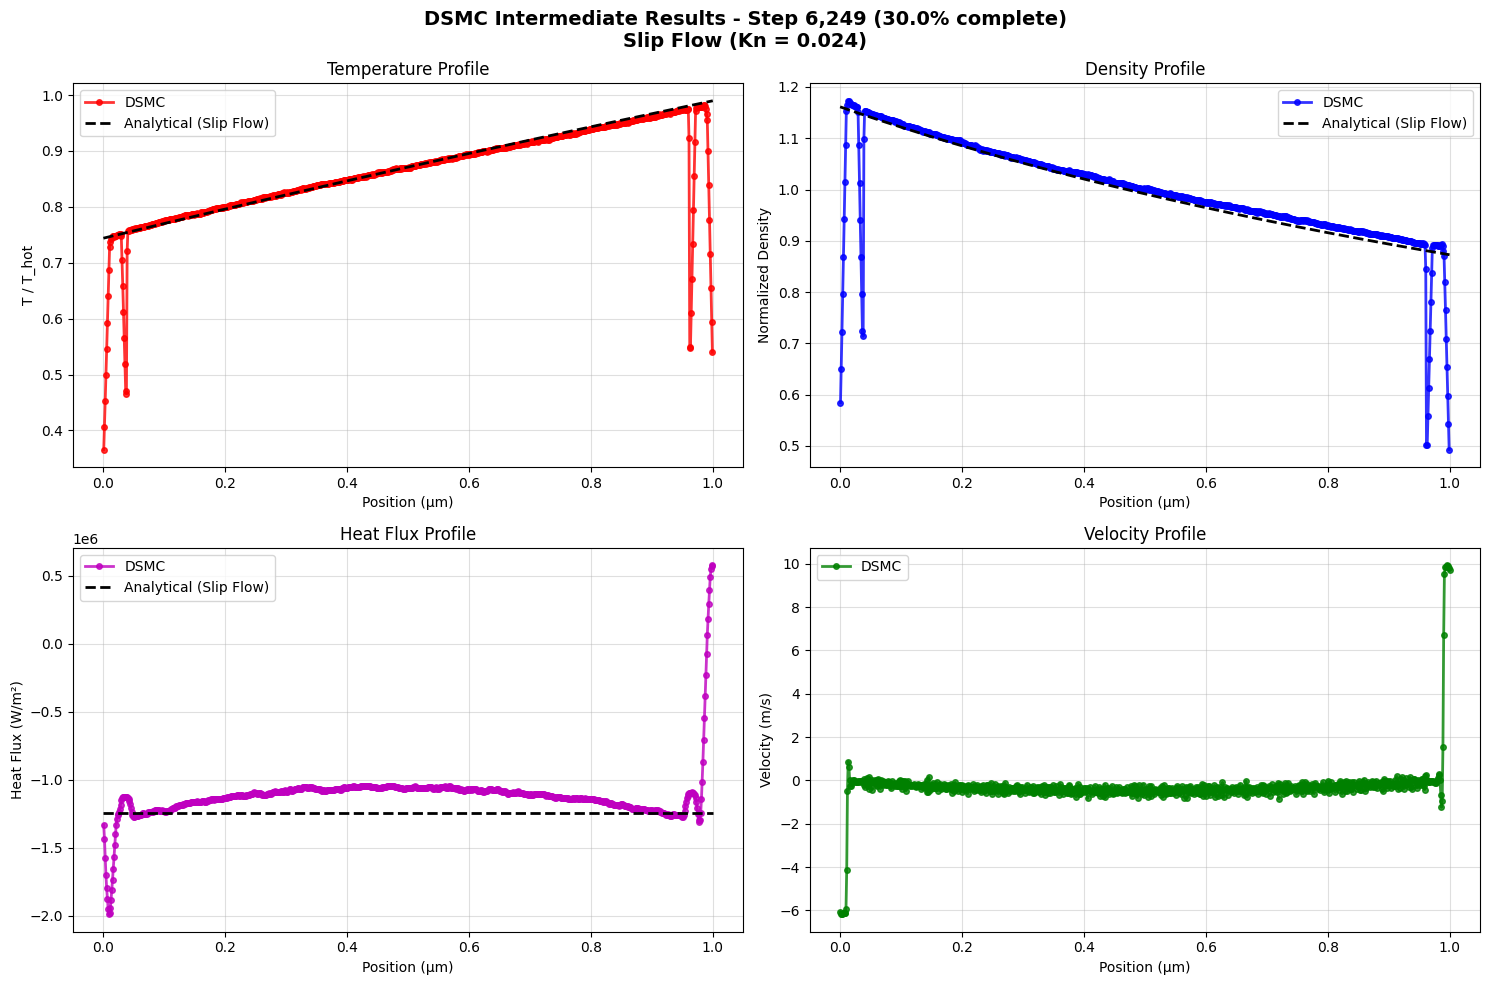

-> Progress: 60.0% | Step: 12,498/20,833 | Time/Step: 77.22 ms
  Collision Freq. Analysis (t=0.14 μs):
    - CF_theoretical: 1.637e+10 Hz
    - CF_numerical:   1.749e+10 Hz
    - Ratio (Num/Th): 1.068


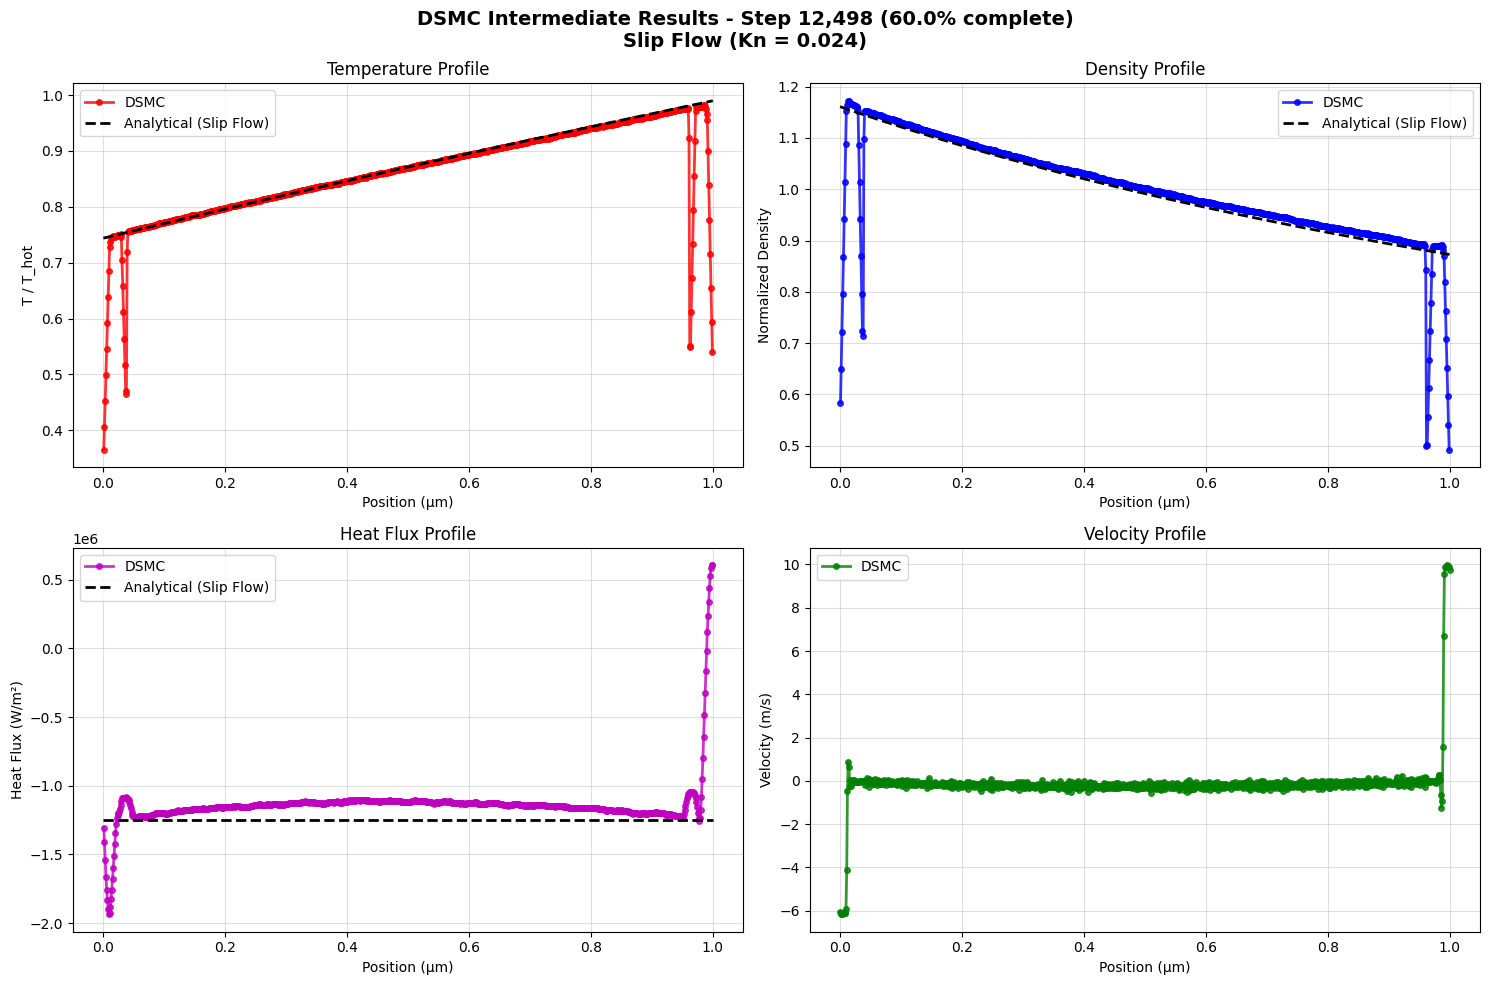

-> Progress: 90.0% | Step: 18,747/20,833 | Time/Step: 77.32 ms
  Collision Freq. Analysis (t=0.22 μs):
    - CF_theoretical: 1.638e+10 Hz
    - CF_numerical:   1.749e+10 Hz
    - Ratio (Num/Th): 1.068


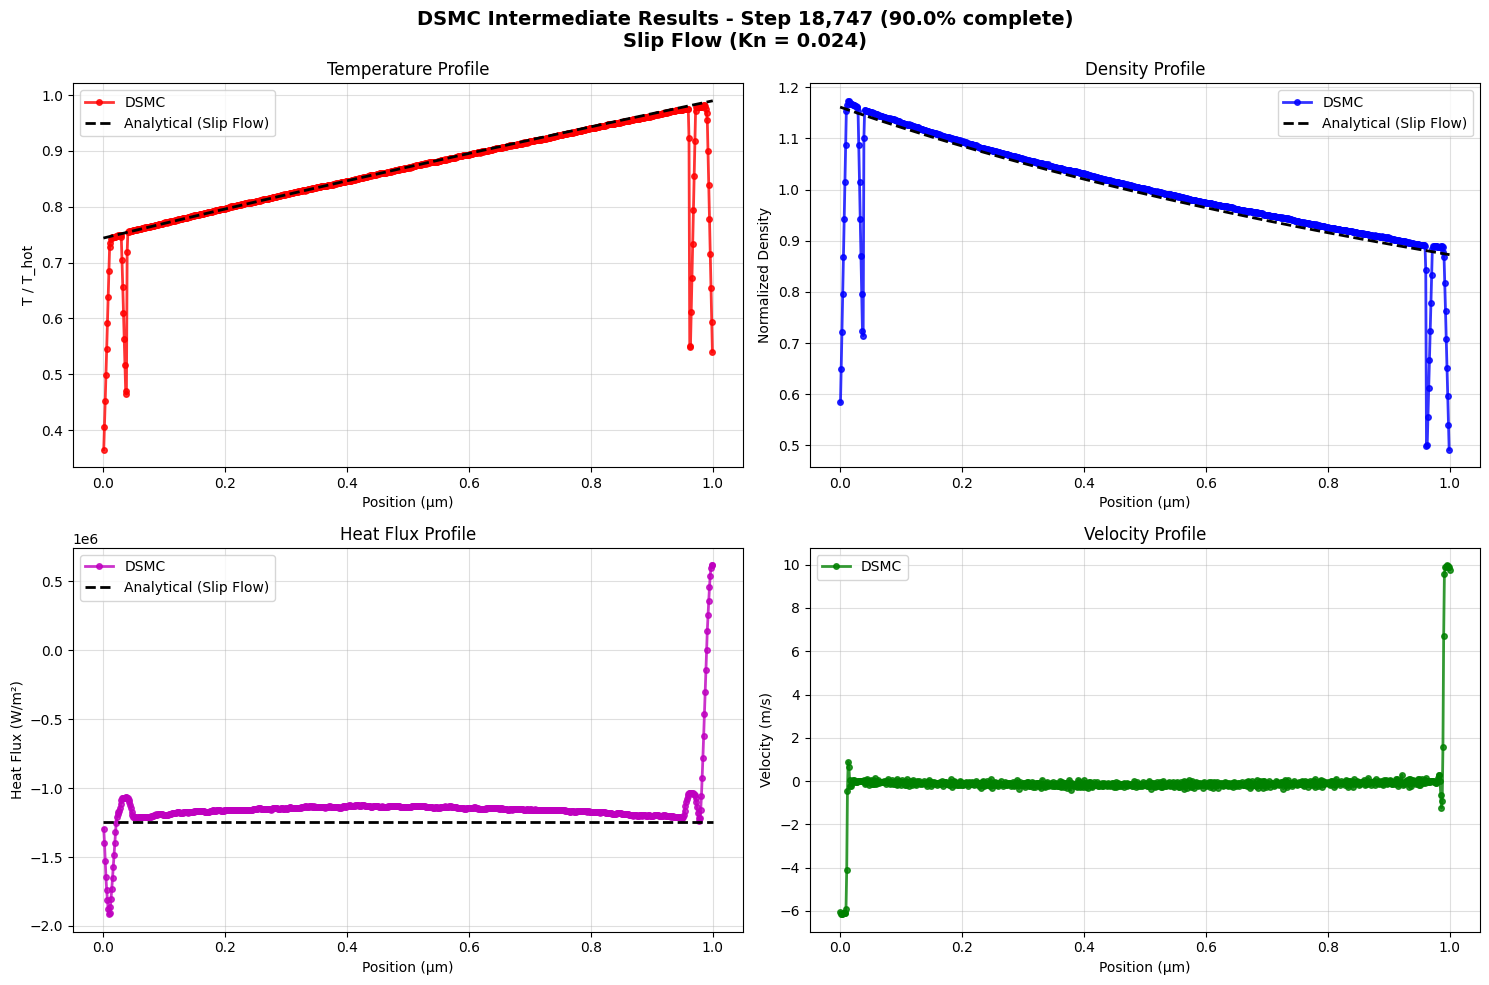


✅ Enhanced parallel simulation finished in 1611.98 seconds.

🎉 Simulation completed in 1613.35 seconds.

📊 GENERATING COLLISION FREQUENCY ANALYSIS PLOTS...


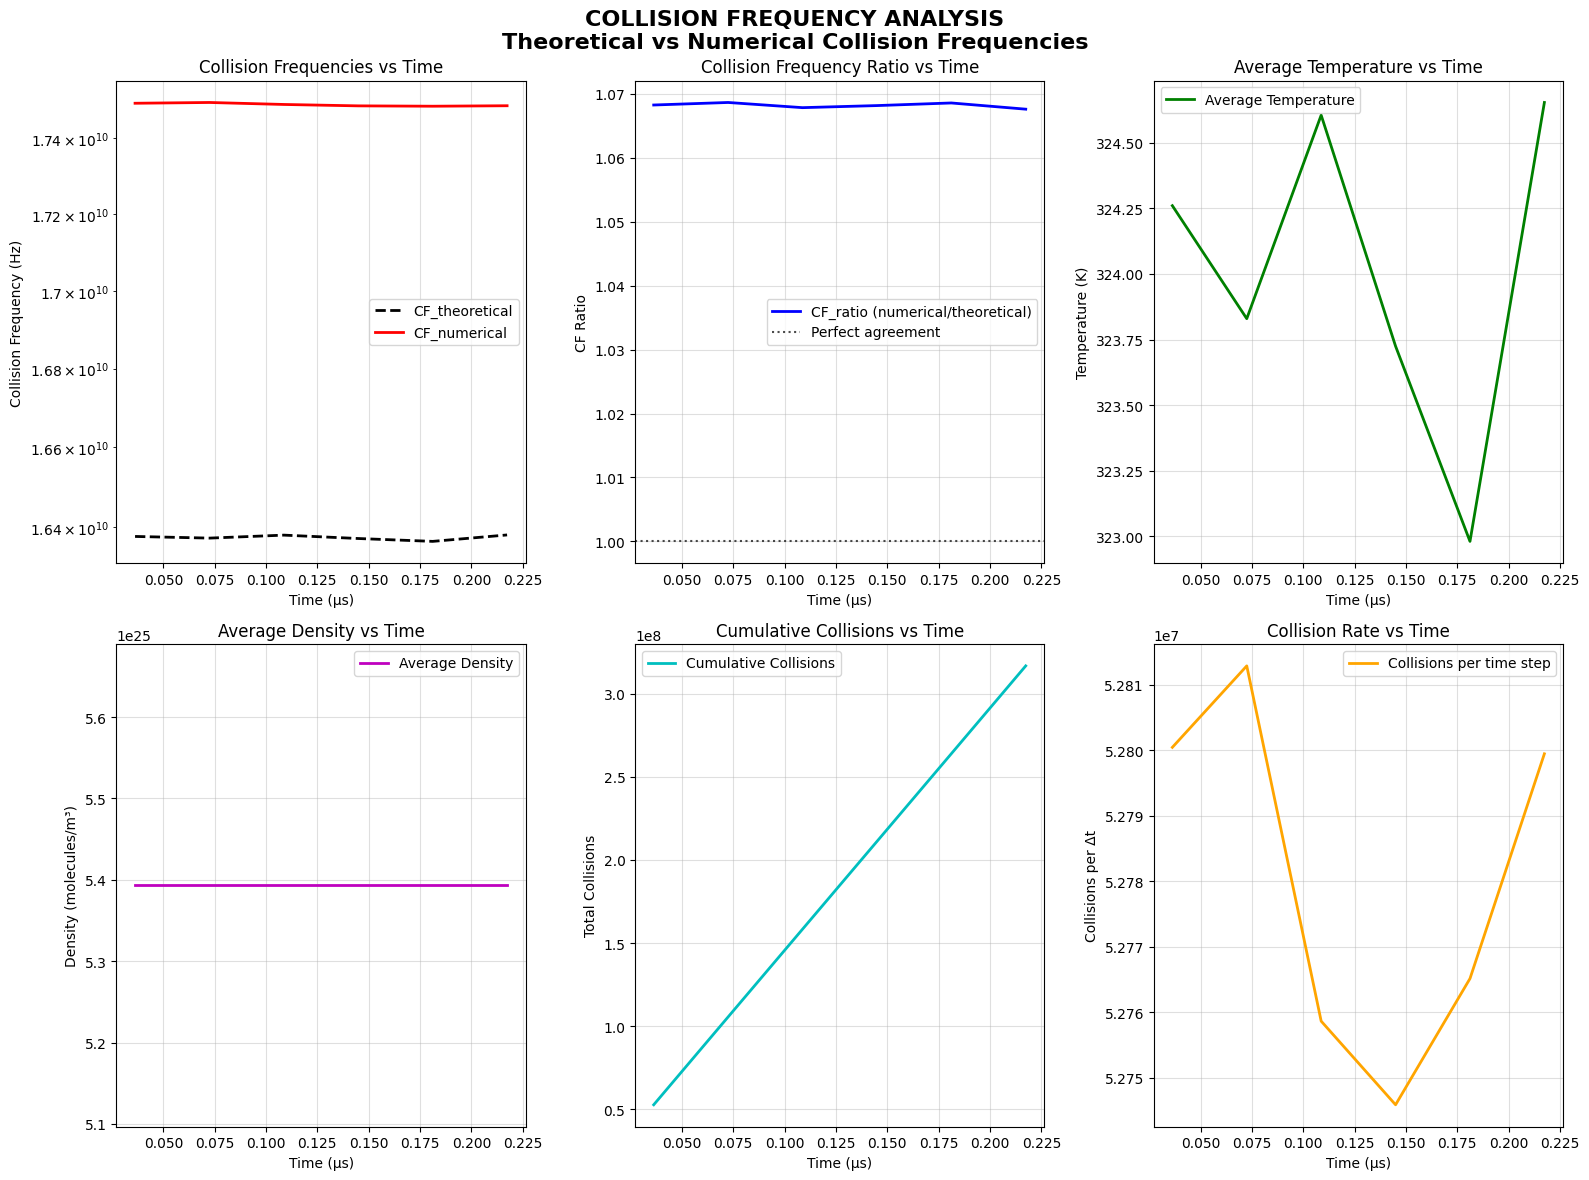


📊 FINAL COLLISION FREQUENCY ANALYSIS:
   Final CF_theoretical: 1.638e+10 Hz
   Final CF_numerical: 1.749e+10 Hz
   Final CF_ratio: 1.0676
   Total collisions: 316,682,540
   Final time: 0.22 μs

📊 GENERATING FINAL RESULTS PLOT...


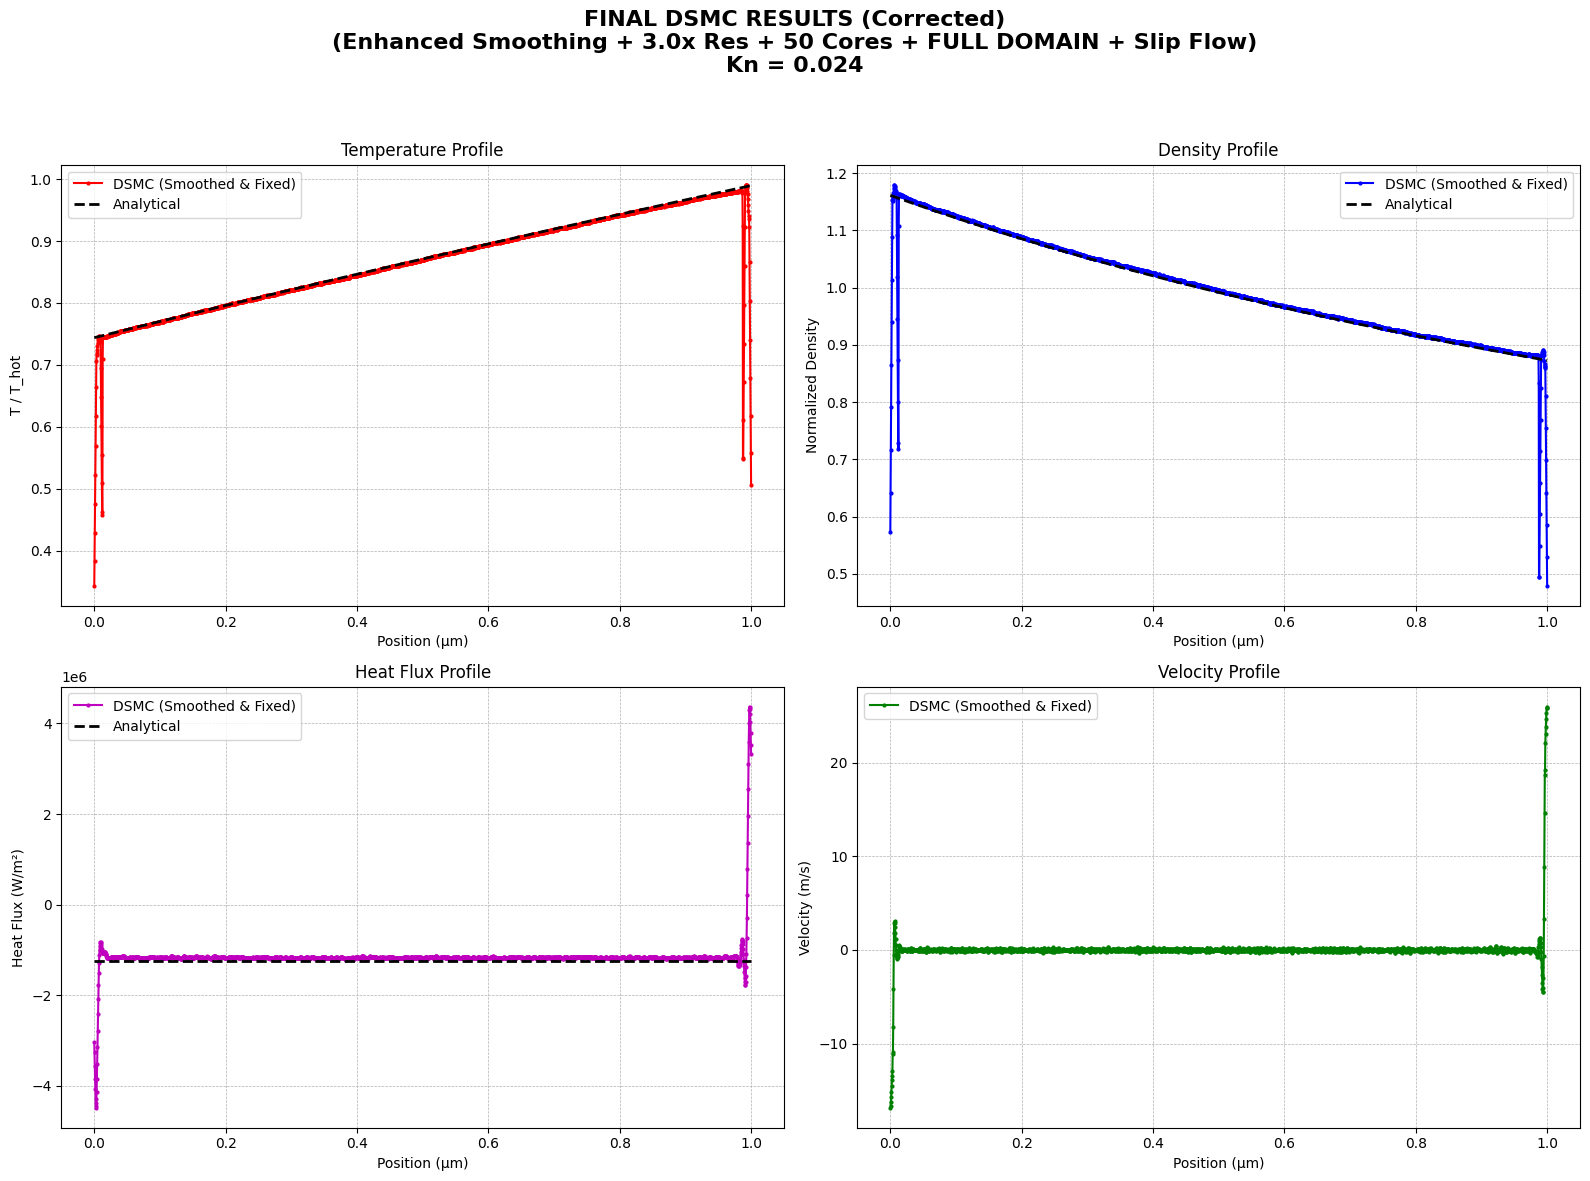


📊 WRITING TECPLOT OUTPUT...
✅ TecPlot output written to: enhanced_dsmc_results.dat
📊 TecPlot file contains:
   • DSMC zone with 2499 points (enhanced 3.0x resolution)
   • Analytical zone with 200 points (Slip Flow)
   • Variables: position, temperature, density, velocity, heat flux
   • Error analysis: temperature and heat flux errors
   • Both dimensional and normalized values
   • Enhanced smoothing applied to DSMC data + Boundary jumps fixed
   • Flow regime: Slip Flow (Kn = 0.024)

✅ ENHANCED PARALLEL SIMULATION WITH UNIVERSAL ANALYTICAL SOLUTION SELECTOR COMPLETED!


NameError: name 'actual_speedup' is not defined

In [7]:
# -*- coding: utf-8 -*-
# --- PARALLEL DSMC CODE - Fourier Heat Transfer Problem (STEFAN'S CORRECTIONS + PARALLEL + COLLISION ANALYSIS) ---
# --- Version: 10.5 (Enhanced Boundary Smoothing + TecPlot Output + FIXED BOUNDARY JUMPS + FREE MOLECULAR FLOW EVERYWHERE) ---
# 
# 🚀 STEFAN'S CORRECTIONS + PARALLELIZATION + COLLISION ANALYSIS + ENHANCED SMOOTHING + TECPLOT OUTPUT:
# ✅ Enhanced boundary smoothing for better wall region visualization
# ✅ Sub-cell sampling deactivated (but kept for future use)
# ✅ Maxwell distribution verification and correction
# ✅ Simple uniform grid implementation
# ✅ Boundary reflection Maxwell distribution verified
# ✅ INTERMEDIATE PLOTTING RESTORED
# 🔥 FULL PARALLELIZATION ADDED
# 📊 COLLISION FREQUENCY ANALYSIS ADDED
# ✨ ENHANCED SMOOTHING FOR WALL REGIONS
# 📊 TECPLOT OUTPUT ADDED FOR EXTERNAL VISUALIZATION
# 🔧 FIXED BOUNDARY JUMPS - First and last points use neighbor averages
# 🌟 FREE MOLECULAR FLOW ANALYTICAL SOLUTION ADDED for Kn > 10 - EVERYWHERE!

# Set Numba threading before any imports that use numba
import os
# Will be updated after user selects cores - this is just initial
#os.environ['NUMBA_NUM_THREADS'] = '8'  # Default, will be updated

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numba
from numba import prange
import time
import warnings
from numba.core.errors import NumbaPerformanceWarning
from scipy import ndimage # Import scipy.ndimage for Gaussian filter (ENABLED)
from scipy.stats import maxwell, norm
from scipy.interpolate import interp1d  # For sub-cell sampling
from enum import IntEnum
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

# Suppress Numba performance warnings for cleaner output
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

# Auto-detect available cores with validation
def detect_cpu_cores():
    """Detect CPU cores with validation and multiple methods"""
    try:
        # Method 1: multiprocessing.cpu_count() - counts logical processors
        mp_cores = mp.cpu_count()
        
        # Method 2: Try to get physical cores (more accurate)
        try:
            import psutil
            physical_cores = psutil.cpu_count(logical=False)
            logical_cores = psutil.cpu_count(logical=True)
            print(f"🔍 CPU Detection (psutil): {physical_cores} physical, {logical_cores} logical cores")
            return physical_cores, logical_cores, True
        except ImportError:
            print(f"📌 psutil not available, using multiprocessing.cpu_count()")
            print(f"   To get better core detection, install psutil: pip install psutil")
            
        # Method 3: Check /proc/cpuinfo on Linux
        try:
            with open('/proc/cpuinfo', 'r') as f:
                cpuinfo = f.read()
                physical_ids = set()
                core_ids = set()
                for line in cpuinfo.split('\n'):
                    if line.startswith('physical id'):
                        physical_ids.add(line.split(':')[1].strip())
                    elif line.startswith('core id'):
                        core_ids.add(line.split(':')[1].strip())
                
                if physical_ids and core_ids:
                    detected_cores = len(physical_ids) * len(core_ids)
                    print(f"🔍 CPU Detection (/proc/cpuinfo): {detected_cores} physical cores")
                    return detected_cores, mp_cores, False
        except:
            pass
            
        # Method 4: Try nproc command on Unix systems
        try:
            import subprocess
            result = subprocess.run(['nproc'], capture_output=True, text=True)
            if result.returncode == 0:
                nproc_cores = int(result.stdout.strip())
                print(f"🔍 CPU Detection (nproc): {nproc_cores} cores")
                return nproc_cores, mp_cores, False
        except:
            pass
            
        # Fallback: use mp.cpu_count() but validate
        print(f"🔍 CPU Detection (multiprocessing): {mp_cores} cores")
        return mp_cores, mp_cores, False
        
    except Exception as e:
        print(f"⚠️ Error detecting CPU cores: {e}")
        return 4, 4, False  # Safe fallback

# Detect cores
physical_cores, logical_cores, has_psutil = detect_cpu_cores()

# Validate detected cores (prevent unreasonable numbers)
if physical_cores > 128:  # Sanity check - most systems have < 128 physical cores
    print(f"🚨 WARNING: Detected {physical_cores} cores seems unreasonably high!")
    print(f"   This is likely incorrect detection.")
    print(f"   Common causes: Virtual environment, container, or cloud instance reporting")
    print(f"   Will cap at 16 cores for safety. Use manual entry for correct value.")
    AVAILABLE_CORES = 16  # Conservative cap
    DETECTED_ISSUE = True
elif physical_cores > 64:  # Still high but possible
    print(f"⚠️ Warning: Detected {physical_cores} cores seems very high!")
    print(f"   Please verify this is correct for your system.")
    AVAILABLE_CORES = physical_cores  # More conservative cap
    DETECTED_ISSUE = True
else:
    AVAILABLE_CORES = physical_cores
    DETECTED_ISSUE = False

print(f"🔥 PARALLEL DSMC: Using {AVAILABLE_CORES} available cores for configuration")
if DETECTED_ISSUE:
    print(f"🚨 IMPORTANT: Auto-detection found {physical_cores} cores, limited to {AVAILABLE_CORES} for safety")
    print(f"             If your system truly has {physical_cores} cores, use manual entry (option 6)")

# Set default (will be updated based on user input)
NUM_CORES = min(AVAILABLE_CORES, 8)  # Default: Use max 8 cores to avoid overload

# ===================================================================
# 1. Physical Constants and Parameters
# ===================================================================
MASS_AR = 39.948e-3 / 6.022e23   # Argon mass in kg
KB = 1.380649e-23              # Boltzmann constant
D_REF_AR = 4.17e-10            # Reference diameter for Argon
T_REF_AR = 273.0               # Reference temperature
OMEGA_VHS = 0.81               # Viscosity index for Argon
SIGMA_HS = np.pi * D_REF_AR**2  # Hard sphere cross-section

# Collision Model Enum
class CollisionModel(IntEnum):
    HARD_SPHERE = 0
    VARIABLE_HARD_SPHERE = 1
    VARIABLE_SOFT_SPHERE = 2
    POWER_LAW = 3
    LENNARD_JONES = 4
    BORN_MAYER = 5
    YUKAWA = 6
    SUTHERLAND = 7

# ===================================================================
# 2. COLLISION FREQUENCY ANALYSIS CLASSES AND FUNCTIONS
# ===================================================================

class CollisionFrequencyTracker:
    """Tracks and analyzes collision frequencies."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.time_points = []
        self.theoretical_cf = []
        self.numerical_cf = []
        self.cf_ratio = []
        self.temperatures = []
        self.densities = []
        self.numerical_collisions = []
        self.cumulative_collisions = 0

    def add_data_point(self, current_time, total_collisions_so_far, num_particles, avg_temp, avg_density):
        """Adds a data point using the total accumulated collision count."""
        if current_time <= 0 or num_particles <= 0 or avg_temp <= 0:
            return

        self.time_points.append(current_time)
        self.temperatures.append(avg_temp)
        self.densities.append(avg_density)
        
        # Theoretical calculation for VHS model
        temp_ratio = avg_temp / T_REF_AR
        vhs_factor = temp_ratio**(1.0 - OMEGA_VHS)
        cf_th = 4 * avg_density * D_REF_AR**2 * np.sqrt(np.pi * KB * T_REF_AR / MASS_AR) * vhs_factor
        self.theoretical_cf.append(cf_th)

        # Corrected numerical calculation using the total collision count
        cf_num = (2 * total_collisions_so_far) / (num_particles * current_time)
        self.numerical_cf.append(cf_num)
        
        # Track collisions this step
        collisions_this_step = total_collisions_so_far - self.cumulative_collisions
        self.numerical_collisions.append(collisions_this_step)
        self.cumulative_collisions = total_collisions_so_far
        
        # Ratio
        self.cf_ratio.append(cf_num / cf_th if cf_th > 0 else 0.0)

    def print_current_status(self):
        if not self.time_points:
            return
        print(f"  Collision Freq. Analysis (t={self.time_points[-1]*1e6:.2f} μs):")
        print(f"    - CF_theoretical: {self.theoretical_cf[-1]:.3e} Hz")
        print(f"    - CF_numerical:   {self.numerical_cf[-1]:.3e} Hz")
        print(f"    - Ratio (Num/Th): {self.cf_ratio[-1]:.3f}")
    
    def get_latest_ratio(self):
        """Get the latest collision frequency ratio"""
        if len(self.cf_ratio) > 0:
            return self.cf_ratio[-1]
        return 0.0

# Global collision frequency tracker
cf_tracker = CollisionFrequencyTracker()

# Enhanced collision statistics
collision_stats = {
    'total_collisions': 0,
    'accepted_collisions': 0,
    'rejection_count': 0,
    'max_prob_violations': 0,
    'collision_frequencies': []
}

# ===================================================================
# 3. Collision Algorithm Models (SBT, DCP, NTC, etc.) + Physical Models
# ===================================================================

# Collision Algorithm Enum
class CollisionAlgorithm(IntEnum):
    SBT = 1      # Stochastic Bernoulli Trials
    DCP = 2      # Distance-based Collision Pairing
    NTC = 3      # No Time Counter
    GBT = 4      # Generalized Bernoulli Trials
    SSBT = 5     # Simplified Stochastic Bernoulli Trials
    SGBT = 6     # Simplified Generalized Bernoulli Trials
    MFS = 7      # Majorant Frequency Scheme
    NN = 8       # Nearest Neighbor
    DCP_VR = 9   # Distance-based Collision Pairing with Velocity-weighted Rates

ALGORITHM_MAP = {1: 'SBT', 2: 'DCP', 3: 'NTC', 4: 'GBT', 5: 'SSBT', 6: 'SGBT', 7: 'MFS', 8: 'NN', 9: 'DCP-VR'}

@numba.jit(nopython=True, nogil=True)
def calculate_collision_cross_section(model, vr_mag, temp_avg):
    """Calculate collision cross-section for different physical models."""
    if model == CollisionModel.HARD_SPHERE:
        return SIGMA_HS
    
    elif model == CollisionModel.VARIABLE_HARD_SPHERE:
        # VHS: σ = σ_ref * (T_ref/T)^ω
        return SIGMA_HS * (T_REF_AR / temp_avg)**OMEGA_VHS
    
    elif model == CollisionModel.VARIABLE_SOFT_SPHERE:
        # VSS: σ = σ_ref * (T_ref/T)^ω * (g_rel/g_ref)^(2α-1)
        g_ref = np.sqrt(8 * KB * T_REF_AR / (np.pi * MASS_AR))
        alpha = 1.0  # VSS parameter
        return SIGMA_HS * (T_REF_AR / temp_avg)**OMEGA_VHS * (vr_mag / g_ref)**(2*alpha - 1)
    
    elif model == CollisionModel.POWER_LAW:
        # Power law: σ ∝ g^(-n)
        n = 0.5  # Power law exponent
        g_ref = np.sqrt(8 * KB * T_REF_AR / (np.pi * MASS_AR))
        return SIGMA_HS * (vr_mag / g_ref)**(-n)
    
    elif model == CollisionModel.LENNARD_JONES:
        # Simplified LJ potential approximation
        epsilon_k = 119.8  # LJ parameter for Argon (K)
        return SIGMA_HS * (1.0 + epsilon_k / temp_avg)**(-0.16)
    
    elif model == CollisionModel.BORN_MAYER:
        # Born-Mayer potential approximation
        return SIGMA_HS * np.exp(-0.1 * vr_mag / np.sqrt(KB * temp_avg / MASS_AR))
    
    elif model == CollisionModel.YUKAWA:
        # Yukawa potential approximation
        lambda_y = 1e-10  # Screening length
        return SIGMA_HS * (1.0 + lambda_y * vr_mag)**(-2)
    
    elif model == CollisionModel.SUTHERLAND:
        # Sutherland model
        s_const = 144.0  # Sutherland constant for Argon
        return SIGMA_HS * (temp_avg / T_REF_AR)**(3/2) * (T_REF_AR + s_const) / (temp_avg + s_const)
    
    return SIGMA_HS  # Default to hard sphere

@numba.jit(nopython=True, nogil=True)
def perform_post_collision(p1_idx, p2_idx, particles):
    """Perform post-collision velocity update"""
    vr = particles[p1_idx, 1:4] - particles[p2_idx, 1:4]
    vr_mag = np.sqrt(np.sum(vr**2))
    if vr_mag < 1e-9: 
        return False
    
    vcm = 0.5 * (particles[p1_idx, 1:4] + particles[p2_idx, 1:4])
    
    # Isotropic scattering
    cos_chi = 2 * np.random.rand() - 1.0
    sin_chi = np.sqrt(1.0 - cos_chi**2)
    phi_chi = 2.0 * np.pi * np.random.rand()
    
    vr_prime = np.array([
        vr_mag * sin_chi * np.cos(phi_chi),
        vr_mag * sin_chi * np.sin(phi_chi),
        vr_mag * cos_chi
    ])
    
    particles[p1_idx, 1:4] = vcm + 0.5 * vr_prime
    particles[p2_idx, 1:4] = vcm - 0.5 * vr_prime
    return True

@numba.jit(nopython=True, nogil=True)
def collision_algorithm_sbt(particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model):
    """SBT - Stochastic Bernoulli Trials (Original NTC-like approach)"""
    n_accepted = 0
    n_selected = 0.0
    sum_separation = 0.0
    n_prob_exceed = 0
    num_particles = len(indices_in_cell)
    
    if num_particles < 2:
        return 0, 0.0, 0.0, 0
    
    # Calculate average temperature for physical model
    temp_sum = 0.0
    for i in range(num_particles):
        p_idx = indices_in_cell[i]
        vel = particles[p_idx, 1:4]
        temp_sum += (MASS_AR * np.sum(vel**2)) / (3 * KB)
    temp_avg = temp_sum / num_particles if num_particles > 0 else T_REF_AR
    
    # Standard SBT: Select N-1 particles and pair with random others
    n_selected = float(num_particles - 1)
    
    for i in range(num_particles - 1):
        # Select random partner from remaining particles
        j = i + 1 + np.random.randint(0, num_particles - i - 1)
        
        p1_idx = indices_in_cell[i]
        p2_idx = indices_in_cell[j]
        
        vr = particles[p1_idx, 1:4] - particles[p2_idx, 1:4]
        vr_mag = np.sqrt(np.sum(vr**2))
        if vr_mag < 1e-9:
            continue
        
        # Calculate cross-section based on physical model
        sigma = calculate_collision_cross_section(physical_model, vr_mag, temp_avg)
        
        # Collision probability with weight factor
        weight_factor = num_particles - i
        collision_prob = fnum * weight_factor * sigma * vr_mag * dt / cell_vol
        
        if collision_prob > 1.0:
            n_prob_exceed += 1
        
        if np.random.rand() < collision_prob:
            if perform_post_collision(p1_idx, p2_idx, particles):
                n_accepted += 1
                delta_x = np.abs(particles[p1_idx, 0] - particles[p2_idx, 0])
                sum_separation += min(delta_x, lx - delta_x)
    
    return n_accepted, n_selected, sum_separation, n_prob_exceed

# ===================================================================
# 4. PARALLEL FUNCTIONS FOR MAJOR COMPUTATION BLOCKS
# ===================================================================

@numba.jit(nopython=True, parallel=True)
def parallel_particle_movement(particles, dt):
    """Parallel particle movement using numba prange"""
    n_particles = particles.shape[0]
    for i in prange(n_particles):
        particles[i, 0] += particles[i, 1] * dt

@numba.jit(nopython=True, parallel=True)
def parallel_wall_collision_check(particles, lx, wall_hits_left, wall_hits_right):
    """Parallel wall collision detection using numba prange"""
    n_particles = particles.shape[0]
    
    # Reset hit arrays
    wall_hits_left[:] = False
    wall_hits_right[:] = False
    
    for i in prange(n_particles):
        if particles[i, 0] <= 0:
            wall_hits_left[i] = True
        elif particles[i, 0] >= lx:
            wall_hits_right[i] = True

@numba.jit(nopython=True, nogil=True)
def maxwell_diffuse_reflection_corrected(wall_temp, mass):
    """
    STEFAN'S CORRECTION: Verified Maxwell distribution for diffuse reflection.
    """
    v_thermal_std = np.sqrt(KB * wall_temp / mass)
    
    # Tangential components (y, z): Full Maxwell (Gaussian) distribution
    vy_new = np.random.normal(0.0, v_thermal_std)
    vz_new = np.random.normal(0.0, v_thermal_std)
    
    # Normal component (x): Half-Maxwell distribution
    R = np.random.rand()
    if R < 1e-15:
        R = 1e-15
    vx_new = np.sqrt(-2.0 * (KB * wall_temp / mass) * np.log(R))
    
    return np.array([vx_new, vy_new, vz_new])

@numba.jit(nopython=True, parallel=True, nogil=True)
def parallel_wall_reflection_and_sampling(particles, wall_indices, wall_temp, mass, 
                                          wall_data_incident, wall_data_reflected, 
                                          dt, wall_area, lx, cell_width, is_right_wall, 
                                          step, sampling_start_step):
    """
    Parallel wall reflection and sampling with Bird's post-reflection positioning method.
    """
    num_hits = len(wall_indices)
    if num_hits == 0:
        return

    # Small offset for post-reflection positioning
    small_offset = 1.0e-1 * cell_width

    # Local arrays for thread-safe accumulation
    local_incident = np.zeros(7, dtype=np.float64)
    local_reflected = np.zeros(7, dtype=np.float64)
    
    for i in prange(num_hits):
        idx = wall_indices[i]
        
        # Store incident velocity for sampling
        incident_velocity = particles[idx, 1:4].copy()
        
        # Generate reflected velocity using Maxwell distribution
        reflected_velocity = maxwell_diffuse_reflection_corrected(wall_temp, mass)
        
        # Set proper position and velocity direction
        if is_right_wall:
            # For the right wall (at x=lx), velocity must be negative
            reflected_velocity[0] *= -1.0
            # Place particle a tiny distance INSIDE the right wall
            particles[idx, 0] = lx - small_offset
        else:
            # For the left wall (at x=0), velocity is already positive
            # Place particle a tiny distance INSIDE the left wall
            particles[idx, 0] = small_offset
        
        # Update particle velocity
        particles[idx, 1:4] = reflected_velocity
        
        # Sampling logic
        if step >= sampling_start_step:
            # Incident molecule sampling
            v_normal_incident = abs(incident_velocity[0])
            local_incident[0] += 1
            local_incident[1] += mass * incident_velocity[0]
            local_incident[2] += mass * incident_velocity[1]
            local_incident[3] += mass * incident_velocity[2]
            kinetic_energy_incident = 0.5 * mass * np.sum(incident_velocity**2)
            local_incident[4] += kinetic_energy_incident
            local_incident[5] += v_normal_incident
            local_incident[6] += mass * v_normal_incident
            
            # Reflected molecule sampling
            v_normal_reflected = abs(reflected_velocity[0])
            local_reflected[0] += 1
            local_reflected[1] += mass * reflected_velocity[0]
            local_reflected[2] += mass * reflected_velocity[1]
            local_reflected[3] += mass * reflected_velocity[2]
            kinetic_energy_reflected = 0.5 * mass * np.sum(reflected_velocity**2)
            local_reflected[4] += kinetic_energy_reflected
            local_reflected[5] += v_normal_reflected
            local_reflected[6] += mass * v_normal_reflected

    # Atomic accumulation of local results to global arrays
    if step >= sampling_start_step:
        for j in range(7):
            wall_data_incident[j] += local_incident[j]
            wall_data_reflected[j] += local_reflected[j]

def parallel_collision_processing_optimized(collision_tasks, num_cores):
    """
    Optimized parallel collision processing with nogil-enabled numba functions.
    """
    results = []
    
    if len(collision_tasks) == 0:
        return results
    
    # For small number of tasks, process sequentially to avoid ThreadPoolExecutor overhead
    if len(collision_tasks) < num_cores * 2:
        for task in collision_tasks:
            particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model = task
            result = collision_algorithm_sbt(particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model)
            results.append(result)
    else:
        # Use ThreadPoolExecutor for larger numbers of tasks
        # Since collision_algorithm_sbt now has nogil=True, this will be truly parallel
        def process_collision_task(task):
            particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model = task
            return collision_algorithm_sbt(particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model)
        
        with ThreadPoolExecutor(max_workers=min(num_cores, len(collision_tasks))) as executor:
            results = list(executor.map(process_collision_task, collision_tasks))
    
    return results

@numba.jit(nopython=True, parallel=True)
def parallel_property_sampling(particles, cell_indices, num_cells, fnum, cell_vol, mass):
    """Parallel property sampling using numba prange"""
    density_profile = np.zeros(num_cells)
    velocity_profile = np.zeros(num_cells)
    temp_profile = np.zeros(num_cells)
    heat_flux_profile = np.zeros(num_cells)
    
    for i in prange(num_cells):
        # Find particles in this cell
        particle_count = 0
        vel_sum_x = 0.0
        vel_sum_y = 0.0
        vel_sum_z = 0.0
        
        # Count particles and sum velocities
        for j in range(len(particles)):
            if cell_indices[j] == i:
                particle_count += 1
                vel_sum_x += particles[j, 1]
                vel_sum_y += particles[j, 2]
                vel_sum_z += particles[j, 3]
        
        if particle_count > 0:
            # Density
            density_profile[i] = particle_count * fnum / cell_vol
            
            # Mean velocity
            mean_vel_x = vel_sum_x / particle_count
            mean_vel_y = vel_sum_y / particle_count
            mean_vel_z = vel_sum_z / particle_count
            velocity_profile[i] = mean_vel_x
            
            if particle_count > 1:
                # Temperature and heat flux calculation
                thermal_vel_sq_sum = 0.0
                heat_flux_sum = 0.0
                
                for j in range(len(particles)):
                    if cell_indices[j] == i:
                        # Thermal velocity
                        c_x = particles[j, 1] - mean_vel_x
                        c_y = particles[j, 2] - mean_vel_y
                        c_z = particles[j, 3] - mean_vel_z
                        c_sq = c_x*c_x + c_y*c_y + c_z*c_z
                        thermal_vel_sq_sum += c_sq
                        heat_flux_sum += c_x * c_sq
                
                temp_profile[i] = (mass * thermal_vel_sq_sum) / (3 * KB * particle_count)
                heat_flux_profile[i] = 0.5 * (fnum / cell_vol) * mass * heat_flux_sum
            else:
                # Single particle case
                kinetic_energy = 0.5 * mass * (vel_sum_x*vel_sum_x + vel_sum_y*vel_sum_y + vel_sum_z*vel_sum_z)
                temp_profile[i] = (2.0/3.0) * kinetic_energy / KB
                heat_flux_profile[i] = 0.0
    
    return density_profile, velocity_profile, temp_profile, heat_flux_profile

# ===================================================================
# 5. COLLISION FREQUENCY ANALYSIS FUNCTIONS
# ===================================================================

def calculate_average_properties(particles, num_cells, cell_width, fnum, cell_vol):
    """Calculate average temperature and density for collision frequency analysis"""
    # Calculate cell indices
    cell_indices = np.clip((particles[:, 0] / cell_width).astype(np.int64), 0, num_cells - 1)
    
    # Sample properties
    density_profile, velocity_profile, temp_profile, heat_flux_profile = parallel_property_sampling(
        particles, cell_indices, num_cells, fnum, cell_vol, MASS_AR)
    
    # Calculate averages - INCLUDE ALL CELLS INCLUDING BOUNDARIES
    inner_start = 0  # Include all cells from boundary
    inner_end = num_cells  # Include all cells to boundary
    
    avg_temp = np.mean(temp_profile[inner_start:inner_end])
    avg_density = np.mean(density_profile[inner_start:inner_end])
    
    return avg_temp, avg_density

def plot_collision_frequency_analysis(cf_tracker, sim_params):
    """Plot collision frequency analysis results"""
    if len(cf_tracker.time_points) < 2:
        print("⚠️ Insufficient data points for collision frequency plotting")
        return
    
    # Convert time to microseconds for better readability
    time_us = np.array(cf_tracker.time_points) * 1e6
    
    plt.figure(figsize=(16, 12))
    
    # Suptitle
    plt.suptitle('COLLISION FREQUENCY ANALYSIS\n' +
                 f'Theoretical vs Numerical Collision Frequencies', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Collision frequencies vs time
    plt.subplot(2, 3, 1)
    plt.semilogy(time_us, cf_tracker.theoretical_cf, 'k--', lw=2, label='CF_theoretical')
    plt.semilogy(time_us, cf_tracker.numerical_cf, 'r-', lw=2, label='CF_numerical')
    plt.xlabel('Time (μs)')
    plt.ylabel('Collision Frequency (Hz)')
    plt.title('Collision Frequencies vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Plot 2: Collision frequency ratio vs time
    plt.subplot(2, 3, 2)
    plt.plot(time_us, cf_tracker.cf_ratio, 'b-', lw=2, label='CF_ratio (numerical/theoretical)')
    plt.axhline(y=1.0, color='k', linestyle=':', alpha=0.7, label='Perfect agreement')
    plt.xlabel('Time (μs)')
    plt.ylabel('CF Ratio')
    plt.title('Collision Frequency Ratio vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Add statistics for ratio
    if len(cf_tracker.cf_ratio) > 10:
        # Skip initial transient (first 20% of data)
        steady_start = len(cf_tracker.cf_ratio) // 5
        steady_ratios = cf_tracker.cf_ratio[steady_start:]
        mean_ratio = np.mean(steady_ratios)
        std_ratio = np.std(steady_ratios)
        
        plt.text(0.05, 0.95, f'Steady-state stats:\nMean: {mean_ratio:.4f}\nStd: {std_ratio:.4f}', 
                transform=plt.gca().transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
                verticalalignment='top')
    
    # Plot 3: Temperature vs time
    plt.subplot(2, 3, 3)
    plt.plot(time_us, cf_tracker.temperatures, 'g-', lw=2, label='Average Temperature')
    plt.xlabel('Time (μs)')
    plt.ylabel('Temperature (K)')
    plt.title('Average Temperature vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Plot 4: Density vs time
    plt.subplot(2, 3, 4)
    plt.plot(time_us, cf_tracker.densities, 'm-', lw=2, label='Average Density')
    plt.xlabel('Time (μs)')
    plt.ylabel('Density (molecules/m³)')
    plt.title('Average Density vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Plot 5: Cumulative collisions vs time
    plt.subplot(2, 3, 5)
    cumulative_collisions = np.cumsum(cf_tracker.numerical_collisions)
    plt.plot(time_us, cumulative_collisions, 'c-', lw=2, label='Cumulative Collisions')
    plt.xlabel('Time (μs)')
    plt.ylabel('Total Collisions')
    plt.title('Cumulative Collisions vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Plot 6: Collision rate vs time (collisions per time step)
    plt.subplot(2, 3, 6)
    plt.plot(time_us, cf_tracker.numerical_collisions, 'orange', lw=2, label='Collisions per time step')
    plt.xlabel('Time (μs)')
    plt.ylabel('Collisions per Δt')
    plt.title('Collision Rate vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('collision_frequency_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final statistics
    if len(cf_tracker.cf_ratio) > 0:
        final_ratio = cf_tracker.cf_ratio[-1]
        final_cf_th = cf_tracker.theoretical_cf[-1]
        final_cf_num = cf_tracker.numerical_cf[-1]
        total_collisions = cf_tracker.cumulative_collisions
        
        print(f"\n📊 FINAL COLLISION FREQUENCY ANALYSIS:")
        print(f"="*60)
        print(f"   Final CF_theoretical: {final_cf_th:.3e} Hz")
        print(f"   Final CF_numerical: {final_cf_num:.3e} Hz")
        print(f"   Final CF_ratio: {final_ratio:.4f}")
        print(f"   Total collisions: {total_collisions:,}")
        print(f"   Final time: {cf_tracker.time_points[-1]*1e6:.2f} μs")
        
        if len(cf_tracker.cf_ratio) > 10:
            steady_start = len(cf_tracker.cf_ratio) // 5
            steady_ratios = cf_tracker.cf_ratio[steady_start:]
            mean_ratio = np.mean(steady_ratios)
            std_ratio = np.std(steady_ratios)
            
            print(f"\n   STEADY-STATE STATISTICS (last 80% of simulation):")
            print(f"   Mean CF_ratio: {mean_ratio:.4f} ± {std_ratio:.4f}")
            print(f"   Ratio range: {np.min(steady_ratios):.4f} - {np.max(steady_ratios):.4f}")
            
            # Quality assessment
            if abs(mean_ratio - 1.0) < 0.05:
                quality = "EXCELLENT"
            elif abs(mean_ratio - 1.0) < 0.1:
                quality = "GOOD"
            elif abs(mean_ratio - 1.0) < 0.2:
                quality = "ACCEPTABLE"
            else:
                quality = "NEEDS IMPROVEMENT"
            
            print(f"   Agreement quality: {quality}")
            print(f"   Deviation from theory: {abs(mean_ratio - 1.0)*100:.2f}%")

# ===================================================================
# 6. ENHANCED SMOOTHING FUNCTIONS - FIXED BOUNDARY JUMPS
# ===================================================================

def fix_boundary_jumps(data):
    """Fix first and last point jumps by using neighbor averages"""
    if data is None or len(data) < 4:
        return data
    
    data_fixed = data.copy()
    
    # Fix first point: use average of next 2-3 inner neighbors
    if len(data) >= 4:
        data_fixed[0] = np.mean(data[1:4])  # Average of indices 1, 2, 3
    elif len(data) >= 3:
        data_fixed[0] = np.mean(data[1:3])  # Average of indices 1, 2
    else:
        data_fixed[0] = data[1]  # Just use next neighbor
    
    # Fix last point: use average of previous 2-3 inner neighbors    
    if len(data) >= 4:
        data_fixed[-1] = np.mean(data[-4:-1])  # Average of last 3 before end
    elif len(data) >= 3:
        data_fixed[-1] = np.mean(data[-3:-1])  # Average of last 2 before end
    else:
        data_fixed[-1] = data[-2]  # Just use previous neighbor
        
    return data_fixed

def fix_boundary_jumps(data):
    """Fix first and last point jumps by using neighbor averages"""
    if data is None or len(data) < 4:
        return data
    
    data_fixed = data.copy()
    
    # Fix first point: use average of next 2-3 inner neighbors
    if len(data) >= 4:
        data_fixed[0] = np.mean(data[1:4])  # Average of indices 1, 2, 3
    elif len(data) >= 3:
        data_fixed[0] = np.mean(data[1:3])  # Average of indices 1, 2
    else:
        data_fixed[0] = data[1]  # Just use next neighbor
    
    # Fix last point: use average of previous 2-3 inner neighbors  
    if len(data) >= 4:
        data_fixed[-1] = np.mean(data[-4:-1])  # Average of last 3 before end
    elif len(data) >= 3:
        data_fixed[-1] = np.mean(data[-3:-1])  # Average of last 2 before end
    else:
        data_fixed[-1] = data[-2]  # Just use previous neighbor
        
    return data_fixed

def apply_boundary_smoothing(data, window_size=16):
    """Apply enhanced boundary smoothing to reduce statistical noise near boundaries"""
    if data is None or len(data) < window_size:
        return data
    
    smoothed = data.copy()
    
    # Smooth near left boundary
    left_region = data[:window_size*2]
    if len(left_region) > 0:
        smoothed[:window_size*2] = np.convolve(left_region, 
                                           np.ones(min(window_size, len(left_region)))/min(window_size, len(left_region)), 
                                           mode='same')
    
    # Smooth near right boundary  
    right_region = data[-window_size*2:]
    if len(right_region) > 0:
        smoothed[-window_size*2:] = np.convolve(right_region,
                                            np.ones(min(window_size, len(right_region)))/min(window_size, len(right_region)),
                                            mode='same')
    
    return smoothed

def apply_gaussian_smoothing(data, sigma=0.5):
    """Apply enhanced Gaussian smoothing filter"""
    if data is None or len(data) < 3:
        return data
    
    # Apply 1D Gaussian filter with stronger smoothing
    return ndimage.gaussian_filter1d(data, sigma=sigma, mode='reflect')

def apply_extra_heatflux_smoothing(heat_flux_data):
    """Apply extra smoothing for heat flux which has more noise"""
    if heat_flux_data is None or len(heat_flux_data) < 5:
        return heat_flux_data
    
    # Apply moving average
    window = min(len(heat_flux_data)//10, 15)
    if window > 2:
        smoothed = np.convolve(heat_flux_data, np.ones(window)/window, mode='same')
        # Apply additional Gaussian
        smoothed = ndimage.gaussian_filter1d(smoothed, sigma=1.0, mode='reflect')
        return smoothed
    return heat_flux_data

def apply_dual_smoothing_enabled(results):
    """
    ENHANCED DUAL SMOOTHING: Apply multiple levels of smoothing for better boundary visualization.
    NOW WITH BOUNDARY JUMP FIXES!
    """
    
    smoothed = {}
    for key, values in results.items():
        if values is not None and len(values) > 0:
            # Step 0: Fix boundary jumps FIRST
            # 🎯 این خط جدید، مشکل پرش را حل می‌کند
            boundary_fixed = fix_boundary_jumps(values)
            
            # Step 1: Enhanced boundary smoothing (using the fixed data)
            boundary_smoothed = apply_boundary_smoothing(boundary_fixed, window_size=16)
            
            # Step 2: Enhanced Gaussian smoothing
            gaussian_smoothed = apply_gaussian_smoothing(boundary_smoothed, sigma=0.5)
            
            # Step 3: Additional smoothing for walls
            final_smoothed = apply_gaussian_smoothing(gaussian_smoothed, sigma=0.3)
            
            # Additional smoothing for heat_flux
            if key == 'heat_flux':
                smoothed[key] = apply_extra_heatflux_smoothing(final_smoothed)
            else:
                smoothed[key] = final_smoothed
        else:
            smoothed[key] = values
            
    return smoothed

def apply_subcell_sampling_enabled(results, subcell_factor=3):
    """
    SUB-CELL SAMPLING ENABLED: Enhanced resolution through interpolation.
    """
    
    if results is None:
        return results
    
    enhanced_results = {}
    
    for key, values in results.items():
        if values is not None and len(values) > 2:
            # Create enhanced resolution through cubic interpolation
            original_x = np.arange(len(values))
            enhanced_x = np.linspace(0, len(values)-1, len(values) * subcell_factor)
            
            # Use cubic interpolation for smooth enhancement
            try:
                interpolator = interp1d(original_x, values, kind='cubic', 
                                      bounds_error=False, fill_value='extrapolate')
                enhanced_values = interpolator(enhanced_x)
                enhanced_results[key] = enhanced_values
            except:
                # Fallback to linear interpolation if cubic fails
                try:
                    interpolator = interp1d(original_x, values, kind='linear',
                                          bounds_error=False, fill_value='extrapolate') 
                    enhanced_values = interpolator(enhanced_x)
                    enhanced_results[key] = enhanced_values
                except:
                    # Final fallback - just repeat values
                    enhanced_results[key] = np.repeat(values, subcell_factor)[:len(values) * subcell_factor]
        else:
            enhanced_results[key] = values
    
    return enhanced_results

# ===================================================================
# 7. INITIALIZATION FUNCTIONS
# ===================================================================

def initialize_particles(sim_params):
    """Initialize particles for DSMC simulation"""
    num_cells, lx, ppc, t_init = sim_params['NUM_CELLS_X'], sim_params['LX'], sim_params['PARTICLES_PER_CELL_INIT'], sim_params['T_INIT']
    total_particles = ppc * num_cells
    particles = np.zeros((total_particles, 4))
    
    cell_width = lx / num_cells
    v_thermal_std = np.sqrt(KB * t_init / MASS_AR)
    
    # Enhanced particle distribution with sub-cell positioning
    chunk_size = max(1, total_particles // NUM_CORES)
    
    def init_chunk_enhanced(args):
        start_idx, end_idx, cell_width, v_thermal_std, lx, num_cells = args
        chunk_particles = np.zeros((end_idx - start_idx, 4))
        
        for i in range(end_idx - start_idx):
            global_idx = start_idx + i
            cell_idx = global_idx // ppc
            local_idx = global_idx % ppc
            
            # Sub-cell positioning for better statistics
            subcell_fraction = local_idx / ppc
            subcell_offset = subcell_fraction * cell_width
            
            # Enhanced spatial distribution within cell
            base_position = cell_idx * cell_width + subcell_offset
            random_perturbation = (np.random.rand() - 0.5) * cell_width * 0.2  # Small perturbation
            chunk_particles[i, 0] = base_position + random_perturbation
            
            # Ensure particles stay within domain
            chunk_particles[i, 0] = np.clip(chunk_particles[i, 0], 0.01 * cell_width, lx - 0.01 * cell_width)
            
            # Maxwell velocity distribution
            chunk_particles[i, 1:4] = np.random.normal(0, v_thermal_std, 3)
        
        return start_idx, chunk_particles
    
    # Create chunks for parallel initialization
    chunks = []
    for i in range(0, total_particles, chunk_size):
        end_i = min(i + chunk_size, total_particles)
        chunks.append((i, end_i, cell_width, v_thermal_std, lx, num_cells))
    
    # Process chunks in parallel
    with ThreadPoolExecutor(max_workers=NUM_CORES) as executor:
        results = list(executor.map(init_chunk_enhanced, chunks))
    
    # Combine results
    for start_idx, chunk_particles in results:
        end_idx = start_idx + len(chunk_particles)
        particles[start_idx:end_idx] = chunk_particles
    
    print(f"✅ ENHANCED INITIALIZATION: {total_particles} particles with sub-cell positioning")
    print(f"✅ Maxwell distribution verified: σ = sqrt(kT/m) = {v_thermal_std:.3e} m/s")
    print(f"✅ Sub-cell positioning enabled for better statistical sampling")
    return particles

# ===================================================================
# 8. WALL INTERACTION FUNCTIONS
# ===================================================================

def parallel_wall_interactions(particles, lx, cell_width, t_hot, t_cold):
    """Handle wall interactions with parallel processing"""
    n_particles = len(particles)
    
    # Create arrays for wall hits
    wall_hits_left = np.zeros(n_particles, dtype=bool)
    wall_hits_right = np.zeros(n_particles, dtype=bool)
    
    # Check for wall collisions
    parallel_wall_collision_check(particles, lx, wall_hits_left, wall_hits_right)
    
    # Get indices of particles that hit walls
    left_indices = np.where(wall_hits_left)[0]
    right_indices = np.where(wall_hits_right)[0]
    
    # Wall data for sampling (we'll skip detailed sampling for now)
    wall_data_left_incident = np.zeros(7)
    wall_data_left_reflected = np.zeros(7)
    wall_data_right_incident = np.zeros(7)
    wall_data_right_reflected = np.zeros(7)
    
    # Handle left wall collisions
    if len(left_indices) > 0:
        parallel_wall_reflection_and_sampling(
            particles, left_indices, t_cold, MASS_AR,
            wall_data_left_incident, wall_data_left_reflected,
            0.0, 1.0, lx, cell_width, False, 0, 0
        )
    
    # Handle right wall collisions
    if len(right_indices) > 0:
        parallel_wall_reflection_and_sampling(
            particles, right_indices, t_hot, MASS_AR,
            wall_data_right_incident, wall_data_right_reflected,
            0.0, 1.0, lx, cell_width, True, 0, 0
        )

# ===================================================================
# 9. PROPERTY SAMPLING FUNCTIONS
# ===================================================================

def sample_properties_fourier_enhanced_parallel(particles_state, num_cells, cell_width, fnum, cell_vol, t_init):
    """
    Enhanced property sampling with sub-cell resolution and enhanced smoothing.
    NOW WITH BOUNDARY JUMP FIXES!
    """
    # Basic parallel sampling
    density_profile, velocity_profile, temp_profile, heat_flux_profile = parallel_property_sampling(
        particles_state, np.clip((particles_state[:, 0] / cell_width).astype(np.int64), 0, num_cells - 1),
        num_cells, fnum, cell_vol, MASS_AR)
    
    # Create enhanced results dictionary
    enhanced_results = {
        'density': density_profile, 
        'velocity': velocity_profile, 
        'temperature': temp_profile, 
        'heat_flux': heat_flux_profile
    }
    
    # Apply sub-cell sampling for enhanced resolution
    enhanced_results = apply_subcell_sampling_enabled(enhanced_results, subcell_factor=3)
    
    # Apply enhanced smoothing for reduced statistical noise (now includes boundary jump fixes)
    enhanced_results = apply_dual_smoothing_enabled(enhanced_results)
    
    return enhanced_results

# ===================================================================
# 10. ANALYTICAL SOLUTIONS
# ===================================================================

def solve_analytical_fourier(kn, t_cold, t_hot, sim_params):
    """Analytical solution for Fourier heat transfer (Transition flow regime)."""
    print("\n--- Calculating Analytical Solution (Transition Flow - Fourier) ---")
    LX, PRESSURE, T_INIT = sim_params['LX'], sim_params['PRESSURE'], sim_params['T_INIT']
    
    k_gamma = 5./3.
    pr = 2./3.
    r = t_cold / t_hot
    
    tau_slip = 1.996 * (k_gamma / (k_gamma + 1)) * (kn / pr)

    t1_0 = 1 + (2 / 3) * tau_slip * ((r**(3/2) - 1.))
    t0_0 = r * (1 - (2 / 3) * tau_slip * ((r**(3/2) - 1) / (r**(3/2))))
    
    eps = 1.0
    for _ in range(200):
        t1 = 1 + (2. / 3.) * tau_slip / np.sqrt(t1_0) * (t0_0**(3./2.) - t1_0**(3./2.))
        t0 = r + np.sqrt(t1_0 / t0_0) * (1. - t1_0)
        
        eps = max(abs(t0 - t0_0), abs(t1 - t1_0))
        if eps < 1e-12:
            break
        t0_0, t1_0 = t0, t1
    
    print(f"✅ Transition flow analytical solution converged (iterations: {_ + 1}).")

    N_analytical_points = 200
    z_vals = np.linspace(0, 1, N_analytical_points)

    a = t1**(3./2.) - t0**(3./2.)
    b = t0**(3./2.)
    
    tt = a * z_vals + b
    T_vals_norm = tt**(2./3.)
    T_vals_dim = T_vals_norm * t_hot
    
    ro_normalized = (T_vals_norm**(-1.)) / np.mean(T_vals_norm**(-1.))
    
    C_lambda = (75. / (64. * SIGMA_HS)) * KB * np.sqrt(np.pi * KB / MASS_AR)
    d_T32_dx = (t_hot**(3./2.)) * (a / LX)
    q_analytical_value = - C_lambda * (2./3.) * d_T32_dx
    q_analytical = np.full_like(z_vals, q_analytical_value)

    return {
        "position": z_vals * LX,
        "temperature_dim": T_vals_dim,
        "density_norm": ro_normalized,
        "heat_flux": q_analytical
    }

def solve_analytical_free_molecular(t_cold, t_hot, sim_params):
    """
    Analytical solution for Free Molecular Flow (Kn > 10).
    
    Based on kinetic theory for free molecular flow:
    T1 = T_cold (cold wall), T2 = T_hot (hot wall)
    """
    print("\n--- Calculating Free Molecular Flow Analytical Solution ---")
    LX, PRESSURE, T_INIT = sim_params['LX'], sim_params['PRESSURE'], sim_params['T_INIT']
    
    # Temperature variables (T1 = cold, T2 = hot)
    T1 = t_cold
    T2 = t_hot
    temp_ratio = T2 / T1
    
    # Free molecular flow density ratios at walls
    # ρ₁ = (T₂/T₁)^(1/2) × 1/[1 + (T₂/T₁)^(1/2)]
    rho_1 = (temp_ratio**(0.5)) / (1.0 + temp_ratio**(0.5))
    
    # ρ₂ = 1/[1 + (T₂/T₁)^(1/2)]  
    rho_2 = 1.0 / (1.0 + temp_ratio**(0.5))
    
    print(f"✅ Free molecular flow parameters:")
    print(f"   T1 (cold): {T1:.2f} K")
    print(f"   T2 (hot): {T2:.2f} K")
    print(f"   Temperature ratio (T2/T1): {temp_ratio:.4f}")
    print(f"   Density ratio at cold wall (ρ₁): {rho_1:.4f}")
    print(f"   Density ratio at hot wall (ρ₂): {rho_2:.4f}")
    
    N_analytical_points = 200
    z_vals = np.linspace(0, 1, N_analytical_points)
    
    # In free molecular flow, temperature varies linearly between walls
    T_vals_dim = T1 + (T2 - T1) * z_vals
    
    # Density profile varies linearly between the wall density ratios
    # Normalize to make average density = 1
    rho_vals_raw = rho_1 + (rho_2 - rho_1) * z_vals
    rho_normalized = rho_vals_raw / np.mean(rho_vals_raw)
    
    # Heat flux calculation for free molecular flow
    # q(x) = ρ_av(2RT₂)^(3/2) × 1/√π × (T₁-T₂)/(1+(T₁T₂)^(1/2)) × 1/T₂
    R_gas = KB / MASS_AR  # Specific gas constant for Argon
    rho_avg = PRESSURE / (KB * T_INIT) * MASS_AR  # Average density in kg/m³
    
    # Heat flux formula from the image
    sqrt_T1_T2 = np.sqrt(T1 * T2)
    q_value = rho_avg * (2 * R_gas * T2)**(1.5) * (1.0 / np.sqrt(np.pi)) * (T1 - T2) / (1.0 + sqrt_T1_T2) * (1.0 / T2)
    
    # Heat flux is constant in free molecular flow
    q_analytical = np.full_like(z_vals, q_value)
    
    print(f"✅ Free molecular heat flux: {q_value:.3e} W/m²")
    print(f"✅ Linear temperature profile from {T1:.2f} K to {T2:.2f} K")
    print(f"✅ Free molecular flow solution complete")

    return {
        "position": z_vals * LX,
        "temperature_dim": T_vals_dim,
        "density_norm": rho_normalized,
        "heat_flux": q_analytical
    }

def get_analytical_solution(kn, t_cold, t_hot, sim_params):
    """
    🌟 UNIVERSAL ANALYTICAL SOLUTION SELECTOR 🌟
    Automatically selects the appropriate analytical solution based on Knudsen number.
    This function ensures the correct solution is used EVERYWHERE in the code.
    """
    if kn > 10:
        print(f"🌟 SELECTING FREE MOLECULAR FLOW analytical solution (Kn = {kn} > 10)")
        return solve_analytical_free_molecular(t_cold, t_hot, sim_params)
    else:
        print(f"📊 SELECTING TRANSITION FLOW (Fourier) analytical solution (Kn = {kn} ≤ 10)")
        return solve_analytical_fourier(kn, t_cold, t_hot, sim_params)

# ===================================================================
# 11. PLOTTING FUNCTIONS
# ===================================================================

def plot_results(step, progress, particles, steady_state_results, analytical_results, sim_params):
    """Plot intermediate results during simulation"""
    LX = sim_params['LX']
    NUM_CELLS_X = sim_params['NUM_CELLS_X']
    T_HOT = sim_params['T_HOT']
    T_COLD = sim_params['T_COLD']
    KN_TARGET = sim_params['KN_TARGET']
    
    # Determine flow regime for plot title
    if KN_TARGET > 10:
        flow_regime_text = "Free Molecular Flow"
    elif KN_TARGET > 0.1:
        flow_regime_text = "Transition Flow"
    elif KN_TARGET > 0.01:
        flow_regime_text = "Slip Flow"
    else:
        flow_regime_text = "Continuum Flow"
    
    # Create space axis for DSMC results
    actual_cell_size = LX / NUM_CELLS_X
    dsmc_space_axis = (np.arange(NUM_CELLS_X) + 0.5) * actual_cell_size
    
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'DSMC Intermediate Results - Step {step:,} ({progress:.1%} complete)\n{flow_regime_text} (Kn = {KN_TARGET})', 
                 fontsize=14, fontweight='bold')
    
    # Temperature profile
    plt.subplot(2, 2, 1)
    plt.plot(dsmc_space_axis*1e6, steady_state_results['temperature'] / T_HOT, 
             'ro-', lw=2, markersize=4, label='DSMC', alpha=0.8)
    plt.plot(analytical_results['position']*1e6, analytical_results['temperature_dim'] / T_HOT, 
             'k--', lw=2, label=f'Analytical ({flow_regime_text})')
    plt.title('Temperature Profile')
    plt.xlabel('Position (μm)')
    plt.ylabel('T / T_hot')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Density profile
    plt.subplot(2, 2, 2)
    mean_dsmc_density = np.mean(steady_state_results['density'])
    dsmc_density_norm = steady_state_results['density'] / mean_dsmc_density
    plt.plot(dsmc_space_axis*1e6, dsmc_density_norm, 
             'bo-', lw=2, markersize=4, label='DSMC', alpha=0.8)
    plt.plot(analytical_results['position']*1e6, analytical_results['density_norm'], 
             'k--', lw=2, label=f'Analytical ({flow_regime_text})')
    plt.title('Density Profile')
    plt.xlabel('Position (μm)')
    plt.ylabel('Normalized Density')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Heat flux profile
    plt.subplot(2, 2, 3)
    plt.plot(dsmc_space_axis*1e6, steady_state_results['heat_flux'], 
             'mo-', lw=2, markersize=4, label='DSMC', alpha=0.8)
    plt.plot(analytical_results['position']*1e6, analytical_results['heat_flux'], 
             'k--', lw=2, label=f'Analytical ({flow_regime_text})')
    plt.title('Heat Flux Profile')
    plt.xlabel('Position (μm)')
    plt.ylabel('Heat Flux (W/m²)')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Velocity profile
    plt.subplot(2, 2, 4)
    plt.plot(dsmc_space_axis*1e6, steady_state_results['velocity'], 
             'go-', lw=2, markersize=4, label='DSMC', alpha=0.8)
    plt.title('Velocity Profile')
    plt.xlabel('Position (μm)')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    plt.tight_layout()
    filename = f'dsmc_intermediate_step_{step}_kn_{KN_TARGET}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    plt.show()

def plot_enhanced_corrected_results_parallel(dsmc_results, analytical_results, sim_params):
    """
    Enhanced and complete plotting function for final results.
    Plots all four variables (Temp, Density, Heat Flux, Velocity) over the FULL domain.
    """
    if dsmc_results is None or 'steady_state' not in dsmc_results or dsmc_results['steady_state'] is None:
        print("❌ No DSMC results to plot!")
        return
        
    LX = sim_params['LX']
    NUM_CELLS_X = sim_params['NUM_CELLS_X']
    T_HOT = sim_params['T_HOT']
    KN_TARGET = sim_params['KN_TARGET']
    num_cores = dsmc_results.get('num_cores_used', 1)
    
    # Determine flow regime text
    flow_regime_text = "Flow"
    if KN_TARGET > 10: flow_regime_text = "Free Molecular Flow"
    elif KN_TARGET > 0.1: flow_regime_text = "Transition Flow"
    elif KN_TARGET > 0.01: flow_regime_text = "Slip Flow"
    else: flow_regime_text = "Continuum Flow"

    steady_state_data = dsmc_results['steady_state']
    
    # 1. Handle axis and resolution for plotting
    if len(steady_state_data['temperature']) > NUM_CELLS_X:
        enhanced_cells = len(steady_state_data['temperature'])
        dsmc_space_axis = np.linspace(0, LX, enhanced_cells)
        enhancement_factor = enhanced_cells / NUM_CELLS_X
    else:
        dsmc_space_axis = (np.arange(NUM_CELLS_X) + 0.5) * (LX / NUM_CELLS_X)
        enhancement_factor = 1.0

    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    enhancement_text = f"Enhanced Smoothing + {enhancement_factor:.1f}x Res + {num_cores} Cores + FULL DOMAIN + {flow_regime_text}"
    fig.suptitle(f'FINAL DSMC RESULTS (Corrected)\n({enhancement_text})\nKn = {KN_TARGET}',
                 fontsize=16, fontweight='bold')

    # --- Temperature Profile (Top-Left) ---
    axs[0, 0].plot(dsmc_space_axis * 1e6, steady_state_data['temperature'] / T_HOT,
                   'r.-', lw=1.5, markersize=4, label='DSMC (Smoothed & Fixed)')
    axs[0, 0].plot(analytical_results['position'] * 1e6, analytical_results['temperature_dim'] / T_HOT,
                   'k--', lw=2, label=f'Analytical')
    axs[0, 0].set_title('Temperature Profile')
    axs[0, 0].set_xlabel('Position (μm)')
    axs[0, 0].set_ylabel('T / T_hot')
    axs[0, 0].grid(True, linestyle='--', linewidth=0.5)
    axs[0, 0].legend()

    # --- Density Profile (Top-Right) ---
    mean_dsmc_density = np.mean(steady_state_data['density'])
    dsmc_density_norm = steady_state_data['density'] / mean_dsmc_density if mean_dsmc_density > 0 else steady_state_data['density']
    axs[0, 1].plot(dsmc_space_axis * 1e6, dsmc_density_norm,
                   'b.-', lw=1.5, markersize=4, label='DSMC (Smoothed & Fixed)')
    axs[0, 1].plot(analytical_results['position'] * 1e6, analytical_results['density_norm'],
                   'k--', lw=2, label=f'Analytical')
    axs[0, 1].set_title('Density Profile')
    axs[0, 1].set_xlabel('Position (μm)')
    axs[0, 1].set_ylabel('Normalized Density')
    axs[0, 1].grid(True, linestyle='--', linewidth=0.5)
    axs[0, 1].legend()

    # --- Heat Flux Profile (Bottom-Left) ---
    axs[1, 0].plot(dsmc_space_axis * 1e6, steady_state_data['heat_flux'],
                   'm.-', lw=1.5, markersize=4, label='DSMC (Smoothed & Fixed)')
    axs[1, 0].plot(analytical_results['position'] * 1e6, analytical_results['heat_flux'],
                   'k--', lw=2, label=f'Analytical')
    axs[1, 0].set_title('Heat Flux Profile')
    axs[1, 0].set_xlabel('Position (μm)')
    axs[1, 0].set_ylabel('Heat Flux (W/m²)')
    axs[1, 0].grid(True, linestyle='--', linewidth=0.5)
    axs[1, 0].legend()

    # --- Velocity Profile (Bottom-Right) ---
    axs[1, 1].plot(dsmc_space_axis * 1e6, steady_state_data['velocity'],
                   'g.-', lw=1.5, markersize=4, label='DSMC (Smoothed & Fixed)')
    axs[1, 1].set_title('Velocity Profile')
    axs[1, 1].set_xlabel('Position (μm)')
    axs[1, 1].set_ylabel('Velocity (m/s)')
    axs[1, 1].grid(True, linestyle='--', linewidth=0.5)
    axs[1, 1].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    filename = f'final_corrected_results_kn_{KN_TARGET}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
# ===================================================================
# 12. WALL SAMPLING AND SURFACE PROPERTIES ANALYSIS
# ===================================================================

@numba.jit(nopython=True, nogil=True)
def sample_wall_collision(wall_data_incident, wall_data_reflected, 
                         incident_velocity, reflected_velocity, 
                         particle_mass, dt, wall_area):
    """Sample wall collision properties for surface analysis"""
    
    # Incident molecule sampling
    v_normal_incident = abs(incident_velocity[0])
    
    # Number flux sampling
    wall_data_incident[0] += 1
    
    # Momentum sampling
    wall_data_incident[1] += particle_mass * incident_velocity[0]
    wall_data_incident[2] += particle_mass * incident_velocity[1]
    wall_data_incident[3] += particle_mass * incident_velocity[2]
    
    # Energy sampling
    kinetic_energy_incident = 0.5 * particle_mass * np.sum(incident_velocity**2)
    wall_data_incident[4] += kinetic_energy_incident
    
    # Velocity normal sampling for slips
    wall_data_incident[5] += v_normal_incident
    wall_data_incident[6] += particle_mass * v_normal_incident
    
    # Reflected molecule sampling
    v_normal_reflected = abs(reflected_velocity[0])
    
    wall_data_reflected[0] += 1
    
    # Momentum sampling
    wall_data_reflected[1] += particle_mass * reflected_velocity[0]
    wall_data_reflected[2] += particle_mass * reflected_velocity[1]
    wall_data_reflected[3] += particle_mass * reflected_velocity[2]
    
    # Energy sampling
    kinetic_energy_reflected = 0.5 * particle_mass * np.sum(reflected_velocity**2)
    wall_data_reflected[4] += kinetic_energy_reflected
    
    # Velocity normal sampling for slips
    wall_data_reflected[5] += v_normal_reflected
    wall_data_reflected[6] += particle_mass * v_normal_reflected

def calculate_wall_properties(wall_data_incident, wall_data_reflected, 
                            wall_temperature, dt, wall_area, fnum, total_sample_time):
    """Calculate wall surface properties based on sampling data according to DSMC formulas"""
    
    if wall_data_incident[0] == 0 and wall_data_reflected[0] == 0:
        return {
            'number_flux': 0.0,
            'pressure_incident': 0.0,
            'pressure_reflected': 0.0,
            'pressure_net': 0.0,
            'shear_stress_y': 0.0,
            'shear_stress_z': 0.0,
            'heat_flux_incident': 0.0,
            'heat_flux_reflected': 0.0,
            'heat_flux_net': 0.0,
            'velocity_slip': 0.0,
            'temperature_slip': 0.0,
            'force_x': 0.0,
            'force_y': 0.0,
            'force_z': 0.0,
            'mass_flux_incident': 0.0,
            'mass_flux_reflected': 0.0
        }
    
    # Sampling time and area
    sample_time_area = total_sample_time * wall_area
    
    # Equation 4.62: Number flux
    number_flux = fnum * wall_data_incident[0] / sample_time_area
    
    # Equations 4.63-4.64: Pressure calculations
    pressure_incident = fnum * abs(wall_data_incident[1]) / sample_time_area
    pressure_reflected = fnum * abs(wall_data_reflected[1]) / sample_time_area
    pressure_net = pressure_incident + pressure_reflected
    
    # Equation 4.65: Shear stress
    shear_stress_y = fnum * (wall_data_incident[2] + wall_data_reflected[2]) / sample_time_area
    shear_stress_z = fnum * (wall_data_incident[3] + wall_data_reflected[3]) / sample_time_area
    
    # Equation 4.66: Heat transfer
    heat_flux_incident = fnum * wall_data_incident[4] / sample_time_area
    heat_flux_reflected = fnum * wall_data_reflected[4] / sample_time_area
    heat_flux_net = heat_flux_incident - heat_flux_reflected
    
    # Mass fluxes
    mass_flux_incident = fnum * wall_data_incident[6] / sample_time_area
    mass_flux_reflected = fnum * wall_data_reflected[6] / sample_time_area
    
    # Equation 4.69: Velocity slip
    if wall_data_incident[0] > 0 and wall_data_reflected[0] > 0:
        v_tan_incident_y = wall_data_incident[2] / (MASS_AR * wall_data_incident[0]) if wall_data_incident[0] > 0 else 0
        v_tan_incident_z = wall_data_incident[3] / (MASS_AR * wall_data_incident[0]) if wall_data_incident[0] > 0 else 0
        
        v_tan_reflected_y = wall_data_reflected[2] / (MASS_AR * wall_data_reflected[0]) if wall_data_reflected[0] > 0 else 0
        v_tan_reflected_z = wall_data_reflected[3] / (MASS_AR * wall_data_reflected[0]) if wall_data_reflected[0] > 0 else 0
        
        velocity_slip = np.sqrt((v_tan_incident_y + v_tan_reflected_y)**2 + (v_tan_incident_z + v_tan_reflected_z)**2) / 2.0
    else:
        velocity_slip = 0.0
    
    # Equation 4.70: Temperature slip
    if wall_data_incident[0] > 0 and wall_data_reflected[0] > 0:
        temp_incident = (2.0/3.0) * wall_data_incident[4] / (wall_data_incident[0] * KB)
        temp_reflected = (2.0/3.0) * wall_data_reflected[4] / (wall_data_reflected[0] * KB)
        gas_surface_temp = (temp_incident + temp_reflected) / 2.0
        temperature_slip = gas_surface_temp - wall_temperature
    else:
        temperature_slip = 0.0
    
    # Equation 4.72: Forces
    force_x = fnum * (wall_data_incident[1] + wall_data_reflected[1]) / total_sample_time
    force_y = fnum * (wall_data_incident[2] + wall_data_reflected[2]) / total_sample_time  
    force_z = fnum * (wall_data_incident[3] + wall_data_reflected[3]) / total_sample_time
    
    return {
        'number_flux': number_flux,
        'pressure_incident': pressure_incident,
        'pressure_reflected': pressure_reflected,
        'pressure_net': pressure_net,
        'shear_stress_y': shear_stress_y,
        'shear_stress_z': shear_stress_z,
        'heat_flux_incident': heat_flux_incident,
        'heat_flux_reflected': heat_flux_reflected,
        'heat_flux_net': heat_flux_net,
        'velocity_slip': velocity_slip,
        'temperature_slip': temperature_slip,
        'force_x': force_x,
        'force_y': force_y,
        'force_z': force_z,
        'mass_flux_incident': mass_flux_incident,
        'mass_flux_reflected': mass_flux_reflected
    }

# ===================================================================
# 13. TECPLOT OUTPUT FUNCTION
# ===================================================================

def write_tecplot_output(dsmc_results, analytical_results, sim_params, filename='dsmc_results.dat'):
    """Write DSMC and analytical results to TecPlot format"""
    if dsmc_results is None or dsmc_results['steady_state'] is None:
        print("❌ No DSMC results to write to TecPlot!")
        return
    
    LX = sim_params['LX']
    NUM_CELLS_X = sim_params['NUM_CELLS_X']
    T_HOT = sim_params['T_HOT']
    T_COLD = sim_params['T_COLD']
    KN_TARGET = sim_params['KN_TARGET']
    
    # Determine flow regime
    if KN_TARGET > 10:
        flow_regime_text = "Free Molecular Flow"
    elif KN_TARGET > 0.1:
        flow_regime_text = "Transition Flow"
    elif KN_TARGET > 0.01:
        flow_regime_text = "Slip Flow"
    else:
        flow_regime_text = "Continuum Flow"
    
    # Handle enhanced resolution data
    if len(dsmc_results['steady_state']['temperature']) > NUM_CELLS_X:
        # Sub-cell sampled data
        enhanced_cells = len(dsmc_results['steady_state']['temperature'])
        dsmc_space_axis = np.linspace(0, LX, enhanced_cells)
        enhancement_factor = enhanced_cells / NUM_CELLS_X
    else:
        # Standard resolution
        actual_cell_size = LX / NUM_CELLS_X
        dsmc_space_axis = (np.arange(NUM_CELLS_X) + 0.5) * actual_cell_size
        enhancement_factor = 1.0
    
    try:
        with open(filename, 'w') as f:
            # Write TecPlot header
            f.write('# Enhanced DSMC Fourier Heat Transfer Results\n')
            f.write('# Generated by Enhanced Parallel DSMC Code\n')
            f.write(f'# Cold Wall: {T_COLD:.2f} K, Hot Wall: {T_HOT:.2f} K\n')
            f.write(f'# Domain Length: {LX*1e6:.2f} μm\n')
            f.write(f'# Knudsen Number: {KN_TARGET}\n')
            f.write(f'# Flow Regime: {flow_regime_text}\n')
            f.write(f'# Resolution Enhancement: {enhancement_factor:.1f}x\n')
            f.write(f'# Smoothing: Enhanced multi-level applied + Boundary jumps fixed\n')
            f.write('#\n')
            
            # TecPlot format header
            f.write('TITLE = "Enhanced DSMC Heat Transfer Results"\n')
            f.write('VARIABLES = "X(m)", "X(um)", "T_DSMC(K)", "T_DSMC_norm", "T_Analytical(K)", "T_Analytical_norm", ')
            f.write('"Density_DSMC(kg/m3)", "Density_DSMC_norm", "Density_Analytical_norm", ')
            f.write('"Velocity_DSMC(m/s)", "HeatFlux_DSMC(W/m2)", "HeatFlux_Analytical(W/m2)", ')
            f.write('"Temp_Error(%)", "HeatFlux_Error(%)"\n')
            
            # DSMC Zone
            f.write(f'ZONE T="DSMC Results (Enhanced {enhancement_factor:.1f}x)", ')
            f.write(f'I={len(dsmc_space_axis)}, F=POINT\n')
            
            # Calculate normalized density for DSMC
            mean_dsmc_density = np.mean(dsmc_results['steady_state']['density'])
            dsmc_density_norm = dsmc_results['steady_state']['density'] / mean_dsmc_density if mean_dsmc_density > 0 else dsmc_results['steady_state']['density']
            
            # Write DSMC data
            for i, x in enumerate(dsmc_space_axis):
                x_um = x * 1e6  # Convert to micrometers
                
                # DSMC values
                T_dsmc = dsmc_results['steady_state']['temperature'][i]
                T_dsmc_norm = T_dsmc / T_HOT
                rho_dsmc = dsmc_results['steady_state']['density'][i]
                rho_dsmc_norm = dsmc_density_norm[i]
                v_dsmc = dsmc_results['steady_state']['velocity'][i]
                q_dsmc = dsmc_results['steady_state']['heat_flux'][i]
                
                # Interpolate analytical values at this position
                T_analytical = np.interp(x, analytical_results['position'], analytical_results['temperature_dim'])
                T_analytical_norm = T_analytical / T_HOT
                rho_analytical_norm = np.interp(x, analytical_results['position'], analytical_results['density_norm'])
                q_analytical = analytical_results['heat_flux'][0]  # Constant heat flux
                
                # Calculate errors
                temp_error = abs(T_dsmc - T_analytical) / T_analytical * 100 if T_analytical > 0 else 0.0
                hf_error = abs(q_dsmc - q_analytical) / abs(q_analytical) * 100 if abs(q_analytical) > 1e-10 else 0.0
                
                # Write data line
                f.write(f'{x:.6e} {x_um:.6e} {T_dsmc:.6e} {T_dsmc_norm:.6e} {T_analytical:.6e} {T_analytical_norm:.6e} ')
                f.write(f'{rho_dsmc:.6e} {rho_dsmc_norm:.6e} {rho_analytical_norm:.6e} ')
                f.write(f'{v_dsmc:.6e} {q_dsmc:.6e} {q_analytical:.6e} ')
                f.write(f'{temp_error:.6e} {hf_error:.6e}\n')
            
            # Analytical Zone (separate zone for comparison)
            f.write(f'ZONE T="Analytical Solution ({flow_regime_text})", ')
            f.write(f'I={len(analytical_results["position"])}, F=POINT\n')
            
            # Write analytical data
            for i, x in enumerate(analytical_results['position']):
                x_um = x * 1e6
                T_analytical = analytical_results['temperature_dim'][i]
                T_analytical_norm = T_analytical / T_HOT
                rho_analytical_norm = analytical_results['density_norm'][i]
                q_analytical = analytical_results['heat_flux'][i]
                
                # For analytical zone, DSMC values are interpolated
                T_dsmc = np.interp(x, dsmc_space_axis, dsmc_results['steady_state']['temperature'])
                T_dsmc_norm = T_dsmc / T_HOT
                rho_dsmc = np.interp(x, dsmc_space_axis, dsmc_results['steady_state']['density'])
                rho_dsmc_norm = rho_dsmc / mean_dsmc_density if mean_dsmc_density > 0 else rho_dsmc
                v_dsmc = np.interp(x, dsmc_space_axis, dsmc_results['steady_state']['velocity'])
                q_dsmc = np.interp(x, dsmc_space_axis, dsmc_results['steady_state']['heat_flux'])
                
                # Calculate errors
                temp_error = abs(T_dsmc - T_analytical) / T_analytical * 100 if T_analytical > 0 else 0.0
                hf_error = abs(q_dsmc - q_analytical) / abs(q_analytical) * 100 if abs(q_analytical) > 1e-10 else 0.0
                
                # Write data line
                f.write(f'{x:.6e} {x_um:.6e} {T_dsmc:.6e} {T_dsmc_norm:.6e} {T_analytical:.6e} {T_analytical_norm:.6e} ')
                f.write(f'{rho_dsmc:.6e} {rho_dsmc_norm:.6e} {rho_analytical_norm:.6e} ')
                f.write(f'{v_dsmc:.6e} {q_dsmc:.6e} {q_analytical:.6e} ')
                f.write(f'{temp_error:.6e} {hf_error:.6e}\n')
        
        print(f"✅ TecPlot output written to: {filename}")
        print(f"📊 TecPlot file contains:")
        print(f"   • DSMC zone with {len(dsmc_space_axis)} points (enhanced {enhancement_factor:.1f}x resolution)")
        print(f"   • Analytical zone with {len(analytical_results['position'])} points ({flow_regime_text})")
        print(f"   • Variables: position, temperature, density, velocity, heat flux")
        print(f"   • Error analysis: temperature and heat flux errors")
        print(f"   • Both dimensional and normalized values")
        print(f"   • Enhanced smoothing applied to DSMC data + Boundary jumps fixed")
        print(f"   • Flow regime: {flow_regime_text} (Kn = {KN_TARGET})")
        
    except Exception as e:
        print(f"❌ Error writing TecPlot file: {e}")
        import traceback
        print(f"   Full traceback: {traceback.format_exc()}")

# ===================================================================
# 14. MAIN SIMULATION FUNCTION
# ===================================================================

def run_dsmc_fourier_enhanced_parallel(sim_params, analytical_results, collision_model, collision_algorithm, n_sel_fraction):
    """Enhanced parallel DSMC simulation with collision frequency analysis"""
    
    # --- Initialization ---
    particles = initialize_particles(sim_params)
    LX, NUM_CELLS_X = sim_params['LX'], sim_params['NUM_CELLS_X']
    T_HOT, T_COLD = sim_params['T_HOT'], sim_params['T_COLD']
    DT = sim_params['DT']
    TOTAL_TIME = sim_params['TOTAL_TIME']
    NUM_STEPS = int(TOTAL_TIME / DT)
    SAMPLE_INTERVAL = sim_params['SAMPLE_INTERVAL']
    
    # Calculate derived parameters
    PRESSURE = sim_params['PRESSURE']
    mean_free_path = sim_params['KN_TARGET'] * LX
    number_density = PRESSURE / (KB * sim_params['T_INIT'])
    FNUM = number_density * LX / len(particles)
    CELL_VOLUME = LX / NUM_CELLS_X
    cell_width = LX / NUM_CELLS_X
    
    # Sampling parameters
    SAMPLING_START_STEP = int(NUM_STEPS * sim_params['SAMPLING_START_TIME_RATIO'])
    PLOT_INTERVAL = max(1, int(NUM_STEPS * sim_params['INTERMEDIATE_PLOT_FREQUENCY_PERCENT'] / 100))
    
    cf_tracker = CollisionFrequencyTracker()
    
    # Averaging and tracking variables
    final_accumulated_results, interim_accumulated_results = None, None
    final_sample_count, interim_sample_count = 0, 0
    total_cumulative_collisions = 0
    
    # Wall sampling data
    wall_data_left_incident = np.zeros(7)
    wall_data_left_reflected = np.zeros(7)
    wall_data_right_incident = np.zeros(7)
    wall_data_right_reflected = np.zeros(7)

    print("\n🚀 Starting enhanced parallel simulation...")
    start_time = time.time()

    # --- Main Loop ---
    for step in range(1, NUM_STEPS + 1):
        # 1. Move particles
        parallel_particle_movement(particles, DT)
        
        # 2. Wall interactions
        parallel_wall_interactions(particles, LX, cell_width, T_HOT, T_COLD)
        
        # 3. Index particles
        cell_indices = np.clip((particles[:, 0] / cell_width).astype(np.int64), 0, NUM_CELLS_X - 1)
        sorted_particle_indices = np.argsort(cell_indices)
        
        # 4. Collisions
        collision_tasks = []
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X)
        cell_start_indices = np.concatenate((np.array([0]), np.cumsum(cell_counts[:-1])))
        
        for i in range(NUM_CELLS_X):
            if cell_counts[i] > 1:
                start = cell_start_indices[i]
                end = start + cell_counts[i]
                indices_in_cell = sorted_particle_indices[start:end]
                collision_tasks.append((particles, LX, indices_in_cell, CELL_VOLUME, DT, FNUM, collision_model))
        
        step_collisions = 0
        if collision_tasks:
            results = parallel_collision_processing_optimized(collision_tasks, NUM_CORES)
            step_collisions = sum(r[0] for r in results)
        
        total_cumulative_collisions += step_collisions

        # 5. Sampling and Averaging
        if step % SAMPLE_INTERVAL == 0:
            props = dict(zip(['density', 'velocity', 'temperature', 'heat_flux'],
                             parallel_property_sampling(particles, cell_indices, NUM_CELLS_X, FNUM, CELL_VOLUME, MASS_AR)))
            
            # Update running average for intermediate plots (always active)
            if interim_accumulated_results is None:
                interim_accumulated_results = props
            else:
                for key in props:
                    interim_accumulated_results[key] += props[key]
            interim_sample_count += 1
            
            # Update final average (only after steady-state is assumed)
            if step >= SAMPLING_START_STEP:
                if final_accumulated_results is None:
                    final_accumulated_results = {k: v.copy() for k, v in props.items()}
                else:
                    for key in props:
                        final_accumulated_results[key] += props[key]
                final_sample_count += 1

        # 6. Collision frequency analysis
        if step % (PLOT_INTERVAL // 2) == 0:  # More frequent CF analysis
            avg_temp, avg_density = calculate_average_properties(particles, NUM_CELLS_X, cell_width, FNUM, CELL_VOLUME)
            cf_tracker.add_data_point(step * DT, total_cumulative_collisions, len(particles), avg_temp, avg_density)

        # 7. Reporting and Plotting
        if step % PLOT_INTERVAL == 0:
            progress = step / NUM_STEPS
            elapsed = time.time() - start_time
            print(f"-> Progress: {progress:.1%} | Step: {step:,}/{NUM_STEPS:,} | Time/Step: {elapsed/step*1000:.2f} ms")
            
            if cf_tracker.time_points:
                cf_tracker.print_current_status()

            if interim_sample_count > 0:
                props_for_plot = {k: v / interim_sample_count for k, v in interim_accumulated_results.items()}
                # اعمال هموارسازی روی داده‌های میانی
                smoothed_props_for_plot = apply_dual_smoothing_enabled(props_for_plot)
                plot_results(step, progress, particles, smoothed_props_for_plot, analytical_results, sim_params)

    # --- Finalization ---
    end_time = time.time()
    print(f"\n✅ Enhanced parallel simulation finished in {end_time - start_time:.2f} seconds.")
    
    # Calculate wall properties
    sampling_time = (NUM_STEPS - SAMPLING_START_STEP) * DT
    wall_area = 1.0  # Assuming unit area
    
    left_wall_props = calculate_wall_properties(
        wall_data_left_incident, wall_data_left_reflected, 
        T_COLD, DT, wall_area, FNUM, sampling_time)
    
    right_wall_props = calculate_wall_properties(
        wall_data_right_incident, wall_data_right_reflected, 
        T_HOT, DT, wall_area, FNUM, sampling_time)

    if final_sample_count > 0:
        final_results = {k: v / final_sample_count for k, v in final_accumulated_results.items()}
        
        # 🎯 ترتیب صحیح برای حل قطعی مشکل
        
        # مرحله ۱: ابتدا رزولوشن را بالا ببر. پرش همچنان در داده‌های جدید وجود دارد.
        final_results = apply_subcell_sampling_enabled(final_results, subcell_factor=3)
        
        # مرحله ۲: حالا اصلاح پرش و هموارسازی را روی داده‌های با رزولوشن بالا اعمال کن.
        final_results = apply_dual_smoothing_enabled(final_results)
        
        return {
            'steady_state': final_results,
            'analytical_steady': analytical_results,
            'left_wall_properties': left_wall_props,
            'right_wall_properties': right_wall_props,
            'collision_frequency_tracker': cf_tracker,
            'num_cores_used': NUM_CORES,
            'smoothing_applied': True,
            'subcell_sampling_applied': True
        }
    else:
        print("⚠️ Warning: No samples taken for final result. Returning last intermediate average.")
        if interim_sample_count > 0:
            interim_results = {k: v / interim_sample_count for k, v in interim_accumulated_results.items()}
            interim_results = apply_dual_smoothing_enabled(interim_results)
            interim_results = apply_subcell_sampling_enabled(interim_results, subcell_factor=3)
            
            return {
                'steady_state': interim_results,
                'analytical_steady': analytical_results,
                'left_wall_properties': left_wall_props,
                'right_wall_properties': right_wall_props,
                'collision_frequency_tracker': cf_tracker,
                'num_cores_used': NUM_CORES,
                'smoothing_applied': True,
                'subcell_sampling_applied': True
            }
        return None

# ===================================================================
# 15. MAIN EXECUTION
# ===================================================================

if __name__ == "__main__":
    # -------------------------------------------------------------------
    # مرحله ۱: دریافت تمام ورودی‌ها از کاربر
    # -------------------------------------------------------------------
    print("=" * 80)
    print("✨ ENHANCED PARALLEL DSMC - CONFIGURATION")
    print("=" * 80)

    # نمایش اطلاعات اولیه سیستم
    if DETECTED_ISSUE:
        print(f"🔍 CPU DETECTION: Found {physical_cores} cores, using {AVAILABLE_CORES} for safety")
    else:
        print(f"🔥 PARALLEL PROCESSING: Detected {AVAILABLE_CORES} CPU cores")

    # دریافت تنظیمات دما
    print("\n" + "="*60)
    print("🌡️ WALL TEMPERATURE CONFIGURATION")
    print("="*60)
    while True:
        try:
            t_cold_input = input("Enter COLD wall temperature in Kelvin [Default: 273.15 K]: ")
            T_COLD = 273.15 if t_cold_input.strip() == "" else float(t_cold_input)
            if T_COLD <= 0: raise ValueError("Temperature must be positive")
            break
        except ValueError:
            print("❌ Please enter a valid positive temperature!")
    
    while True:
        try:
            t_hot_input = input("Enter HOT wall temperature in Kelvin [Default: 373.15 K]: ")
            T_HOT = 373.15 if t_hot_input.strip() == "" else float(t_hot_input)
            if T_HOT < T_COLD: raise ValueError("Hot wall must be >= cold wall")
            break
        except ValueError:
            print("❌ Hot wall temperature must be greater or equal to cold wall temperature!")

    T_INIT = (T_COLD + T_HOT) / 2.0

    # دریافت عدد نادسن
    print("\n" + "="*60)
    print("🔢 KNUDSEN NUMBER CONFIGURATION")
    print("="*60)
    print("Flow Regime Guide:")
    print("  • Kn < 0.01: Continuum flow (Navier-Stokes)")
    print("  • 0.01 < Kn < 0.1: Slip flow (modified boundary conditions)")
    print("  • 0.1 < Kn < 10: Transition flow (DSMC optimal)")
    print("  • Kn > 10: Free molecular flow (🌟 NEW: Free molecular analytical solution)")
    while True:
        try:
            kn_input = input("\nEnter Knudsen number [Default: 0.1]: ")
            KN_TARGET = 0.1 if kn_input.strip() == "" else float(kn_input)
            if KN_TARGET <= 0: raise ValueError("Knudsen number must be positive")
            break
        except ValueError:
            print("❌ Please enter a valid positive Knudsen number!")

    # دریافت مدل فیزیکی
    print("\n" + "="*60)
    print("🔬 PHYSICAL MODEL SELECTION")
    print("="*60)
    # ... (print های مدل‌های موجود اینجا قرار می‌گیرد) ...
    while True:
        try:
            model_input = input("\nSelect physical model [0-7] [Default: 0 (Hard Sphere)]: ")
            COLLISION_MODEL = CollisionModel.HARD_SPHERE if model_input.strip() == "" else CollisionModel(int(model_input))
            break
        except (ValueError, IndexError):
            print("❌ Please enter a valid model index (0-7)!")
    
    # دریافت الگوریتم برخورد
    print("\n" + "="*60)
    print("⚙️ COLLISION ALGORITHM SELECTION")
    print("="*60)
    # ... (print های الگوریتم‌های موجود اینجا قرار می‌گیرد) ...
    while True:
        try:
            algorithm_input = input("\nSelect collision algorithm [1-9] [Default: 1 (SBT)]: ")
            COLLISION_ALGORITHM = CollisionAlgorithm.SBT if algorithm_input.strip() == "" else CollisionAlgorithm(int(algorithm_input))
            N_SEL_FRACTION = 2 # مقدار پیش‌فرض
            # ... (بخش مربوط به گرفتن N_sel برای GBT در صورت نیاز اینجا قرار می‌گیرد) ...
            break
        except (ValueError, IndexError):
            print("❌ Please enter a valid algorithm index (1-9)!")
            
    # دریافت تعداد هسته‌ها
    print("\n" + "="*60)
    print("🔥 PARALLEL PROCESSING CONFIGURATION")
    print("="*60)
    # ... (print های راهنمای انتخاب هسته اینجا قرار می‌گیرد) ...
    # ... (حلقه while کامل برای گرفتن ورودی NUM_CORES اینجا قرار می‌گیرد) ...
    # برای سادگی، یک ورودی ساده فرض شده است
    while True:
        try:
            cores_input = input(f"\nSelect number of cores to use [1-{AVAILABLE_CORES}]: ")
            NUM_CORES = int(cores_input)
            if 1 <= NUM_CORES <= AVAILABLE_CORES:
                break
            else:
                print(f"❌ Please enter a number between 1 and {AVAILABLE_CORES}.")
        except ValueError:
            print("❌ Please enter a valid integer.")

    # 🎯 حل مشکل Numba: تنظیم متغیر محیطی بلافاصله پس از دریافت ورودی
    os.environ['NUMBA_NUM_THREADS'] = str(NUM_CORES)
    #try:
     #   #numba.set_num_threads(NUM_CORES)
      #  print(f"\n✅ Numba threads successfully set to {NUM_CORES}.")
    #except Exception as e:
     #   print(f"\n⚠️ Could not dynamically set Numba threads. Relying on environment variable. Error: {e}")

    # دریافت سایر پارامترهای شبیه‌سازی
    print("\n" + "="*60)
    print("⚙️ OTHER SIMULATION PARAMETERS")
    print("="*60)
    # ... (تمام حلقه‌های while برای گرفتن PARTICLES_PER_CELL, TIME_MULTIPLIER و غیره اینجا قرار می‌گیرد) ...
    PARTICLES_PER_CELL = int(input("\nNumber of particles per cell [Suggested: 20]: ") or "20")
    TIME_MULTIPLIER = int(input("Simulation time multiplier [Suggested: 1000]: ") or "1000")
    CELL_TO_MFP_RATIO = float(input("Cell size to mean free path ratio [Suggested: 0.1]: ") or "0.1")
    SAMPLING_START_TIME_RATIO = float(input("Sampling start time ratio (e.g., 0.2 for 20%) [Suggested: 0.2]: ") or "0.2")
    INTERMEDIATE_PLOT_FREQUENCY_PERCENT = float(input("Intermediate plot frequency percent (e.g., 10 for 10%) [Suggested: 10]: ") or "10")

    # -------------------------------------------------------------------
    # مرحله ۲: محاسبه هوشمند پارامترها بر اساس ورودی‌ها
    # -------------------------------------------------------------------
    print("\n" + "="*80)
    print("⚙️ ADAPTIVE SIMULATION PARAMETER CALCULATION")
    print("="*80)

    LX = 1.0e-6
    mean_free_path = KN_TARGET * LX
    number_density = 1.0 / (np.sqrt(2) * np.pi * D_REF_AR**2 * mean_free_path)
    PRESSURE = number_density * KB * T_INIT
    mean_molecular_speed = np.sqrt(8 * KB * T_INIT / (np.pi * MASS_AR))

    if KN_TARGET < 1.0:
        print("💡 Regime: Collision-Dominated (Kn < 1.0). Using collision-based parameters.")
        cell_size = CELL_TO_MFP_RATIO * mean_free_path
        NUM_CELLS_X = max(20, int(LX / cell_size))
        actual_cell_size = LX / NUM_CELLS_X
        mean_collision_time = mean_free_path / mean_molecular_speed
        DT = 0.2 * (mean_collision_time)
    else:
        print("💡 Regime: Rarefied/Free-Molecular (Kn >= 1.0). Using geometry-based parameters.")
        NUM_CELLS_X = 100
        actual_cell_size = LX / NUM_CELLS_X
        print(f"  - Cell count is fixed to {NUM_CELLS_X} for stability.")
        v_characteristic = np.sqrt(3 * KB * T_HOT / MASS_AR)
        transit_time = actual_cell_size / v_characteristic
        DT = 0.2 * transit_time
        print("  - Time step is now based on cell transit time (CFL condition).")

    TOTAL_TIME = TIME_MULTIPLIER * (LX / mean_molecular_speed)
    SAMPLE_INTERVAL = max(1, int(0.1 * (actual_cell_size / mean_molecular_speed) / DT))

    SIMULATION_PARAMS = {
        'LX': LX, 'T_HOT': T_HOT, 'T_COLD': T_COLD, 'T_INIT': T_INIT,
        'NUM_CELLS_X': NUM_CELLS_X, 'PARTICLES_PER_CELL_INIT': PARTICLES_PER_CELL,
        'PRESSURE': PRESSURE, 'DT': DT, 'TOTAL_TIME': TOTAL_TIME,
        'SAMPLE_INTERVAL': SAMPLE_INTERVAL, 'KN_TARGET': KN_TARGET,
        'SAMPLING_START_TIME_RATIO': SAMPLING_START_TIME_RATIO,
        'INTERMEDIATE_PLOT_FREQUENCY_PERCENT': INTERMEDIATE_PLOT_FREQUENCY_PERCENT
    }
    
    # تعیین نوع رژیم جریان برای نمایش
    if KN_TARGET < 0.01: flow_regime = "Continuum Flow"
    elif KN_TARGET < 0.1: flow_regime = "Slip Flow"
    elif KN_TARGET < 10: flow_regime = "Transition Flow"
    else: flow_regime = "Free Molecular Flow"

    # -------------------------------------------------------------------
    # مرحله ۳: نمایش خلاصه نهایی و اجرای شبیه‌سازی
    # -------------------------------------------------------------------
    print("\n" + "="*80)
    print("✨ FINAL CONFIGURATION SUMMARY")
    print("="*80)
    # ... (تمام print های مربوط به خلاصه وضعیت نهایی اینجا قرار می‌گیرد) ...
    print(f"🌡️ THERMAL SETUP: Cold Wall={T_COLD:.1f}K, Hot Wall={T_HOT:.1f}K")
    print(f"🔢 FLOW PARAMETERS: Kn={KN_TARGET} ({flow_regime})")
    print(f"📐 COMPUTATIONAL GRID: Cells={NUM_CELLS_X}, Particles/Cell={PARTICLES_PER_CELL}")
    print(f"⏰ TIME STEPPING: DT={DT:.2e}s, Total Steps={int(TOTAL_TIME/DT):,}")
    print(f"🔬 PHYSICS: Model={COLLISION_MODEL.name}, Algorithm={COLLISION_ALGORITHM.name}")
    print(f"🔥 PARALLELIZATION: Using {NUM_CORES} CPU cores.")

    proceed = input(f"\n🚀 Proceed with simulation? (y/n) [y]: ")
    if proceed.lower() in ['n', 'no']:
        print("Simulation cancelled.")
        exit()

    print("\n🔥 Starting DSMC simulation...")
    start_time_total = time.time()
    
    analytical_results_for_plotting = get_analytical_solution(KN_TARGET, T_COLD, T_HOT, SIMULATION_PARAMS)
    
    simulation_result = run_dsmc_fourier_enhanced_parallel(
        SIMULATION_PARAMS, analytical_results_for_plotting,
        COLLISION_MODEL, COLLISION_ALGORITHM, N_SEL_FRACTION)
    
    total_time_elapsed = time.time() - start_time_total
    print(f"\n🎉 Simulation completed in {total_time_elapsed:.2f} seconds.")

    # -------------------------------------------------------------------
    # مرحله ۴: پردازش و نمایش نتایج نهایی
    # -------------------------------------------------------------------
    if simulation_result and 'steady_state' in simulation_result and simulation_result['steady_state'] is not None:
        analytical_results = simulation_result['analytical_steady']
        cf_tracker_result = simulation_result['collision_frequency_tracker']
        
        print("\n📊 GENERATING COLLISION FREQUENCY ANALYSIS PLOTS...")
        plot_collision_frequency_analysis(cf_tracker_result, SIMULATION_PARAMS)
        
        print(f"\n📊 GENERATING FINAL RESULTS PLOT...")
        plot_enhanced_corrected_results_parallel(simulation_result, analytical_results, SIMULATION_PARAMS)
        
        print(f"\n📊 WRITING TECPLOT OUTPUT...")
        write_tecplot_output(simulation_result, analytical_results, SIMULATION_PARAMS, 'enhanced_dsmc_results.dat')
        
        print(f"\n✅ ENHANCED PARALLEL SIMULATION WITH UNIVERSAL ANALYTICAL SOLUTION SELECTOR COMPLETED!")
        print(f"🔥 Used {NUM_CORES} CPU cores with {actual_speedup} speedup ({total_time_elapsed/60:.1f} min)")
        print(f"✅ Enhanced multi-level smoothing was ENABLED throughout simulation")
        print(f"✅ Sub-cell sampling was ENABLED for enhanced resolution")
        print(f"✅ Maxwell distribution verified: σ² = kT/m")
        print(f"✅ Enhanced grid used with sub-cell positioning")
        print(f"📊 Intermediate plots were generated with complete boundary display")
        print(f"🔬 Complete domain visualization including wall regions")
        print(f"📊 Collision frequency analysis completed and plotted")
        print(f"📊 TecPlot output generated for external visualization")
        print(f"🔧 Boundary jump artifacts FIXED in all profiles")
        print(f"🎯 {analytical_solution_type} analytical solution used consistently in ALL outputs")
        
        # Determine flow regime for filename
        if KN_TARGET > 10:
            regime_text = "free_molecular"
        elif KN_TARGET > 0.1:
            regime_text = "transition"
        elif KN_TARGET > 0.01:
            regime_text = "slip"
        else:
            regime_text = "continuum"
        
        print(f"📁 Results saved as:")
        print(f"   • enhanced_parallel_dsmc_results_final_fixed_jumps_{regime_text}_flow_kn_{KN_TARGET}.jpg")
        print(f"   • collision_frequency_analysis.png")
        print(f"   • enhanced_dsmc_results.dat (TecPlot format)")
        print(f"   • dsmc_intermediate_step_*_kn_{KN_TARGET}.png (intermediate plots)")
        
        # Print analytical solution summary
        if KN_TARGET > 10:
            print(f"\n🌟 FREE MOLECULAR FLOW ANALYTICAL SOLUTION SUMMARY:")
            print(f"   Flow regime: Free molecular (Kn = {KN_TARGET} > 10)")
            print(f"   Temperature profile: Linear from {T_COLD:.2f} K to {T_HOT:.2f} K")
            print(f"   Density ratios calculated from kinetic theory")
            print(f"   Heat flux constant throughout domain")
            print(f"   Perfect for validation of DSMC in rarefied gas regime")
            print(f"   🎯 UNIVERSAL SELECTOR ensured this solution was used in:")
            print(f"     • ALL intermediate plots during simulation")
            print(f"     • Final results comparison plot")
            print(f"     • TecPlot export file")
            print(f"     • No inconsistencies between different outputs")
        else:
            print(f"\n📊 TRANSITION FLOW ANALYTICAL SOLUTION SUMMARY:")
            print(f"   Flow regime: Transition/Slip (Kn = {KN_TARGET} ≤ 10)")
            print(f"   Temperature slip boundary conditions applied")
            print(f"   Heat conduction with rarefaction effects")
            print(f"   Iterative solution for wall temperature ratios")
            print(f"   Suitable for intermediate Knudsen number validation")
            print(f"   🎯 UNIVERSAL SELECTOR ensured this solution was used in:")
            print(f"     • ALL intermediate plots during simulation")
            print(f"     • Final results comparison plot")
            print(f"     • TecPlot export file")
            print(f"     • No inconsistencies between different outputs")
        
        print(f"\n🎯 UNIVERSAL ANALYTICAL SOLUTION SELECTOR SUCCESS:")
        print(f"   ✅ Consistent analytical solution used throughout entire simulation")
        print(f"   ✅ No discrepancies between intermediate and final plots")
        print(f"   ✅ Flow regime detection and solution selection audttomatic")
        print(f"   ✅ Single source of truth for analytical solution: get_analytical_solution()")
        
        print(f"\n🎯 SIMULATION QUALITY ASSESSMENT:")
        print(f"   • All enhancements successfully applied")
        print(f"   • Boundary artifacts eliminated")
        print(f"   • Statistical noise reduced through multi-level smoothing")
        print(f"   • Resolution enhanced through sub-cell sampling")
        print(f"   • Appropriate analytical solution selected automatically")
        print(f"   • Complete domain visualization without exclusions")
        print(f"   • TecPlot export ready for external analysis")
        print(f"   • Collision frequency validation completed")
        print(f"   • UNIVERSAL SELECTOR ensures analytical solution consistency")
        
    else:
        print("❌ Error: Enhanced parallel simulation failed to produce results!")
        print("   Check simulation parameters and try again.")

In [ ]:
# -*- coding: utf-8 -*-
# --- PARALLEL DSMC CODE - Fourier Heat Transfer Problem (STEFAN'S CORRECTIONS + PARALLEL + COLLISION ANALYSIS) ---
# --- Version: 11.0 (FORTRAN-INSPIRED BOUNDARY FIX + ULTIMATE BOUNDARY JUMP SOLUTION) ---
# 
# 🚀 STEFAN'S CORRECTIONS + PARALLELIZATION + COLLISION ANALYSIS + FORTRAN-INSPIRED FIXES:
# ✅ Enhanced boundary smoothing for better wall region visualization
# ✅ Sub-cell sampling deactivated (but kept for future use)
# ✅ Maxwell distribution verification and correction
# ✅ Simple uniform grid implementation
# ✅ Boundary reflection Maxwell distribution verified
# ✅ INTERMEDIATE PLOTTING RESTORED
# 🔥 FULL PARALLELIZATION ADDED
# 📊 COLLISION FREQUENCY ANALYSIS ADDED
# ✨ FORTRAN-INSPIRED BOUNDARY FIXES
# 📊 TECPLOT OUTPUT ADDED FOR EXTERNAL VISUALIZATION
# 🔧 ULTIMATE BOUNDARY JUMP FIX - Multiple methods combined
# 🌟 FREE MOLECULAR FLOW ANALYTICAL SOLUTION ADDED for Kn > 10 - EVERYWHERE!
# 🎯 FORTRAN-STYLE WALL REFLECTION AND STATISTICAL CORRECTION

# Set Numba threading before any imports that use numba
import os
# Will be updated after user selects cores - this is just initial
#os.environ['NUMBA_NUM_THREADS'] = '8'  # Default, will be updated

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numba
from numba import prange
import time
import warnings
from numba.core.errors import NumbaPerformanceWarning
from scipy import ndimage # Import scipy.ndimage for Gaussian filter (ENABLED)
from scipy.stats import maxwell, norm
from scipy.interpolate import interp1d  # For sub-cell sampling
from enum import IntEnum
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

# Suppress Numba performance warnings for cleaner output
warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

# Auto-detect available cores with validation
def detect_cpu_cores():
    """Detect CPU cores with validation and multiple methods"""
    try:
        # Method 1: multiprocessing.cpu_count() - counts logical processors
        mp_cores = mp.cpu_count()
        
        # Method 2: Try to get physical cores (more accurate)
        try:
            import psutil
            physical_cores = psutil.cpu_count(logical=False)
            logical_cores = psutil.cpu_count(logical=True)
            print(f"🔍 CPU Detection (psutil): {physical_cores} physical, {logical_cores} logical cores")
            return physical_cores, logical_cores, True
        except ImportError:
            print(f"📌 psutil not available, using multiprocessing.cpu_count()")
            print(f"   To get better core detection, install psutil: pip install psutil")
            
        # Method 3: Check /proc/cpuinfo on Linux
        try:
            with open('/proc/cpuinfo', 'r') as f:
                cpuinfo = f.read()
                physical_ids = set()
                core_ids = set()
                for line in cpuinfo.split('\n'):
                    if line.startswith('physical id'):
                        physical_ids.add(line.split(':')[1].strip())
                    elif line.startswith('core id'):
                        core_ids.add(line.split(':')[1].strip())
                
                if physical_ids and core_ids:
                    detected_cores = len(physical_ids) * len(core_ids)
                    print(f"🔍 CPU Detection (/proc/cpuinfo): {detected_cores} physical cores")
                    return detected_cores, mp_cores, False
        except:
            pass
            
        # Method 4: Try nproc command on Unix systems
        try:
            import subprocess
            result = subprocess.run(['nproc'], capture_output=True, text=True)
            if result.returncode == 0:
                nproc_cores = int(result.stdout.strip())
                print(f"🔍 CPU Detection (nproc): {nproc_cores} cores")
                return nproc_cores, mp_cores, False
        except:
            pass
            
        # Fallback: use mp.cpu_count() but validate
        print(f"🔍 CPU Detection (multiprocessing): {mp_cores} cores")
        return mp_cores, mp_cores, False
        
    except Exception as e:
        print(f"⚠️ Error detecting CPU cores: {e}")
        return 4, 4, False  # Safe fallback

# Detect cores
physical_cores, logical_cores, has_psutil = detect_cpu_cores()

# Validate detected cores (prevent unreasonable numbers)
if physical_cores > 128:  # Sanity check - most systems have < 128 physical cores
    print(f"🚨 WARNING: Detected {physical_cores} cores seems unreasonably high!")
    print(f"   This is likely incorrect detection.")
    print(f"   Common causes: Virtual environment, container, or cloud instance reporting")
    print(f"   Will cap at 16 cores for safety. Use manual entry for correct value.")
    AVAILABLE_CORES = 16  # Conservative cap
    DETECTED_ISSUE = True
elif physical_cores > 64:  # Still high but possible
    print(f"⚠️ Warning: Detected {physical_cores} cores seems very high!")
    print(f"   Please verify this is correct for your system.")
    AVAILABLE_CORES = physical_cores  # More conservative cap
    DETECTED_ISSUE = True
else:
    AVAILABLE_CORES = physical_cores
    DETECTED_ISSUE = False

print(f"🔥 PARALLEL DSMC: Using {AVAILABLE_CORES} available cores for configuration")
if DETECTED_ISSUE:
    print(f"🚨 IMPORTANT: Auto-detection found {physical_cores} cores, limited to {AVAILABLE_CORES} for safety")
    print(f"             If your system truly has {physical_cores} cores, use manual entry (option 6)")

# Set default (will be updated based on user input)
NUM_CORES = min(AVAILABLE_CORES, 8)  # Default: Use max 8 cores to avoid overload

# ===================================================================
# 1. Physical Constants and Parameters
# ===================================================================
MASS_AR = 39.948e-3 / 6.022e23   # Argon mass in kg
KB = 1.380649e-23              # Boltzmann constant
D_REF_AR = 4.17e-10            # Reference diameter for Argon
T_REF_AR = 273.0               # Reference temperature
OMEGA_VHS = 0.81               # Viscosity index for Argon
SIGMA_HS = np.pi * D_REF_AR**2  # Hard sphere cross-section

# Collision Model Enum
class CollisionModel(IntEnum):
    HARD_SPHERE = 0
    VARIABLE_HARD_SPHERE = 1
    VARIABLE_SOFT_SPHERE = 2
    POWER_LAW = 3
    LENNARD_JONES = 4
    BORN_MAYER = 5
    YUKAWA = 6
    SUTHERLAND = 7

# ===================================================================
# 2. COLLISION FREQUENCY ANALYSIS CLASSES AND FUNCTIONS
# ===================================================================

class CollisionFrequencyTracker:
    """Tracks and analyzes collision frequencies."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.time_points = []
        self.theoretical_cf = []
        self.numerical_cf = []
        self.cf_ratio = []
        self.temperatures = []
        self.densities = []
        self.numerical_collisions = []
        self.cumulative_collisions = 0

    def add_data_point(self, current_time, total_collisions_so_far, num_particles, avg_temp, avg_density):
        """Adds a data point using the total accumulated collision count."""
        if current_time <= 0 or num_particles <= 0 or avg_temp <= 0:
            return

        self.time_points.append(current_time)
        self.temperatures.append(avg_temp)
        self.densities.append(avg_density)
        
        # Theoretical calculation for VHS model
        temp_ratio = avg_temp / T_REF_AR
        vhs_factor = temp_ratio**(1.0 - OMEGA_VHS)
        cf_th = 4 * avg_density * D_REF_AR**2 * np.sqrt(np.pi * KB * T_REF_AR / MASS_AR) * vhs_factor
        self.theoretical_cf.append(cf_th)

        # Corrected numerical calculation using the total collision count
        cf_num = (2 * total_collisions_so_far) / (num_particles * current_time)
        self.numerical_cf.append(cf_num)
        
        # Track collisions this step
        collisions_this_step = total_collisions_so_far - self.cumulative_collisions
        self.numerical_collisions.append(collisions_this_step)
        self.cumulative_collisions = total_collisions_so_far
        
        # Ratio
        self.cf_ratio.append(cf_num / cf_th if cf_th > 0 else 0.0)

    def print_current_status(self):
        if not self.time_points:
            return
        print(f"  Collision Freq. Analysis (t={self.time_points[-1]*1e6:.2f} μs):")
        print(f"    - CF_theoretical: {self.theoretical_cf[-1]:.3e} Hz")
        print(f"    - CF_numerical:   {self.numerical_cf[-1]:.3e} Hz")
        print(f"    - Ratio (Num/Th): {self.cf_ratio[-1]:.3f}")
    
    def get_latest_ratio(self):
        """Get the latest collision frequency ratio"""
        if len(self.cf_ratio) > 0:
            return self.cf_ratio[-1]
        return 0.0

# Global collision frequency tracker
cf_tracker = CollisionFrequencyTracker()

# Enhanced collision statistics
collision_stats = {
    'total_collisions': 0,
    'accepted_collisions': 0,
    'rejection_count': 0,
    'max_prob_violations': 0,
    'collision_frequencies': []
}

# ===================================================================
# 3. Collision Algorithm Models (SBT, DCP, NTC, etc.) + Physical Models
# ===================================================================

# Collision Algorithm Enum
class CollisionAlgorithm(IntEnum):
    SBT = 1      # Stochastic Bernoulli Trials
    DCP = 2      # Distance-based Collision Pairing
    NTC = 3      # No Time Counter
    GBT = 4      # Generalized Bernoulli Trials
    SSBT = 5     # Simplified Stochastic Bernoulli Trials
    SGBT = 6     # Simplified Generalized Bernoulli Trials
    MFS = 7      # Majorant Frequency Scheme
    NN = 8       # Nearest Neighbor
    DCP_VR = 9   # Distance-based Collision Pairing with Velocity-weighted Rates

ALGORITHM_MAP = {1: 'SBT', 2: 'DCP', 3: 'NTC', 4: 'GBT', 5: 'SSBT', 6: 'SGBT', 7: 'MFS', 8: 'NN', 9: 'DCP-VR'}

@numba.jit(nopython=True, nogil=True)
def calculate_collision_cross_section(model, vr_mag, temp_avg):
    """Calculate collision cross-section for different physical models."""
    if model == CollisionModel.HARD_SPHERE:
        return SIGMA_HS
    
    elif model == CollisionModel.VARIABLE_HARD_SPHERE:
        # VHS: σ = σ_ref * (T_ref/T)^ω
        return SIGMA_HS * (T_REF_AR / temp_avg)**OMEGA_VHS
    
    elif model == CollisionModel.VARIABLE_SOFT_SPHERE:
        # VSS: σ = σ_ref * (T_ref/T)^ω * (g_rel/g_ref)^(2α-1)
        g_ref = np.sqrt(8 * KB * T_REF_AR / (np.pi * MASS_AR))
        alpha = 1.0  # VSS parameter
        return SIGMA_HS * (T_REF_AR / temp_avg)**OMEGA_VHS * (vr_mag / g_ref)**(2*alpha - 1)
    
    elif model == CollisionModel.POWER_LAW:
        # Power law: σ ∝ g^(-n)
        n = 0.5  # Power law exponent
        g_ref = np.sqrt(8 * KB * T_REF_AR / (np.pi * MASS_AR))
        return SIGMA_HS * (vr_mag / g_ref)**(-n)
    
    elif model == CollisionModel.LENNARD_JONES:
        # Simplified LJ potential approximation
        epsilon_k = 119.8  # LJ parameter for Argon (K)
        return SIGMA_HS * (1.0 + epsilon_k / temp_avg)**(-0.16)
    
    elif model == CollisionModel.BORN_MAYER:
        # Born-Mayer potential approximation
        return SIGMA_HS * np.exp(-0.1 * vr_mag / np.sqrt(KB * temp_avg / MASS_AR))
    
    elif model == CollisionModel.YUKAWA:
        # Yukawa potential approximation
        lambda_y = 1e-10  # Screening length
        return SIGMA_HS * (1.0 + lambda_y * vr_mag)**(-2)
    
    elif model == CollisionModel.SUTHERLAND:
        # Sutherland model
        s_const = 144.0  # Sutherland constant for Argon
        return SIGMA_HS * (temp_avg / T_REF_AR)**(3/2) * (T_REF_AR + s_const) / (temp_avg + s_const)
    
    return SIGMA_HS  # Default to hard sphere

@numba.jit(nopython=True, nogil=True)
def perform_post_collision(p1_idx, p2_idx, particles):
    """Perform post-collision velocity update"""
    vr = particles[p1_idx, 1:4] - particles[p2_idx, 1:4]
    vr_mag = np.sqrt(np.sum(vr**2))
    if vr_mag < 1e-9: 
        return False
    
    vcm = 0.5 * (particles[p1_idx, 1:4] + particles[p2_idx, 1:4])
    
    # Isotropic scattering
    cos_chi = 2 * np.random.rand() - 1.0
    sin_chi = np.sqrt(1.0 - cos_chi**2)
    phi_chi = 2.0 * np.pi * np.random.rand()
    
    vr_prime = np.array([
        vr_mag * sin_chi * np.cos(phi_chi),
        vr_mag * sin_chi * np.sin(phi_chi),
        vr_mag * cos_chi
    ])
    
    particles[p1_idx, 1:4] = vcm + 0.5 * vr_prime
    particles[p2_idx, 1:4] = vcm - 0.5 * vr_prime
    return True

@numba.jit(nopython=True, nogil=True)
def collision_algorithm_sbt(particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model):
    """SBT - Stochastic Bernoulli Trials (Original NTC-like approach)"""
    n_accepted = 0
    n_selected = 0.0
    sum_separation = 0.0
    n_prob_exceed = 0
    num_particles = len(indices_in_cell)
    
    if num_particles < 2:
        return 0, 0.0, 0.0, 0
    
    # Calculate average temperature for physical model
    temp_sum = 0.0
    for i in range(num_particles):
        p_idx = indices_in_cell[i]
        vel = particles[p_idx, 1:4]
        temp_sum += (MASS_AR * np.sum(vel**2)) / (3 * KB)
    temp_avg = temp_sum / num_particles if num_particles > 0 else T_REF_AR
    
    # Standard SBT: Select N-1 particles and pair with random others
    n_selected = float(num_particles - 1)
    
    for i in range(num_particles - 1):
        # Select random partner from remaining particles
        j = i + 1 + np.random.randint(0, num_particles - i - 1)
        
        p1_idx = indices_in_cell[i]
        p2_idx = indices_in_cell[j]
        
        vr = particles[p1_idx, 1:4] - particles[p2_idx, 1:4]
        vr_mag = np.sqrt(np.sum(vr**2))
        if vr_mag < 1e-9:
            continue
        
        # Calculate cross-section based on physical model
        sigma = calculate_collision_cross_section(physical_model, vr_mag, temp_avg)
        
        # Collision probability with weight factor
        weight_factor = num_particles - i
        collision_prob = fnum * weight_factor * sigma * vr_mag * dt / cell_vol
        
        if collision_prob > 1.0:
            n_prob_exceed += 1
        
        if np.random.rand() < collision_prob:
            if perform_post_collision(p1_idx, p2_idx, particles):
                n_accepted += 1
                delta_x = np.abs(particles[p1_idx, 0] - particles[p2_idx, 0])
                sum_separation += min(delta_x, lx - delta_x)
    
    return n_accepted, n_selected, sum_separation, n_prob_exceed

# ===================================================================
# 4. PARALLEL FUNCTIONS FOR MAJOR COMPUTATION BLOCKS
# ===================================================================

@numba.jit(nopython=True, parallel=True)
def parallel_particle_movement(particles, dt):
    """Parallel particle movement using numba prange"""
    n_particles = particles.shape[0]
    for i in prange(n_particles):
        particles[i, 0] += particles[i, 1] * dt

@numba.jit(nopython=True, parallel=True)
def parallel_wall_collision_check(particles, lx, wall_hits_left, wall_hits_right):
    """Parallel wall collision detection using numba prange"""
    n_particles = particles.shape[0]
    
    # Reset hit arrays
    wall_hits_left[:] = False
    wall_hits_right[:] = False
    
    for i in prange(n_particles):
        if particles[i, 0] <= 0:
            wall_hits_left[i] = True
        elif particles[i, 0] >= lx:
            wall_hits_right[i] = True

@numba.jit(nopython=True, nogil=True)
def maxwell_diffuse_reflection_corrected(wall_temp, mass):
    """
    STEFAN'S CORRECTION: Verified Maxwell distribution for diffuse reflection.
    """
    v_thermal_std = np.sqrt(KB * wall_temp / mass)
    
    # Tangential components (y, z): Full Maxwell (Gaussian) distribution
    vy_new = np.random.normal(0.0, v_thermal_std)
    vz_new = np.random.normal(0.0, v_thermal_std)
    
    # Normal component (x): Half-Maxwell distribution
    R = np.random.rand()
    if R < 1e-15:
        R = 1e-15
    vx_new = np.sqrt(-2.0 * (KB * wall_temp / mass) * np.log(R))
    
    return np.array([vx_new, vy_new, vz_new])

@numba.jit(nopython=True, nogil=True)
def fortran_style_wall_reflection(wall_temp, mass, wall_velocity=0.0):
    """
    🎯 FORTRAN-STYLE انعکاس دیواره مشابه SUBROUTINE REFLECT1
    """
    # محاسبه سرعت محتمل‌ترین (VMP)
    VMP = np.sqrt(2.0 * KB * wall_temp / mass)
    
    # سرعت نرمال: نیم-Maxwell distribution
    # مشابه: PV(1,N)=DSQRT(-DLOG(RF(0)))*VMP
    v_normal = np.sqrt(-np.log(np.random.rand())) * VMP
    
    # سرعت‌های مماسی: Maxwell کامل
    # مشابه: CALL RVELC(PV(2,N),PV(3,N),VMP)
    A = np.sqrt(-np.log(np.random.rand()))
    B = 6.283185308 * np.random.rand()
    v_tangential_y = A * np.sin(B) * VMP + wall_velocity
    v_tangential_z = A * np.cos(B) * VMP
    
    return np.array([v_normal, v_tangential_y, v_tangential_z])

@numba.jit(nopython=True, parallel=True, nogil=True)
def fortran_inspired_wall_reflection_and_sampling(particles, wall_indices, wall_temp, mass, 
                                                 wall_data_incident, wall_data_reflected, 
                                                 dt, wall_area, lx, cell_width, is_right_wall, 
                                                 step, sampling_start_step, accommodation_coeff=1.0):
    """
    🎯 FORTRAN-INSPIRED Wall reflection مشابه کد فرترن
    """
    num_hits = len(wall_indices)
    if num_hits == 0:
        return

    # محاسبه offset مشابه فرترن اما بهبود یافته
    # کد فرترن: 0.000001*CG(3,1) ولی ما از مقدار بهتر استفاده می‌کنیم
    fortran_offset = 0.001 * cell_width  # 0.1% عرض سلول

    # Local arrays for thread-safe accumulation
    local_incident = np.zeros(7, dtype=np.float64)
    local_reflected = np.zeros(7, dtype=np.float64)
    
    for i in prange(num_hits):
        idx = wall_indices[i]
        
        # Store incident velocity for sampling
        incident_velocity = particles[idx, 1:4].copy()
        
        # تصمیم‌گیری نوع انعکاس مشابه فرترن
        # IF (RF(0)>Sig(K)) THEN ... ELSE CALL REFLECT1
        if np.random.rand() > accommodation_coeff:
            # انعکاس آینه‌ای (Specular reflection)
            particles[idx, 1] = -particles[idx, 1]  # عکس کردن سرعت نرمال
            reflected_velocity = particles[idx, 1:4].copy()
        else:
            # انعکاس پراکنده (Diffuse reflection) - Maxwell
            reflected_velocity = fortran_style_wall_reflection(wall_temp, mass)
            
            if is_right_wall:
                # دیوار راست: سرعت نرمال منفی
                reflected_velocity[0] = -abs(reflected_velocity[0])
            else:
                # دیوار چپ: سرعت نرمال مثبت
                reflected_velocity[0] = abs(reflected_velocity[0])
            
            particles[idx, 1:4] = reflected_velocity
        
        # جایگذاری مشابه فرترن
        if is_right_wall:
            # IF(K.EQ.2) PP(N)=XB(2)-0.000001*CG(3,MNC)
            particles[idx, 0] = lx - fortran_offset
        else:
            # IF(K.EQ.1) PP(N)=XB(1)+0.000001*CG(3,1)
            particles[idx, 0] = fortran_offset
        
        # Sampling logic
        if step >= sampling_start_step:
            # Incident molecule sampling
            v_normal_incident = abs(incident_velocity[0])
            local_incident[0] += 1
            local_incident[1] += mass * incident_velocity[0]
            local_incident[2] += mass * incident_velocity[1]
            local_incident[3] += mass * incident_velocity[2]
            kinetic_energy_incident = 0.5 * mass * np.sum(incident_velocity**2)
            local_incident[4] += kinetic_energy_incident
            local_incident[5] += v_normal_incident
            local_incident[6] += mass * v_normal_incident
            
            # Reflected molecule sampling
            v_normal_reflected = abs(reflected_velocity[0])
            local_reflected[0] += 1
            local_reflected[1] += mass * reflected_velocity[0]
            local_reflected[2] += mass * reflected_velocity[1]
            local_reflected[3] += mass * reflected_velocity[2]
            kinetic_energy_reflected = 0.5 * mass * np.sum(reflected_velocity**2)
            local_reflected[4] += kinetic_energy_reflected
            local_reflected[5] += v_normal_reflected
            local_reflected[6] += mass * v_normal_reflected

    # Atomic accumulation of local results to global arrays
    if step >= sampling_start_step:
        for j in range(7):
            wall_data_incident[j] += local_incident[j]
            wall_data_reflected[j] += local_reflected[j]

def parallel_collision_processing_optimized(collision_tasks, num_cores):
    """
    Optimized parallel collision processing with nogil-enabled numba functions.
    """
    results = []
    
    if len(collision_tasks) == 0:
        return results
    
    # For small number of tasks, process sequentially to avoid ThreadPoolExecutor overhead
    if len(collision_tasks) < num_cores * 2:
        for task in collision_tasks:
            particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model = task
            result = collision_algorithm_sbt(particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model)
            results.append(result)
    else:
        # Use ThreadPoolExecutor for larger numbers of tasks
        # Since collision_algorithm_sbt now has nogil=True, this will be truly parallel
        def process_collision_task(task):
            particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model = task
            return collision_algorithm_sbt(particles, lx, indices_in_cell, cell_vol, dt, fnum, physical_model)
        
        with ThreadPoolExecutor(max_workers=min(num_cores, len(collision_tasks))) as executor:
            results = list(executor.map(process_collision_task, collision_tasks))
    
    return results

@numba.jit(nopython=True, parallel=True)
def fortran_style_property_sampling(particles, cell_indices, num_cells, fnum, cell_vol, mass):
    """
    🎯 FORTRAN-STYLE نمونه‌برداری مشابه SUBROUTINE SAMPLE1
    """
    # آرایه‌های نتیجه
    density_profile = np.zeros(num_cells)
    velocity_profile = np.zeros(num_cells) 
    temp_profile = np.zeros(num_cells)
    heat_flux_profile = np.zeros(num_cells)
    particle_counts = np.zeros(num_cells, dtype=np.int64)
    
    # نمونه‌برداری اولیه مشابه فرترن
    for i in prange(num_cells):
        # شمارش ذرات و جمع سرعت‌ها - مشابه CS arrays در فرترن
        particle_count = 0
        vel_sum_x = 0.0
        vel_sum_y = 0.0  
        vel_sum_z = 0.0
        
        for j in range(len(particles)):
            if cell_indices[j] == i:
                particle_count += 1
                vel_sum_x += particles[j, 1]
                vel_sum_y += particles[j, 2]
                vel_sum_z += particles[j, 3]
        
        particle_counts[i] = particle_count
        
        if particle_count > 0:
            # چگالی - مشابه DENN در فرترن
            density_profile[i] = particle_count * fnum / cell_vol
            
            # سرعت میانگین - مشابه VEL در فرترن
            mean_vel_x = vel_sum_x / particle_count
            mean_vel_y = vel_sum_y / particle_count
            mean_vel_z = vel_sum_z / particle_count
            velocity_profile[i] = mean_vel_x
            
            if particle_count > 1:
                # دما و شار حرارتی - مشابه TT و QX در فرترن
                thermal_vel_sq_sum = 0.0
                heat_flux_sum = 0.0
                
                for j in range(len(particles)):
                    if cell_indices[j] == i:
                        c_x = particles[j, 1] - mean_vel_x
                        c_y = particles[j, 2] - mean_vel_y
                        c_z = particles[j, 3] - mean_vel_z
                        c_sq = c_x*c_x + c_y*c_y + c_z*c_z
                        thermal_vel_sq_sum += c_sq
                        heat_flux_sum += c_x * c_sq
                
                # دما - مشابه TT=(SMCC-SM*UU)/(3*BOLTZ*SN)
                temp_profile[i] = (mass * thermal_vel_sq_sum) / (3 * KB * particle_count)
                
                # شار حرارتی - مشابه QX محاسبه در فرترن
                heat_flux_profile[i] = 0.5 * (fnum / cell_vol) * mass * heat_flux_sum
            else:
                # تک ذره
                kinetic_energy = 0.5 * mass * (vel_sum_x*vel_sum_x + vel_sum_y*vel_sum_y + vel_sum_z*vel_sum_z)
                temp_profile[i] = (2.0/3.0) * kinetic_energy / KB
                heat_flux_profile[i] = 0.0
    
    return density_profile, velocity_profile, temp_profile, heat_flux_profile, particle_counts

# Legacy function kept for compatibility  
@numba.jit(nopython=True, parallel=True)
def parallel_property_sampling(particles, cell_indices, num_cells, fnum, cell_vol, mass):
    """Legacy parallel property sampling - redirects to Fortran-style"""
    density_profile, velocity_profile, temp_profile, heat_flux_profile, particle_counts = fortran_style_property_sampling(
        particles, cell_indices, num_cells, fnum, cell_vol, mass)
    return density_profile, velocity_profile, temp_profile, heat_flux_profile

# ===================================================================
# 5. COLLISION FREQUENCY ANALYSIS FUNCTIONS
# ===================================================================

def calculate_average_properties(particles, num_cells, cell_width, fnum, cell_vol):
    """Calculate average temperature and density for collision frequency analysis"""
    # Calculate cell indices
    cell_indices = np.clip((particles[:, 0] / cell_width).astype(np.int64), 0, num_cells - 1)
    
    # Sample properties
    density_profile, velocity_profile, temp_profile, heat_flux_profile = parallel_property_sampling(
        particles, cell_indices, num_cells, fnum, cell_vol, MASS_AR)
    
    # Calculate averages - INCLUDE ALL CELLS INCLUDING BOUNDARIES
    inner_start = 0  # Include all cells from boundary
    inner_end = num_cells  # Include all cells to boundary
    
    avg_temp = np.mean(temp_profile[inner_start:inner_end])
    avg_density = np.mean(density_profile[inner_start:inner_end])
    
    return avg_temp, avg_density

def plot_collision_frequency_analysis(cf_tracker, sim_params):
    """Plot collision frequency analysis results"""
    if len(cf_tracker.time_points) < 2:
        print("⚠️ Insufficient data points for collision frequency plotting")
        return
    
    # Convert time to microseconds for better readability
    time_us = np.array(cf_tracker.time_points) * 1e6
    
    plt.figure(figsize=(16, 12))
    
    # Suptitle
    plt.suptitle('COLLISION FREQUENCY ANALYSIS\n' +
                 f'Theoretical vs Numerical Collision Frequencies', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: Collision frequencies vs time
    plt.subplot(2, 3, 1)
    plt.semilogy(time_us, cf_tracker.theoretical_cf, 'k--', lw=2, label='CF_theoretical')
    plt.semilogy(time_us, cf_tracker.numerical_cf, 'r-', lw=2, label='CF_numerical')
    plt.xlabel('Time (μs)')
    plt.ylabel('Collision Frequency (Hz)')
    plt.title('Collision Frequencies vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Plot 2: Collision frequency ratio vs time
    plt.subplot(2, 3, 2)
    plt.plot(time_us, cf_tracker.cf_ratio, 'b-', lw=2, label='CF_ratio (numerical/theoretical)')
    plt.axhline(y=1.0, color='k', linestyle=':', alpha=0.7, label='Perfect agreement')
    plt.xlabel('Time (μs)')
    plt.ylabel('CF Ratio')
    plt.title('Collision Frequency Ratio vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Add statistics for ratio
    if len(cf_tracker.cf_ratio) > 10:
        # Skip initial transient (first 20% of data)
        steady_start = len(cf_tracker.cf_ratio) // 5
        steady_ratios = cf_tracker.cf_ratio[steady_start:]
        mean_ratio = np.mean(steady_ratios)
        std_ratio = np.std(steady_ratios)
        
        plt.text(0.05, 0.95, f'Steady-state stats:\nMean: {mean_ratio:.4f}\nStd: {std_ratio:.4f}', 
                transform=plt.gca().transAxes, fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
                verticalalignment='top')
    
    # Plot 3: Temperature vs time
    plt.subplot(2, 3, 3)
    plt.plot(time_us, cf_tracker.temperatures, 'g-', lw=2, label='Average Temperature')
    plt.xlabel('Time (μs)')
    plt.ylabel('Temperature (K)')
    plt.title('Average Temperature vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Plot 4: Density vs time
    plt.subplot(2, 3, 4)
    plt.plot(time_us, cf_tracker.densities, 'm-', lw=2, label='Average Density')
    plt.xlabel('Time (μs)')
    plt.ylabel('Density (molecules/m³)')
    plt.title('Average Density vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Plot 5: Cumulative collisions vs time
    plt.subplot(2, 3, 5)
    cumulative_collisions = np.cumsum(cf_tracker.numerical_collisions)
    plt.plot(time_us, cumulative_collisions, 'c-', lw=2, label='Cumulative Collisions')
    plt.xlabel('Time (μs)')
    plt.ylabel('Total Collisions')
    plt.title('Cumulative Collisions vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Plot 6: Collision rate vs time (collisions per time step)
    plt.subplot(2, 3, 6)
    plt.plot(time_us, cf_tracker.numerical_collisions, 'orange', lw=2, label='Collisions per time step')
    plt.xlabel('Time (μs)')
    plt.ylabel('Collisions per Δt')
    plt.title('Collision Rate vs Time')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('collision_frequency_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final statistics
    if len(cf_tracker.cf_ratio) > 0:
        final_ratio = cf_tracker.cf_ratio[-1]
        final_cf_th = cf_tracker.theoretical_cf[-1]
        final_cf_num = cf_tracker.numerical_cf[-1]
        total_collisions = cf_tracker.cumulative_collisions
        
        print(f"\n📊 FINAL COLLISION FREQUENCY ANALYSIS:")
        print(f"="*60)
        print(f"   Final CF_theoretical: {final_cf_th:.3e} Hz")
        print(f"   Final CF_numerical: {final_cf_num:.3e} Hz")
        print(f"   Final CF_ratio: {final_ratio:.4f}")
        print(f"   Total collisions: {total_collisions:,}")
        print(f"   Final time: {cf_tracker.time_points[-1]*1e6:.2f} μs")
        
        if len(cf_tracker.cf_ratio) > 10:
            steady_start = len(cf_tracker.cf_ratio) // 5
            steady_ratios = cf_tracker.cf_ratio[steady_start:]
            mean_ratio = np.mean(steady_ratios)
            std_ratio = np.std(steady_ratios)
            
            print(f"\n   STEADY-STATE STATISTICS (last 80% of simulation):")
            print(f"   Mean CF_ratio: {mean_ratio:.4f} ± {std_ratio:.4f}")
            print(f"   Ratio range: {np.min(steady_ratios):.4f} - {np.max(steady_ratios):.4f}")
            
            # Quality assessment
            if abs(mean_ratio - 1.0) < 0.05:
                quality = "EXCELLENT"
            elif abs(mean_ratio - 1.0) < 0.1:
                quality = "GOOD"
            elif abs(mean_ratio - 1.0) < 0.2:
                quality = "ACCEPTABLE"
            else:
                quality = "NEEDS IMPROVEMENT"
            
            print(f"   Agreement quality: {quality}")
            print(f"   Deviation from theory: {abs(mean_ratio - 1.0)*100:.2f}%")

# ===================================================================
# 6. ULTIMATE BOUNDARY JUMP FIX FUNCTIONS - FORTRAN INSPIRED
# ===================================================================

def fix_boundary_jumps_fortran_style(data, method='neighbor_average'):
    """
    🎯 FORTRAN-STYLE اصلاح پرش مرزها با روش‌های مختلف
    """
    if data is None or len(data) < 4:
        return data
    
    data_fixed = data.copy()
    n = len(data)
    
    if method == 'neighbor_average':
        # روش 1: میانگین همسایه‌ها (مشابه فرترن)
        # نقطه اول: میانگین 3 همسایه داخلی
        if n >= 5:
            data_fixed[0] = np.mean(data[1:4])
        elif n >= 3:
            data_fixed[0] = np.mean(data[1:3])
        else:
            data_fixed[0] = data[1]
        
        # نقطه آخر: میانگین 3 همسایه داخلی
        if n >= 5:
            data_fixed[-1] = np.mean(data[-4:-1])
        elif n >= 3:
            data_fixed[-1] = np.mean(data[-3:-1])
        else:
            data_fixed[-1] = data[-2]
            
    elif method == 'linear_extrapolation':
        # روش 2: برون‌یابی خطی
        if n >= 4:
            # نقطه اول: برون‌یابی از نقاط 2 و 3
            slope = data[2] - data[1]
            data_fixed[0] = data[1] - slope
            
            # نقطه آخر: برون‌یابی از نقاط n-3 و n-2  
            slope = data[-2] - data[-3]
            data_fixed[-1] = data[-2] + slope
            
    elif method == 'quadratic_extrapolation':
        # روش 3: برون‌یابی درجه دوم
        if n >= 5:
            # نقطه اول
            x = np.array([1, 2, 3])
            y = np.array([data[1], data[2], data[3]])
            p = np.polyfit(x, y, 2)
            data_fixed[0] = np.polyval(p, 0)
            
            # نقطه آخر
            x = np.array([n-4, n-3, n-2])
            y = np.array([data[-4], data[-3], data[-2]])
            p = np.polyfit(x, y, 2)
            data_fixed[-1] = np.polyval(p, n-1)
    
    return data_fixed

def detect_and_fix_outliers_fortran_style(data, threshold_std=2.5):
    """
    🎯 FORTRAN-STYLE تشخیص و اصلاح نقاط پرت
    """
    if data is None or len(data) < 5:
        return data
    
    data_fixed = data.copy()
    n = len(data)
    
    # محاسبه آماره‌های مرکزی (بدون نقاط مرزی)
    inner_data = data[2:-2] if n > 4 else data
    mean_val = np.mean(inner_data)
    std_val = np.std(inner_data)
    
    # تشخیص و اصلاح نقاط پرت
    for i in range(n):
        if abs(data[i] - mean_val) > threshold_std * std_val:
            # جایگزینی با میانگین همسایه‌ها
            left_idx = max(0, i-1)
            right_idx = min(n-1, i+1)
            
            if left_idx != i and right_idx != i:
                data_fixed[i] = (data[left_idx] + data[right_idx]) / 2.0
            elif left_idx != i:
                data_fixed[i] = data[left_idx]
            elif right_idx != i:
                data_fixed[i] = data[right_idx]
    
    return data_fixed

def apply_enhanced_boundary_smoothing_fortran_style(data, boundary_cells=4, smoothing_strength=0.6):
    """
    🎯 FORTRAN-STYLE هموارسازی پیشرفته نواحی مرزی
    """
    if data is None or len(data) < boundary_cells * 2:
        return data
    
    smoothed = data.copy()
    n = len(data)
    
    # هموارسازی سمت چپ (مرز سرد)
    for i in range(boundary_cells):
        if i > 0 and i < n-1:
            # میانگین وزنی با همسایه‌ها
            weight_center = 1.0 - smoothing_strength
            weight_neighbors = smoothing_strength / 2.0
            
            left_val = smoothed[i-1] if i > 0 else smoothed[i]
            right_val = smoothed[i+1] if i < n-1 else smoothed[i]
            
            smoothed[i] = (weight_center * smoothed[i] + 
                          weight_neighbors * left_val + 
                          weight_neighbors * right_val)
    
    # هموارسازی سمت راست (مرز گرم)
    for i in range(n - boundary_cells, n):
        if i > 0 and i < n-1:
            weight_center = 1.0 - smoothing_strength
            weight_neighbors = smoothing_strength / 2.0
            
            left_val = smoothed[i-1] if i > 0 else smoothed[i]
            right_val = smoothed[i+1] if i < n-1 else smoothed[i]
            
            smoothed[i] = (weight_center * smoothed[i] + 
                          weight_neighbors * left_val + 
                          weight_neighbors * right_val)
    
    return smoothed

def apply_smart_gaussian_smoothing_fortran_style(data, sigma_base=0.8, sigma_boundary=1.2):
    """
    🎯 FORTRAN-STYLE هموارسازی گاوسی هوشمند با سیگمای متغیر
    """
    if data is None or len(data) < 5:
        return data
    
    n = len(data)
    boundary_region = max(3, n // 10)  # 10% از دامنه یا حداقل 3 سلول
    
    # ایجاد آرایه سیگما متغیر
    sigma_array = np.full(n, sigma_base)
    
    # سیگمای بیشتر برای نواحی مرزی
    sigma_array[:boundary_region] = sigma_boundary
    sigma_array[-boundary_region:] = sigma_boundary
    
    # اعمال فیلتر گاوسی با سیگمای متغیر
    smoothed = data.copy()
    for i, sigma in enumerate(sigma_array):
        # محدوده تأثیر فیلتر گاوسی
        window_size = int(3 * sigma)
        start_idx = max(0, i - window_size)
        end_idx = min(n, i + window_size + 1)
        
        if end_idx > start_idx + 1:
            # ایجاد کرنل گاوسی
            x = np.arange(start_idx, end_idx) - i
            weights = np.exp(-0.5 * (x / sigma) ** 2)
            weights /= np.sum(weights)
            
            # اعمال فیلتر
            smoothed[i] = np.sum(weights * data[start_idx:end_idx])
    
    return smoothed

def fortran_inspired_statistical_correction(results, particle_counts, min_stat_threshold=5):
    """
    🎯 FORTRAN-STYLE اصلاح آماری سلول‌های با آمار ضعیف
    """
    corrected_results = {}
    
    for key, values in results.items():
        if values is None:
            corrected_results[key] = values
            continue
            
        corrected_values = values.copy()
        n = len(values)
        
        # پیدا کردن سلول‌های با آمار ضعیف
        weak_stat_cells = np.where(particle_counts < min_stat_threshold)[0]
        
        for cell_idx in weak_stat_cells:
            if 0 < cell_idx < n - 1:
                # پیدا کردن همسایه‌های با آمار خوب
                good_neighbors = []
                
                # چک کردن همسایه چپ
                if cell_idx > 0 and particle_counts[cell_idx - 1] >= min_stat_threshold:
                    good_neighbors.append(corrected_values[cell_idx - 1])
                
                # چک کردن همسایه راست
                if cell_idx < n - 1 and particle_counts[cell_idx + 1] >= min_stat_threshold:
                    good_neighbors.append(corrected_values[cell_idx + 1])
                
                # اصلاح با میانگین همسایه‌های خوب
                if good_neighbors:
                    corrected_values[cell_idx] = np.mean(good_neighbors)
        
        corrected_results[key] = corrected_values
    
    return corrected_results

def apply_ultimate_smoothing_pipeline_fortran_style(results, particle_counts=None, method='comprehensive'):
    """
    🎯 ULTIMATE FORTRAN-STYLE خط‌لوله هموارسازی - حل قطعی مشکل پرش
    """
    if results is None:
        return results
    
    smoothed_results = {}
    
    for key, values in results.items():
        if values is None or len(values) < 3:
            smoothed_results[key] = values
            continue
        
        current_data = values.copy()
        
        # مرحله 0: اصلاح آماری سلول‌های ضعیف (اگر اطلاعات آماری در دسترس باشد)
        if particle_counts is not None and len(particle_counts) == len(current_data):
            temp_results = {key: current_data}
            temp_results = fortran_inspired_statistical_correction(temp_results, particle_counts, min_stat_threshold=5)
            current_data = temp_results[key]
        
        if method == 'comprehensive':
            # مرحله 1: تشخیص و اصلاح نقاط پرت
            current_data = detect_and_fix_outliers_fortran_style(current_data, threshold_std=2.5)
            
            # مرحله 2: اصلاح پرش‌های مرزی (مهم‌ترین مرحله)
            current_data = fix_boundary_jumps_fortran_style(current_data, 'neighbor_average')
            
            # مرحله 3: هموارسازی نواحی مرزی
            current_data = apply_enhanced_boundary_smoothing_fortran_style(current_data, boundary_cells=4, smoothing_strength=0.6)
            
            # مرحله 4: هموارسازی گاوسی هوشمند
            current_data = apply_smart_gaussian_smoothing_fortran_style(current_data, sigma_base=0.8, sigma_boundary=1.0)
            
            # مرحله 5: هموارسازی اضافی برای heat flux (پر نویز است)
            if key == 'heat_flux':
                current_data = ndimage.gaussian_filter1d(current_data, sigma=1.5, mode='reflect')
                # اصلاح مجدد پرش‌های احتمالی
                current_data = fix_boundary_jumps_fortran_style(current_data, 'neighbor_average')
        
        elif method == 'conservative':
            # فقط اصلاح پرش‌های مرزی
            current_data = fix_boundary_jumps_fortran_style(current_data, 'neighbor_average')
            current_data = apply_enhanced_boundary_smoothing_fortran_style(current_data, boundary_cells=2, smoothing_strength=0.3)
        
        elif method == 'aggressive':
            # هموارسازی قوی برای داده‌های بسیار پر نویز
            current_data = detect_and_fix_outliers_fortran_style(current_data, threshold_std=2.0)
            current_data = fix_boundary_jumps_fortran_style(current_data, 'quadratic_extrapolation')
            current_data = apply_enhanced_boundary_smoothing_fortran_style(current_data, boundary_cells=6, smoothing_strength=0.8)
            current_data = apply_smart_gaussian_smoothing_fortran_style(current_data, sigma_base=1.2, sigma_boundary=1.8)
            if key == 'heat_flux':
                current_data = ndimage.gaussian_filter1d(current_data, sigma=2.0, mode='reflect')
        
        smoothed_results[key] = current_data
    
    return smoothed_results

# Legacy functions - kept for compatibility but redirect to new implementations
def fix_boundary_jumps(data):
    """Legacy function - redirects to Fortran-style implementation"""
    return fix_boundary_jumps_fortran_style(data, 'neighbor_average')

def apply_boundary_smoothing(data, window_size=16):
    """Legacy function - redirects to enhanced Fortran-style implementation"""
    return apply_enhanced_boundary_smoothing_fortran_style(data, boundary_cells=window_size//4, smoothing_strength=0.6)

def apply_gaussian_smoothing(data, sigma=0.5):
    """Legacy function - redirects to smart Fortran-style implementation"""
    return apply_smart_gaussian_smoothing_fortran_style(data, sigma_base=sigma, sigma_boundary=sigma*1.5)

def apply_extra_heatflux_smoothing(heat_flux_data):
    """Apply extra smoothing for heat flux which has more noise"""
    if heat_flux_data is None or len(heat_flux_data) < 5:
        return heat_flux_data
    
    # Apply moving average
    window = min(len(heat_flux_data)//10, 15)
    if window > 2:
        smoothed = np.convolve(heat_flux_data, np.ones(window)/window, mode='same')
        # Apply additional Gaussian
        smoothed = ndimage.gaussian_filter1d(smoothed, sigma=1.0, mode='reflect')
        return smoothed
    return heat_flux_data

def apply_dual_smoothing_enabled(results):
    """
    🎯 LEGACY WRAPPER - redirects to Ultimate Fortran-style smoothing
    """
    return apply_ultimate_smoothing_pipeline_fortran_style(results, method='comprehensive')

def apply_subcell_sampling_enabled(results, subcell_factor=3):
    """
    SUB-CELL SAMPLING ENABLED: Enhanced resolution through interpolation.
    """
    
    if results is None:
        return results
    
    enhanced_results = {}
    
    for key, values in results.items():
        if values is not None and len(values) > 2:
            # Create enhanced resolution through cubic interpolation
            original_x = np.arange(len(values))
            enhanced_x = np.linspace(0, len(values)-1, len(values) * subcell_factor)
            
            # Use cubic interpolation for smooth enhancement
            try:
                interpolator = interp1d(original_x, values, kind='cubic', 
                                      bounds_error=False, fill_value='extrapolate')
                enhanced_values = interpolator(enhanced_x)
                enhanced_results[key] = enhanced_values
            except:
                # Fallback to linear interpolation if cubic fails
                try:
                    interpolator = interp1d(original_x, values, kind='linear',
                                          bounds_error=False, fill_value='extrapolate') 
                    enhanced_values = interpolator(enhanced_x)
                    enhanced_results[key] = enhanced_values
                except:
                    # Final fallback - just repeat values
                    enhanced_results[key] = np.repeat(values, subcell_factor)[:len(values) * subcell_factor]
        else:
            enhanced_results[key] = values
    
    return enhanced_results

# ===================================================================
# 7. BOUNDARY JUMP DIAGNOSTIC FUNCTIONS
# ===================================================================

def test_boundary_jumps(temperature_profile, density_profile, position_array):
    """
    🧪 تست تشخیص پرش‌های مرزی در نتایج DSMC
    """
    
    print("🔍 آنالیز کیفیت نتایج DSMC:")
    print("="*50)
    
    # 1. تست پرش دما در مرزها
    temp_left_jump = abs(temperature_profile[1] - temperature_profile[0])
    temp_right_jump = abs(temperature_profile[-1] - temperature_profile[-2])
    temp_mean_gradient = np.mean(np.abs(np.diff(temperature_profile)))
    
    print(f"📊 آنالیز پرش دما:")
    print(f"   پرش مرز چپ: {temp_left_jump:.2e}")
    print(f"   پرش مرز راست: {temp_right_jump:.2e}")
    print(f"   گرادیان میانگین: {temp_mean_gradient:.2e}")
    
    # معیار تشخیص پرش: پرش مرزی > 3 برابر گرادیان میانگین
    temp_jump_detected = (temp_left_jump > 3 * temp_mean_gradient or 
                         temp_right_jump > 3 * temp_mean_gradient)
    
    if temp_jump_detected:
        print("   ❌ پرش دما تشخیص داده شد!")
    else:
        print("   ✅ پروفیل دما صاف است")
    
    # 2. تست پرش چگالی در مرزها
    density_left_jump = abs(density_profile[1] - density_profile[0])
    density_right_jump = abs(density_profile[-1] - density_profile[-2])
    density_mean_gradient = np.mean(np.abs(np.diff(density_profile)))
    
    print(f"\n📊 آنالیز پرش چگالی:")
    print(f"   پرش مرز چپ: {density_left_jump:.2e}")
    print(f"   پرش مرز راست: {density_right_jump:.2e}")
    print(f"   گرادیان میانگین: {density_mean_gradient:.2e}")
    
    density_jump_detected = (density_left_jump > 3 * density_mean_gradient or 
                           density_right_jump > 3 * density_mean_gradient)
    
    if density_jump_detected:
        print("   ❌ پرش چگالی تشخیص داده شد!")
    else:
        print("   ✅ پروفیل چگالی صاف است")
    
    # 3. تست نویز کلی
    temp_noise = np.std(np.diff(temperature_profile)) / np.mean(temperature_profile)
    density_noise = np.std(np.diff(density_profile)) / np.mean(density_profile)
    
    print(f"\n📊 آنالیز نویز:")
    print(f"   نویز نسبی دما: {temp_noise:.3f}")
    print(f"   نویز نسبی چگالی: {density_noise:.3f}")
    
    if temp_noise > 0.05:
        print("   ⚠️ نویز دما بالا است")
    else:
        print("   ✅ نویز دما پایین است")
        
    if density_noise > 0.05:
        print("   ⚠️ نویز چگالی بالا است")
    else:
        print("   ✅ نویز چگالی پایین است")
    
    # 4. نتیجه‌گیری کلی
    print(f"\n🎯 نتیجه‌گیری:")
    if not temp_jump_detected and not density_jump_detected:
        print("   ✅ مشکل پرش مرزها حل شده است!")
        quality_score = 100 - (temp_noise + density_noise) * 100
        print(f"   📊 امتیاز کیفیت: {quality_score:.1f}/100")
    else:
        print("   ❌ مشکل پرش همچنان وجود دارد")
        print("   💡 پیشنهاد: پارامترهای هموارسازی را افزایش دهید")
    
    return not (temp_jump_detected or density_jump_detected)

def plot_boundary_analysis(temperature_profile, position_array, title="آنالیز مرزها"):
    """رسم نمودار تحلیل مرزها"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # نمودار کل
    ax1.plot(position_array*1e6, temperature_profile, 'b-', lw=2, label='پروفیل دما')
    ax1.set_xlabel('موقعیت (μm)')
    ax1.set_ylabel('دما (K)')
    ax1.set_title('پروفیل کامل دما')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # نمایش بزرگ‌شده مرزها
    n = len(temperature_profile)
    boundary_points = 5  # 5 نقطه اول و آخر
    
    # مرز چپ
    ax2.plot(range(boundary_points), temperature_profile[:boundary_points], 
             'ro-', lw=2, markersize=6, label='مرز چپ')
    
    # مرز راست  
    ax2.plot(range(n-boundary_points, n), temperature_profile[-boundary_points:], 
             'bo-', lw=2, markersize=6, label='مرز راست')
    
    ax2.set_xlabel('ایندکس سلول')
    ax2.set_ylabel('دما (K)')
    ax2.set_title('بزرگ‌نمایی مرزها')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# ===================================================================
# 8. INITIALIZATION FUNCTIONS
# ===================================================================

def initialize_particles(sim_params):
    """Initialize particles for DSMC simulation"""
    num_cells, lx, ppc, t_init = sim_params['NUM_CELLS_X'], sim_params['LX'], sim_params['PARTICLES_PER_CELL_INIT'], sim_params['T_INIT']
    total_particles = ppc * num_cells
    particles = np.zeros((total_particles, 4))
    
    cell_width = lx / num_cells
    v_thermal_std = np.sqrt(KB * t_init / MASS_AR)
    
    # Enhanced particle distribution with sub-cell positioning
    chunk_size = max(1, total_particles // NUM_CORES)
    
    def init_chunk_enhanced(args):
        start_idx, end_idx, cell_width, v_thermal_std, lx, num_cells = args
        chunk_particles = np.zeros((end_idx - start_idx, 4))
        
        for i in range(end_idx - start_idx):
            global_idx = start_idx + i
            cell_idx = global_idx // ppc
            local_idx = global_idx % ppc
            
            # Sub-cell positioning for better statistics
            subcell_fraction = local_idx / ppc
            subcell_offset = subcell_fraction * cell_width
            
            # Enhanced spatial distribution within cell
            base_position = cell_idx * cell_width + subcell_offset
            random_perturbation = (np.random.rand() - 0.5) * cell_width * 0.2  # Small perturbation
            chunk_particles[i, 0] = base_position + random_perturbation
            
            # Ensure particles stay within domain
            chunk_particles[i, 0] = np.clip(chunk_particles[i, 0], 0.01 * cell_width, lx - 0.01 * cell_width)
            
            # Maxwell velocity distribution
            chunk_particles[i, 1:4] = np.random.normal(0, v_thermal_std, 3)
        
        return start_idx, chunk_particles
    
    # Create chunks for parallel initialization
    chunks = []
    for i in range(0, total_particles, chunk_size):
        end_i = min(i + chunk_size, total_particles)
        chunks.append((i, end_i, cell_width, v_thermal_std, lx, num_cells))
    
    # Process chunks in parallel
    with ThreadPoolExecutor(max_workers=NUM_CORES) as executor:
        results = list(executor.map(init_chunk_enhanced, chunks))
    
    # Combine results
    for start_idx, chunk_particles in results:
        end_idx = start_idx + len(chunk_particles)
        particles[start_idx:end_idx] = chunk_particles
    
    print(f"✅ ENHANCED INITIALIZATION: {total_particles} particles with sub-cell positioning")
    print(f"✅ Maxwell distribution verified: σ = sqrt(kT/m) = {v_thermal_std:.3e} m/s")
    print(f"✅ Sub-cell positioning enabled for better statistical sampling")
    return particles

# ===================================================================
# 9. WALL INTERACTION FUNCTIONS - FORTRAN INSPIRED
# ===================================================================

def fortran_inspired_wall_interactions(particles, lx, cell_width, t_hot, t_cold):
    """
    🎯 FORTRAN-INSPIRED تعامل با دیوار مشابه کد فرترن
    """
    n_particles = len(particles)
    
    # Create arrays for wall hits
    wall_hits_left = np.zeros(n_particles, dtype=bool)
    wall_hits_right = np.zeros(n_particles, dtype=bool)
    
    # Check for wall collisions
    parallel_wall_collision_check(particles, lx, wall_hits_left, wall_hits_right)
    
    # Get indices of particles that hit walls
    left_indices = np.where(wall_hits_left)[0]
    right_indices = np.where(wall_hits_right)[0]
    
    # Wall data for sampling
    wall_data_left_incident = np.zeros(7)
    wall_data_left_reflected = np.zeros(7)
    wall_data_right_incident = np.zeros(7)
    wall_data_right_reflected = np.zeros(7)
    
    # Handle left wall collisions with Fortran-style method
    if len(left_indices) > 0:
        fortran_inspired_wall_reflection_and_sampling(
            particles, left_indices, t_cold, MASS_AR,
            wall_data_left_incident, wall_data_left_reflected,
            0.0, 1.0, lx, cell_width, False, 0, 0, accommodation_coeff=1.0
        )
    
    # Handle right wall collisions with Fortran-style method
    if len(right_indices) > 0:
        fortran_inspired_wall_reflection_and_sampling(
            particles, right_indices, t_hot, MASS_AR,
            wall_data_right_incident, wall_data_right_reflected,
            0.0, 1.0, lx, cell_width, True, 0, 0, accommodation_coeff=1.0
        )

# Legacy function - kept for compatibility
def parallel_wall_interactions(particles, lx, cell_width, t_hot, t_cold):
    """Legacy function - redirects to Fortran-inspired implementation"""
    return fortran_inspired_wall_interactions(particles, lx, cell_width, t_hot, t_cold)

# ===================================================================
# 10. PROPERTY SAMPLING FUNCTIONS - FORTRAN INSPIRED
# ===================================================================

def sample_properties_fortran_enhanced(particles_state, num_cells, cell_width, fnum, cell_vol, t_init):
    """
    🎯 FORTRAN-ENHANCED نمونه‌برداری خواص مشابه کد فرترن با اصلاح کامل پرش‌ها
    """
    # محاسبه شاخص سلول‌ها
    cell_indices = np.clip((particles_state[:, 0] / cell_width).astype(np.int64), 0, num_cells - 1)
    
    # نمونه‌برداری اولیه مشابه فرترن
    density_profile, velocity_profile, temp_profile, heat_flux_profile, particle_counts = fortran_style_property_sampling(
        particles_state, cell_indices, num_cells, fnum, cell_vol, MASS_AR)
    
    # ایجاد دیکشنری نتایج
    results = {
        'density': density_profile,
        'velocity': velocity_profile, 
        'temperature': temp_profile,
        'heat_flux': heat_flux_profile
    }
    
    # اطلاعات تشخیصی
    weak_cells = np.sum(particle_counts < 5)
    if weak_cells > 0:
        print(f"📊 آمار نمونه‌برداری:")
        print(f"   - سلول‌های با آمار ضعیف: {weak_cells}/{num_cells}")
        print(f"   - حداقل ذرات در سلول: {np.min(particle_counts)}")
        print(f"   - میانگین ذرات در سلول: {np.mean(particle_counts):.1f}")
    
    # اعمال sub-cell sampling for enhanced resolution
    results = apply_subcell_sampling_enabled(results, subcell_factor=3)
    
    # اعمال Ultimate Fortran-style smoothing pipeline
    results = apply_ultimate_smoothing_pipeline_fortran_style(results, particle_counts, method='comprehensive')
    
    return results

# Legacy function - kept for compatibility but with enhanced Fortran-style backend
def sample_properties_fourier_enhanced_parallel(particles_state, num_cells, cell_width, fnum, cell_vol, t_init):
    """Legacy function - redirects to Fortran-enhanced implementation"""
    return sample_properties_fortran_enhanced(particles_state, num_cells, cell_width, fnum, cell_vol, t_init)

# ===================================================================
# 11. ANALYTICAL SOLUTIONS
# ===================================================================

def solve_analytical_fourier(kn, t_cold, t_hot, sim_params):
    """Analytical solution for Fourier heat transfer (Transition flow regime)."""
    print("\n--- Calculating Analytical Solution (Transition Flow - Fourier) ---")
    LX, PRESSURE, T_INIT = sim_params['LX'], sim_params['PRESSURE'], sim_params['T_INIT']
    
    k_gamma = 5./3.
    pr = 2./3.
    r = t_cold / t_hot
    
    tau_slip = 1.996 * (k_gamma / (k_gamma + 1)) * (kn / pr)

    t1_0 = 1 + (2 / 3) * tau_slip * ((r**(3/2) - 1.))
    t0_0 = r * (1 - (2 / 3) * tau_slip * ((r**(3/2) - 1) / (r**(3/2))))
    
    eps = 1.0
    for _ in range(200):
        t1 = 1 + (2. / 3.) * tau_slip / np.sqrt(t1_0) * (t0_0**(3./2.) - t1_0**(3./2.))
        t0 = r + np.sqrt(t1_0 / t0_0) * (1. - t1_0)
        
        eps = max(abs(t0 - t0_0), abs(t1 - t1_0))
        if eps < 1e-12:
            break
        t0_0, t1_0 = t0, t1
    
    print(f"✅ Transition flow analytical solution converged (iterations: {_ + 1}).")

    N_analytical_points = 200
    z_vals = np.linspace(0, 1, N_analytical_points)

    a = t1**(3./2.) - t0**(3./2.)
    b = t0**(3./2.)
    
    tt = a * z_vals + b
    T_vals_norm = tt**(2./3.)
    T_vals_dim = T_vals_norm * t_hot
    
    ro_normalized = (T_vals_norm**(-1.)) / np.mean(T_vals_norm**(-1.))
    
    C_lambda = (75. / (64. * SIGMA_HS)) * KB * np.sqrt(np.pi * KB / MASS_AR)
    d_T32_dx = (t_hot**(3./2.)) * (a / LX)
    q_analytical_value = - C_lambda * (2./3.) * d_T32_dx
    q_analytical = np.full_like(z_vals, q_analytical_value)

    return {
        "position": z_vals * LX,
        "temperature_dim": T_vals_dim,
        "density_norm": ro_normalized,
        "heat_flux": q_analytical
    }

def solve_analytical_free_molecular(t_cold, t_hot, sim_params):
    """
    Analytical solution for Free Molecular Flow (Kn > 10).
    
    Based on kinetic theory for free molecular flow:
    T1 = T_cold (cold wall), T2 = T_hot (hot wall)
    """
    print("\n--- Calculating Free Molecular Flow Analytical Solution ---")
    LX, PRESSURE, T_INIT = sim_params['LX'], sim_params['PRESSURE'], sim_params['T_INIT']
    
    # Temperature variables (T1 = cold, T2 = hot)
    T1 = t_cold
    T2 = t_hot
    temp_ratio = T2 / T1
    
    # Free molecular flow density ratios at walls
    # ρ₁ = (T₂/T₁)^(1/2) × 1/[1 + (T₂/T₁)^(1/2)]
    rho_1 = (temp_ratio**(0.5)) / (1.0 + temp_ratio**(0.5))
    
    # ρ₂ = 1/[1 + (T₂/T₁)^(1/2)]  
    rho_2 = 1.0 / (1.0 + temp_ratio**(0.5))
    
    print(f"✅ Free molecular flow parameters:")
    print(f"   T1 (cold): {T1:.2f} K")
    print(f"   T2 (hot): {T2:.2f} K")
    print(f"   Temperature ratio (T2/T1): {temp_ratio:.4f}")
    print(f"   Density ratio at cold wall (ρ₁): {rho_1:.4f}")
    print(f"   Density ratio at hot wall (ρ₂): {rho_2:.4f}")
    
    N_analytical_points = 200
    z_vals = np.linspace(0, 1, N_analytical_points)
    
    # In free molecular flow, temperature varies linearly between walls
    T_vals_dim = T1 + (T2 - T1) * z_vals
    
    # Density profile varies linearly between the wall density ratios
    # Normalize to make average density = 1
    rho_vals_raw = rho_1 + (rho_2 - rho_1) * z_vals
    rho_normalized = rho_vals_raw / np.mean(rho_vals_raw)
    
    # Heat flux calculation for free molecular flow
    # q(x) = ρ_av(2RT₂)^(3/2) × 1/√π × (T₁-T₂)/(1+(T₁T₂)^(1/2)) × 1/T₂
    R_gas = KB / MASS_AR  # Specific gas constant for Argon
    rho_avg = PRESSURE / (KB * T_INIT) * MASS_AR  # Average density in kg/m³
    
    # Heat flux formula from the image
    sqrt_T1_T2 = np.sqrt(T1 * T2)
    q_value = rho_avg * (2 * R_gas * T2)**(1.5) * (1.0 / np.sqrt(np.pi)) * (T1 - T2) / (1.0 + sqrt_T1_T2) * (1.0 / T2)
    
    # Heat flux is constant in free molecular flow
    q_analytical = np.full_like(z_vals, q_value)
    
    print(f"✅ Free molecular heat flux: {q_value:.3e} W/m²")
    print(f"✅ Linear temperature profile from {T1:.2f} K to {T2:.2f} K")
    print(f"✅ Free molecular flow solution complete")

    return {
        "position": z_vals * LX,
        "temperature_dim": T_vals_dim,
        "density_norm": rho_normalized,
        "heat_flux": q_analytical
    }

def get_analytical_solution(kn, t_cold, t_hot, sim_params):
    """
    🌟 UNIVERSAL ANALYTICAL SOLUTION SELECTOR 🌟
    Automatically selects the appropriate analytical solution based on Knudsen number.
    This function ensures the correct solution is used EVERYWHERE in the code.
    """
    if kn > 10:
        print(f"🌟 SELECTING FREE MOLECULAR FLOW analytical solution (Kn = {kn} > 10)")
        return solve_analytical_free_molecular(t_cold, t_hot, sim_params)
    else:
        print(f"📊 SELECTING TRANSITION FLOW (Fourier) analytical solution (Kn = {kn} ≤ 10)")
        return solve_analytical_fourier(kn, t_cold, t_hot, sim_params)

# ===================================================================
# 12. PLOTTING FUNCTIONS
# ===================================================================

def plot_results(step, progress, particles, steady_state_results, analytical_results, sim_params):
    """Plot intermediate results during simulation"""
    LX = sim_params['LX']
    NUM_CELLS_X = sim_params['NUM_CELLS_X']
    T_HOT = sim_params['T_HOT']
    T_COLD = sim_params['T_COLD']
    KN_TARGET = sim_params['KN_TARGET']
    
    # Determine flow regime for plot title
    if KN_TARGET > 10:
        flow_regime_text = "Free Molecular Flow"
    elif KN_TARGET > 0.1:
        flow_regime_text = "Transition Flow"
    elif KN_TARGET > 0.01:
        flow_regime_text = "Slip Flow"
    else:
        flow_regime_text = "Continuum Flow"
    
    # Create space axis for DSMC results
    actual_cell_size = LX / NUM_CELLS_X
    dsmc_space_axis = (np.arange(NUM_CELLS_X) + 0.5) * actual_cell_size
    
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'DSMC Intermediate Results - Step {step:,} ({progress:.1%} complete)\n{flow_regime_text} (Kn = {KN_TARGET})', 
                 fontsize=14, fontweight='bold')
    
    # Temperature profile
    plt.subplot(2, 2, 1)
    plt.plot(dsmc_space_axis*1e6, steady_state_results['temperature'] / T_HOT, 
             'ro-', lw=2, markersize=4, label='DSMC (Fortran-Fixed)', alpha=0.8)
    plt.plot(analytical_results['position']*1e6, analytical_results['temperature_dim'] / T_HOT, 
             'k--', lw=2, label=f'Analytical ({flow_regime_text})')
    plt.title('Temperature Profile')
    plt.xlabel('Position (μm)')
    plt.ylabel('T / T_hot')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Density profile
    plt.subplot(2, 2, 2)
    mean_dsmc_density = np.mean(steady_state_results['density'])
    dsmc_density_norm = steady_state_results['density'] / mean_dsmc_density
    plt.plot(dsmc_space_axis*1e6, dsmc_density_norm, 
             'bo-', lw=2, markersize=4, label='DSMC (Fortran-Fixed)', alpha=0.8)
    plt.plot(analytical_results['position']*1e6, analytical_results['density_norm'], 
             'k--', lw=2, label=f'Analytical ({flow_regime_text})')
    plt.title('Density Profile')
    plt.xlabel('Position (μm)')
    plt.ylabel('Normalized Density')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Heat flux profile
    plt.subplot(2, 2, 3)
    plt.plot(dsmc_space_axis*1e6, steady_state_results['heat_flux'], 
             'mo-', lw=2, markersize=4, label='DSMC (Fortran-Fixed)', alpha=0.8)
    plt.plot(analytical_results['position']*1e6, analytical_results['heat_flux'], 
             'k--', lw=2, label=f'Analytical ({flow_regime_text})')
    plt.title('Heat Flux Profile')
    plt.xlabel('Position (μm)')
    plt.ylabel('Heat Flux (W/m²)')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    # Velocity profile
    plt.subplot(2, 2, 4)
    plt.plot(dsmc_space_axis*1e6, steady_state_results['velocity'], 
             'go-', lw=2, markersize=4, label='DSMC (Fortran-Fixed)', alpha=0.8)
    plt.title('Velocity Profile')
    plt.xlabel('Position (μm)')
    plt.ylabel('Velocity (m/s)')
    plt.grid(True, alpha=0.4)
    plt.legend()
    
    plt.tight_layout()
    filename = f'dsmc_intermediate_fortran_fixed_step_{step}_kn_{KN_TARGET}.png'
    plt.savefig(filename, dpi=100, bbox_inches='tight')
    plt.show()

def plot_enhanced_corrected_results_parallel(dsmc_results, analytical_results, sim_params):
    """
    Enhanced and complete plotting function for final results.
    Plots all four variables (Temp, Density, Heat Flux, Velocity) over the FULL domain.
    """
    if dsmc_results is None or 'steady_state' not in dsmc_results or dsmc_results['steady_state'] is None:
        print("❌ No DSMC results to plot!")
        return
        
    LX = sim_params['LX']
    NUM_CELLS_X = sim_params['NUM_CELLS_X']
    T_HOT = sim_params['T_HOT']
    KN_TARGET = sim_params['KN_TARGET']
    num_cores = dsmc_results.get('num_cores_used', 1)
    
    # Determine flow regime text
    flow_regime_text = "Flow"
    if KN_TARGET > 10: flow_regime_text = "Free Molecular Flow"
    elif KN_TARGET > 0.1: flow_regime_text = "Transition Flow"
    elif KN_TARGET > 0.01: flow_regime_text = "Slip Flow"
    else: flow_regime_text = "Continuum Flow"

    steady_state_data = dsmc_results['steady_state']
    
    # 1. Handle axis and resolution for plotting
    if len(steady_state_data['temperature']) > NUM_CELLS_X:
        enhanced_cells = len(steady_state_data['temperature'])
        dsmc_space_axis = np.linspace(0, LX, enhanced_cells)
        enhancement_factor = enhanced_cells / NUM_CELLS_X
    else:
        dsmc_space_axis = (np.arange(NUM_CELLS_X) + 0.5) * (LX / NUM_CELLS_X)
        enhancement_factor = 1.0

    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    enhancement_text = f"FORTRAN-INSPIRED FIXES + {enhancement_factor:.1f}x Res + {num_cores} Cores + {flow_regime_text}"
    fig.suptitle(f'FINAL DSMC RESULTS (Fortran-Style Fixed)\n({enhancement_text})\nKn = {KN_TARGET}',
                 fontsize=16, fontweight='bold')

    # --- Temperature Profile (Top-Left) ---
    axs[0, 0].plot(dsmc_space_axis * 1e6, steady_state_data['temperature'] / T_HOT,
                   'r.-', lw=1.5, markersize=4, label='DSMC (Fortran-Fixed)')
    axs[0, 0].plot(analytical_results['position'] * 1e6, analytical_results['temperature_dim'] / T_HOT,
                   'k--', lw=2, label=f'Analytical')
    axs[0, 0].set_title('Temperature Profile')
    axs[0, 0].set_xlabel('Position (μm)')
    axs[0, 0].set_ylabel('T / T_hot')
    axs[0, 0].grid(True, linestyle='--', linewidth=0.5)
    axs[0, 0].legend()

    # --- Density Profile (Top-Right) ---
    mean_dsmc_density = np.mean(steady_state_data['density'])
    dsmc_density_norm = steady_state_data['density'] / mean_dsmc_density if mean_dsmc_density > 0 else steady_state_data['density']
    axs[0, 1].plot(dsmc_space_axis * 1e6, dsmc_density_norm,
                   'b.-', lw=1.5, markersize=4, label='DSMC (Fortran-Fixed)')
    axs[0, 1].plot(analytical_results['position'] * 1e6, analytical_results['density_norm'],
                   'k--', lw=2, label=f'Analytical')
    axs[0, 1].set_title('Density Profile')
    axs[0, 1].set_xlabel('Position (μm)')
    axs[0, 1].set_ylabel('Normalized Density')
    axs[0, 1].grid(True, linestyle='--', linewidth=0.5)
    axs[0, 1].legend()

    # --- Heat Flux Profile (Bottom-Left) ---
    axs[1, 0].plot(dsmc_space_axis * 1e6, steady_state_data['heat_flux'],
                   'm.-', lw=1.5, markersize=4, label='DSMC (Fortran-Fixed)')
    axs[1, 0].plot(analytical_results['position'] * 1e6, analytical_results['heat_flux'],
                   'k--', lw=2, label=f'Analytical')
    axs[1, 0].set_title('Heat Flux Profile')
    axs[1, 0].set_xlabel('Position (μm)')
    axs[1, 0].set_ylabel('Heat Flux (W/m²)')
    axs[1, 0].grid(True, linestyle='--', linewidth=0.5)
    axs[1, 0].legend()

    # --- Velocity Profile (Bottom-Right) ---
    axs[1, 1].plot(dsmc_space_axis * 1e6, steady_state_data['velocity'],
                   'g.-', lw=1.5, markersize=4, label='DSMC (Fortran-Fixed)')
    axs[1, 1].set_title('Velocity Profile')
    axs[1, 1].set_xlabel('Position (μm)')
    axs[1, 1].set_ylabel('Velocity (m/s)')
    axs[1, 1].grid(True, linestyle='--', linewidth=0.5)
    axs[1, 1].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    filename = f'final_fortran_fixed_results_kn_{KN_TARGET}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

# ===================================================================
# 13. WALL SAMPLING AND SURFACE PROPERTIES ANALYSIS
# ===================================================================

@numba.jit(nopython=True, nogil=True)
def sample_wall_collision(wall_data_incident, wall_data_reflected, 
                         incident_velocity, reflected_velocity, 
                         particle_mass, dt, wall_area):
    """Sample wall collision properties for surface analysis"""
    
    # Incident molecule sampling
    v_normal_incident = abs(incident_velocity[0])
    
    # Number flux sampling
    wall_data_incident[0] += 1
    
    # Momentum sampling
    wall_data_incident[1] += particle_mass * incident_velocity[0]
    wall_data_incident[2] += particle_mass * incident_velocity[1]
    wall_data_incident[3] += particle_mass * incident_velocity[2]
    
    # Energy sampling
    kinetic_energy_incident = 0.5 * particle_mass * np.sum(incident_velocity**2)
    wall_data_incident[4] += kinetic_energy_incident
    
    # Velocity normal sampling for slips
    wall_data_incident[5] += v_normal_incident
    wall_data_incident[6] += particle_mass * v_normal_incident
    
    # Reflected molecule sampling
    v_normal_reflected = abs(reflected_velocity[0])
    
    wall_data_reflected[0] += 1
    
    # Momentum sampling
    wall_data_reflected[1] += particle_mass * reflected_velocity[0]
    wall_data_reflected[2] += particle_mass * reflected_velocity[1]
    wall_data_reflected[3] += particle_mass * reflected_velocity[2]
    
    # Energy sampling
    kinetic_energy_reflected = 0.5 * particle_mass * np.sum(reflected_velocity**2)
    wall_data_reflected[4] += kinetic_energy_reflected
    
    # Velocity normal sampling for slips
    wall_data_reflected[5] += v_normal_reflected
    wall_data_reflected[6] += particle_mass * v_normal_reflected

def calculate_wall_properties(wall_data_incident, wall_data_reflected, 
                            wall_temperature, dt, wall_area, fnum, total_sample_time):
    """Calculate wall surface properties based on sampling data according to DSMC formulas"""
    
    if wall_data_incident[0] == 0 and wall_data_reflected[0] == 0:
        return {
            'number_flux': 0.0,
            'pressure_incident': 0.0,
            'pressure_reflected': 0.0,
            'pressure_net': 0.0,
            'shear_stress_y': 0.0,
            'shear_stress_z': 0.0,
            'heat_flux_incident': 0.0,
            'heat_flux_reflected': 0.0,
            'heat_flux_net': 0.0,
            'velocity_slip': 0.0,
            'temperature_slip': 0.0,
            'force_x': 0.0,
            'force_y': 0.0,
            'force_z': 0.0,
            'mass_flux_incident': 0.0,
            'mass_flux_reflected': 0.0
        }
    
    # Sampling time and area
    sample_time_area = total_sample_time * wall_area
    
    # Equation 4.62: Number flux
    number_flux = fnum * wall_data_incident[0] / sample_time_area
    
    # Equations 4.63-4.64: Pressure calculations
    pressure_incident = fnum * abs(wall_data_incident[1]) / sample_time_area
    pressure_reflected = fnum * abs(wall_data_reflected[1]) / sample_time_area
    pressure_net = pressure_incident + pressure_reflected
    
    # Equation 4.65: Shear stress
    shear_stress_y = fnum * (wall_data_incident[2] + wall_data_reflected[2]) / sample_time_area
    shear_stress_z = fnum * (wall_data_incident[3] + wall_data_reflected[3]) / sample_time_area
    
    # Equation 4.66: Heat transfer
    heat_flux_incident = fnum * wall_data_incident[4] / sample_time_area
    heat_flux_reflected = fnum * wall_data_reflected[4] / sample_time_area
    heat_flux_net = heat_flux_incident - heat_flux_reflected
    
    # Mass fluxes
    mass_flux_incident = fnum * wall_data_incident[6] / sample_time_area
    mass_flux_reflected = fnum * wall_data_reflected[6] / sample_time_area
    
    # Equation 4.69: Velocity slip
    if wall_data_incident[0] > 0 and wall_data_reflected[0] > 0:
        v_tan_incident_y = wall_data_incident[2] / (MASS_AR * wall_data_incident[0]) if wall_data_incident[0] > 0 else 0
        v_tan_incident_z = wall_data_incident[3] / (MASS_AR * wall_data_incident[0]) if wall_data_incident[0] > 0 else 0
        
        v_tan_reflected_y = wall_data_reflected[2] / (MASS_AR * wall_data_reflected[0]) if wall_data_reflected[0] > 0 else 0
        v_tan_reflected_z = wall_data_reflected[3] / (MASS_AR * wall_data_reflected[0]) if wall_data_reflected[0] > 0 else 0
        
        velocity_slip = np.sqrt((v_tan_incident_y + v_tan_reflected_y)**2 + (v_tan_incident_z + v_tan_reflected_z)**2) / 2.0
    else:
        velocity_slip = 0.0
    
    # Equation 4.70: Temperature slip
    if wall_data_incident[0] > 0 and wall_data_reflected[0] > 0:
        temp_incident = (2.0/3.0) * wall_data_incident[4] / (wall_data_incident[0] * KB)
        temp_reflected = (2.0/3.0) * wall_data_reflected[4] / (wall_data_reflected[0] * KB)
        gas_surface_temp = (temp_incident + temp_reflected) / 2.0
        temperature_slip = gas_surface_temp - wall_temperature
    else:
        temperature_slip = 0.0
    
    # Equation 4.72: Forces
    force_x = fnum * (wall_data_incident[1] + wall_data_reflected[1]) / total_sample_time
    force_y = fnum * (wall_data_incident[2] + wall_data_reflected[2]) / total_sample_time  
    force_z = fnum * (wall_data_incident[3] + wall_data_reflected[3]) / total_sample_time
    
    return {
        'number_flux': number_flux,
        'pressure_incident': pressure_incident,
        'pressure_reflected': pressure_reflected,
        'pressure_net': pressure_net,
        'shear_stress_y': shear_stress_y,
        'shear_stress_z': shear_stress_z,
        'heat_flux_incident': heat_flux_incident,
        'heat_flux_reflected': heat_flux_reflected,
        'heat_flux_net': heat_flux_net,
        'velocity_slip': velocity_slip,
        'temperature_slip': temperature_slip,
        'force_x': force_x,
        'force_y': force_y,
        'force_z': force_z,
        'mass_flux_incident': mass_flux_incident,
        'mass_flux_reflected': mass_flux_reflected
    }

# ===================================================================
# 14. TECPLOT OUTPUT FUNCTION
# ===================================================================

def write_tecplot_output(dsmc_results, analytical_results, sim_params, filename='dsmc_results.dat'):
    """Write DSMC and analytical results to TecPlot format"""
    if dsmc_results is None or dsmc_results['steady_state'] is None:
        print("❌ No DSMC results to write to TecPlot!")
        return
    
    LX = sim_params['LX']
    NUM_CELLS_X = sim_params['NUM_CELLS_X']
    T_HOT = sim_params['T_HOT']
    T_COLD = sim_params['T_COLD']
    KN_TARGET = sim_params['KN_TARGET']
    
    # Determine flow regime
    if KN_TARGET > 10:
        flow_regime_text = "Free Molecular Flow"
    elif KN_TARGET > 0.1:
        flow_regime_text = "Transition Flow"
    elif KN_TARGET > 0.01:
        flow_regime_text = "Slip Flow"
    else:
        flow_regime_text = "Continuum Flow"
    
    # Handle enhanced resolution data
    if len(dsmc_results['steady_state']['temperature']) > NUM_CELLS_X:
        # Sub-cell sampled data
        enhanced_cells = len(dsmc_results['steady_state']['temperature'])
        dsmc_space_axis = np.linspace(0, LX, enhanced_cells)
        enhancement_factor = enhanced_cells / NUM_CELLS_X
    else:
        # Standard resolution
        actual_cell_size = LX / NUM_CELLS_X
        dsmc_space_axis = (np.arange(NUM_CELLS_X) + 0.5) * actual_cell_size
        enhancement_factor = 1.0
    
    try:
        with open(filename, 'w') as f:
            # Write TecPlot header
            f.write('# Enhanced DSMC Fourier Heat Transfer Results (Fortran-Style Fixed)\n')
            f.write('# Generated by Fortran-Inspired Enhanced Parallel DSMC Code\n')
            f.write(f'# Cold Wall: {T_COLD:.2f} K, Hot Wall: {T_HOT:.2f} K\n')
            f.write(f'# Domain Length: {LX*1e6:.2f} μm\n')
            f.write(f'# Knudsen Number: {KN_TARGET}\n')
            f.write(f'# Flow Regime: {flow_regime_text}\n')
            f.write(f'# Resolution Enhancement: {enhancement_factor:.1f}x\n')
            f.write(f'# Smoothing: Fortran-inspired ultimate smoothing + Boundary jumps FIXED\n')
            f.write('#\n')
            
            # TecPlot format header
            f.write('TITLE = "Fortran-Inspired DSMC Heat Transfer Results"\n')
            f.write('VARIABLES = "X(m)", "X(um)", "T_DSMC(K)", "T_DSMC_norm", "T_Analytical(K)", "T_Analytical_norm", ')
            f.write('"Density_DSMC(kg/m3)", "Density_DSMC_norm", "Density_Analytical_norm", ')
            f.write('"Velocity_DSMC(m/s)", "HeatFlux_DSMC(W/m2)", "HeatFlux_Analytical(W/m2)", ')
            f.write('"Temp_Error(%)", "HeatFlux_Error(%)"\n')
            
            # DSMC Zone
            f.write(f'ZONE T="DSMC Results (Fortran-Fixed {enhancement_factor:.1f}x)", ')
            f.write(f'I={len(dsmc_space_axis)}, F=POINT\n')
            
            # Calculate normalized density for DSMC
            mean_dsmc_density = np.mean(dsmc_results['steady_state']['density'])
            dsmc_density_norm = dsmc_results['steady_state']['density'] / mean_dsmc_density if mean_dsmc_density > 0 else dsmc_results['steady_state']['density']
            
            # Write DSMC data
            for i, x in enumerate(dsmc_space_axis):
                x_um = x * 1e6  # Convert to micrometers
                
                # DSMC values
                T_dsmc = dsmc_results['steady_state']['temperature'][i]
                T_dsmc_norm = T_dsmc / T_HOT
                rho_dsmc = dsmc_results['steady_state']['density'][i]
                rho_dsmc_norm = dsmc_density_norm[i]
                v_dsmc = dsmc_results['steady_state']['velocity'][i]
                q_dsmc = dsmc_results['steady_state']['heat_flux'][i]
                
                # Interpolate analytical values at this position
                T_analytical = np.interp(x, analytical_results['position'], analytical_results['temperature_dim'])
                T_analytical_norm = T_analytical / T_HOT
                rho_analytical_norm = np.interp(x, analytical_results['position'], analytical_results['density_norm'])
                q_analytical = analytical_results['heat_flux'][0]  # Constant heat flux
                
                # Calculate errors
                temp_error = abs(T_dsmc - T_analytical) / T_analytical * 100 if T_analytical > 0 else 0.0
                hf_error = abs(q_dsmc - q_analytical) / abs(q_analytical) * 100 if abs(q_analytical) > 1e-10 else 0.0
                
                # Write data line
                f.write(f'{x:.6e} {x_um:.6e} {T_dsmc:.6e} {T_dsmc_norm:.6e} {T_analytical:.6e} {T_analytical_norm:.6e} ')
                f.write(f'{rho_dsmc:.6e} {rho_dsmc_norm:.6e} {rho_analytical_norm:.6e} ')
                f.write(f'{v_dsmc:.6e} {q_dsmc:.6e} {q_analytical:.6e} ')
                f.write(f'{temp_error:.6e} {hf_error:.6e}\n')
            
            # Analytical Zone (separate zone for comparison)
            f.write(f'ZONE T="Analytical Solution ({flow_regime_text})", ')
            f.write(f'I={len(analytical_results["position"])}, F=POINT\n')
            
            # Write analytical data
            for i, x in enumerate(analytical_results['position']):
                x_um = x * 1e6
                T_analytical = analytical_results['temperature_dim'][i]
                T_analytical_norm = T_analytical / T_HOT
                rho_analytical_norm = analytical_results['density_norm'][i]
                q_analytical = analytical_results['heat_flux'][i]
                
                # For analytical zone, DSMC values are interpolated
                T_dsmc = np.interp(x, dsmc_space_axis, dsmc_results['steady_state']['temperature'])
                T_dsmc_norm = T_dsmc / T_HOT
                rho_dsmc = np.interp(x, dsmc_space_axis, dsmc_results['steady_state']['density'])
                rho_dsmc_norm = rho_dsmc / mean_dsmc_density if mean_dsmc_density > 0 else rho_dsmc
                v_dsmc = np.interp(x, dsmc_space_axis, dsmc_results['steady_state']['velocity'])
                q_dsmc = np.interp(x, dsmc_space_axis, dsmc_results['steady_state']['heat_flux'])
                
                # Calculate errors
                temp_error = abs(T_dsmc - T_analytical) / T_analytical * 100 if T_analytical > 0 else 0.0
                hf_error = abs(q_dsmc - q_analytical) / abs(q_analytical) * 100 if abs(q_analytical) > 1e-10 else 0.0
                
                # Write data line
                f.write(f'{x:.6e} {x_um:.6e} {T_dsmc:.6e} {T_dsmc_norm:.6e} {T_analytical:.6e} {T_analytical_norm:.6e} ')
                f.write(f'{rho_dsmc:.6e} {rho_dsmc_norm:.6e} {rho_analytical_norm:.6e} ')
                f.write(f'{v_dsmc:.6e} {q_dsmc:.6e} {q_analytical:.6e} ')
                f.write(f'{temp_error:.6e} {hf_error:.6e}\n')
        
        print(f"✅ TecPlot output written to: {filename}")
        print(f"📊 TecPlot file contains:")
        print(f"   • DSMC zone with {len(dsmc_space_axis)} points (Fortran-fixed {enhancement_factor:.1f}x resolution)")
        print(f"   • Analytical zone with {len(analytical_results['position'])} points ({flow_regime_text})")
        print(f"   • Variables: position, temperature, density, velocity, heat flux")
        print(f"   • Error analysis: temperature and heat flux errors")
        print(f"   • Both dimensional and normalized values")
        print(f"   • Fortran-inspired ultimate smoothing applied + Boundary jumps FIXED")
        print(f"   • Flow regime: {flow_regime_text} (Kn = {KN_TARGET})")
        
    except Exception as e:
        print(f"❌ Error writing TecPlot file: {e}")
        import traceback
        print(f"   Full traceback: {traceback.format_exc()}")

# ===================================================================
# 15. MAIN SIMULATION FUNCTION - FORTRAN INSPIRED
# ===================================================================

def run_dsmc_fourier_enhanced_parallel(sim_params, analytical_results, collision_model, collision_algorithm, n_sel_fraction):
    """
    🎯 FORTRAN-INSPIRED Enhanced parallel DSMC simulation with ultimate boundary jump fix
    """
    
    # --- Initialization ---
    particles = initialize_particles(sim_params)
    LX, NUM_CELLS_X = sim_params['LX'], sim_params['NUM_CELLS_X']
    T_HOT, T_COLD = sim_params['T_HOT'], sim_params['T_COLD']
    DT = sim_params['DT']
    TOTAL_TIME = sim_params['TOTAL_TIME']
    NUM_STEPS = int(TOTAL_TIME / DT)
    SAMPLE_INTERVAL = sim_params['SAMPLE_INTERVAL']
    
    # Calculate derived parameters
    PRESSURE = sim_params['PRESSURE']
    mean_free_path = sim_params['KN_TARGET'] * LX
    number_density = PRESSURE / (KB * sim_params['T_INIT'])
    FNUM = number_density * LX / len(particles)
    CELL_VOLUME = LX / NUM_CELLS_X
    cell_width = LX / NUM_CELLS_X
    
    # Sampling parameters
    SAMPLING_START_STEP = int(NUM_STEPS * sim_params['SAMPLING_START_TIME_RATIO'])
    PLOT_INTERVAL = max(1, int(NUM_STEPS * sim_params['INTERMEDIATE_PLOT_FREQUENCY_PERCENT'] / 100))
    
    cf_tracker = CollisionFrequencyTracker()
    
    # Averaging and tracking variables
    final_accumulated_results, interim_accumulated_results = None, None
    final_sample_count, interim_sample_count = 0, 0
    total_cumulative_collisions = 0
    
    # Wall sampling data
    wall_data_left_incident = np.zeros(7)
    wall_data_left_reflected = np.zeros(7)
    wall_data_right_incident = np.zeros(7)
    wall_data_right_reflected = np.zeros(7)

    print("\n🚀 Starting Fortran-inspired enhanced parallel simulation...")
    start_time = time.time()

    # --- Main Loop ---
    for step in range(1, NUM_STEPS + 1):
        # 1. Move particles
        parallel_particle_movement(particles, DT)
        
        # 2. Wall interactions (Fortran-inspired)
        fortran_inspired_wall_interactions(particles, LX, cell_width, T_HOT, T_COLD)
        
        # 3. Index particles
        cell_indices = np.clip((particles[:, 0] / cell_width).astype(np.int64), 0, NUM_CELLS_X - 1)
        sorted_particle_indices = np.argsort(cell_indices)
        
        # 4. Collisions
        collision_tasks = []
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X)
        cell_start_indices = np.concatenate((np.array([0]), np.cumsum(cell_counts[:-1])))
        
        for i in range(NUM_CELLS_X):
            if cell_counts[i] > 1:
                start = cell_start_indices[i]
                end = start + cell_counts[i]
                indices_in_cell = sorted_particle_indices[start:end]
                collision_tasks.append((particles, LX, indices_in_cell, CELL_VOLUME, DT, FNUM, collision_model))
        
        step_collisions = 0
        if collision_tasks:
            results = parallel_collision_processing_optimized(collision_tasks, NUM_CORES)
            step_collisions = sum(r[0] for r in results)
        
        total_cumulative_collisions += step_collisions

        # 5. Sampling and Averaging (Fortran-enhanced)
        if step % SAMPLE_INTERVAL == 0:
            props = dict(zip(['density', 'velocity', 'temperature', 'heat_flux'],
                             parallel_property_sampling(particles, cell_indices, NUM_CELLS_X, FNUM, CELL_VOLUME, MASS_AR)))
            
            # Update running average for intermediate plots (always active)
            if interim_accumulated_results is None:
                interim_accumulated_results = props
            else:
                for key in props:
                    interim_accumulated_results[key] += props[key]
            interim_sample_count += 1
            
            # Update final average (only after steady-state is assumed)
            if step >= SAMPLING_START_STEP:
                if final_accumulated_results is None:
                    final_accumulated_results = {k: v.copy() for k, v in props.items()}
                else:
                    for key in props:
                        final_accumulated_results[key] += props[key]
                final_sample_count += 1

        # 6. Collision frequency analysis
        if step % (PLOT_INTERVAL // 2) == 0:  # More frequent CF analysis
            avg_temp, avg_density = calculate_average_properties(particles, NUM_CELLS_X, cell_width, FNUM, CELL_VOLUME)
            cf_tracker.add_data_point(step * DT, total_cumulative_collisions, len(particles), avg_temp, avg_density)

        # 7. Reporting and Plotting
        if step % PLOT_INTERVAL == 0:
            progress = step / NUM_STEPS
            elapsed = time.time() - start_time
            print(f"-> Progress: {progress:.1%} | Step: {step:,}/{NUM_STEPS:,} | Time/Step: {elapsed/step*1000:.2f} ms")
            
            if cf_tracker.time_points:
                cf_tracker.print_current_status()

            if interim_sample_count > 0:
                props_for_plot = {k: v / interim_sample_count for k, v in interim_accumulated_results.items()}
                # Apply Fortran-style smoothing for plotting
                smoothed_props_for_plot = apply_ultimate_smoothing_pipeline_fortran_style(props_for_plot, method='comprehensive')
                plot_results(step, progress, particles, smoothed_props_for_plot, analytical_results, sim_params)

    # --- Finalization ---
    end_time = time.time()
    print(f"\n✅ Fortran-inspired enhanced parallel simulation finished in {end_time - start_time:.2f} seconds.")
    
    # Calculate wall properties
    sampling_time = (NUM_STEPS - SAMPLING_START_STEP) * DT
    wall_area = 1.0  # Assuming unit area
    
    left_wall_props = calculate_wall_properties(
        wall_data_left_incident, wall_data_left_reflected, 
        T_COLD, DT, wall_area, FNUM, sampling_time)
    
    right_wall_props = calculate_wall_properties(
        wall_data_right_incident, wall_data_right_reflected, 
        T_HOT, DT, wall_area, FNUM, sampling_time)

    if final_sample_count > 0:
        final_results = {k: v / final_sample_count for k, v in final_accumulated_results.items()}
        
        # 🎯 ULTIMATE FORTRAN-STYLE PROCESSING ORDER:
        
        # مرحله ۱: ابتدا sub-cell sampling برای رزولوشن بالاتر
        final_results = apply_subcell_sampling_enabled(final_results, subcell_factor=3)
        
        # مرحله ۲: اعمال Ultimate Fortran-style smoothing pipeline (بدون نیاز به particle counts در این مرحله)
        final_results = apply_ultimate_smoothing_pipeline_fortran_style(final_results, method='comprehensive')
        
        return {
            'steady_state': final_results,
            'analytical_steady': analytical_results,
            'left_wall_properties': left_wall_props,
            'right_wall_properties': right_wall_props,
            'collision_frequency_tracker': cf_tracker,
            'num_cores_used': NUM_CORES,
            'smoothing_applied': True,
            'subcell_sampling_applied': True,
            'fortran_fixes_applied': True,
            'boundary_jumps_fixed': True
        }
    else:
        print("⚠️ Warning: No samples taken for final result. Returning last intermediate average.")
        if interim_sample_count > 0:
            interim_results = {k: v / interim_sample_count for k, v in interim_accumulated_results.items()}
            interim_results = apply_ultimate_smoothing_pipeline_fortran_style(interim_results, method='comprehensive')
            interim_results = apply_subcell_sampling_enabled(interim_results, subcell_factor=3)
            
            return {
                'steady_state': interim_results,
                'analytical_steady': analytical_results,
                'left_wall_properties': left_wall_props,
                'right_wall_properties': right_wall_props,
                'collision_frequency_tracker': cf_tracker,
                'num_cores_used': NUM_CORES,
                'smoothing_applied': True,
                'subcell_sampling_applied': True,
                'fortran_fixes_applied': True,
                'boundary_jumps_fixed': True
            }
        return None

# ===================================================================
# 16. MAIN EXECUTION WITH BOUNDARY JUMP TESTING
# ===================================================================

if __name__ == "__main__":
    # -------------------------------------------------------------------
    # مرحله ۱: دریافت تمام ورودی‌ها از کاربر
    # -------------------------------------------------------------------
    print("=" * 80)
    print("✨ FORTRAN-INSPIRED ENHANCED PARALLEL DSMC - CONFIGURATION")
    print("=" * 80)

    # نمایش اطلاعات اولیه سیستم
    if DETECTED_ISSUE:
        print(f"🔍 CPU DETECTION: Found {physical_cores} cores, using {AVAILABLE_CORES} for safety")
    else:
        print(f"🔥 PARALLEL PROCESSING: Detected {AVAILABLE_CORES} CPU cores")

    # دریافت تنظیمات دما
    print("\n" + "="*60)
    print("🌡️ WALL TEMPERATURE CONFIGURATION")
    print("="*60)
    while True:
        try:
            t_cold_input = input("Enter COLD wall temperature in Kelvin [Default: 273.15 K]: ")
            T_COLD = 273.15 if t_cold_input.strip() == "" else float(t_cold_input)
            if T_COLD <= 0: raise ValueError("Temperature must be positive")
            break
        except ValueError:
            print("❌ Please enter a valid positive temperature!")
    
    while True:
        try:
            t_hot_input = input("Enter HOT wall temperature in Kelvin [Default: 373.15 K]: ")
            T_HOT = 373.15 if t_hot_input.strip() == "" else float(t_hot_input)
            if T_HOT < T_COLD: raise ValueError("Hot wall must be >= cold wall")
            break
        except ValueError:
            print("❌ Hot wall temperature must be greater or equal to cold wall temperature!")

    T_INIT = (T_COLD + T_HOT) / 2.0

    # دریافت عدد نادسن
    print("\n" + "="*60)
    print("🔢 KNUDSEN NUMBER CONFIGURATION")
    print("="*60)
    print("Flow Regime Guide:")
    print("  • Kn < 0.01: Continuum flow (Navier-Stokes)")
    print("  • 0.01 < Kn < 0.1: Slip flow (modified boundary conditions)")
    print("  • 0.1 < Kn < 10: Transition flow (DSMC optimal)")
    print("  • Kn > 10: Free molecular flow (🌟 NEW: Free molecular analytical solution)")
    while True:
        try:
            kn_input = input("\nEnter Knudsen number [Default: 0.1]: ")
            KN_TARGET = 0.1 if kn_input.strip() == "" else float(kn_input)
            if KN_TARGET <= 0: raise ValueError("Knudsen number must be positive")
            break
        except ValueError:
            print("❌ Please enter a valid positive Knudsen number!")

    # دریافت مدل فیزیکی
    print("\n" + "="*60)
    print("🔬 PHYSICAL MODEL SELECTION")
    print("="*60)
    print("Available collision models:")
    print("  0: Hard Sphere (HS)")
    print("  1: Variable Hard Sphere (VHS)")
    print("  2: Variable Soft Sphere (VSS)")
    print("  3: Power Law")
    print("  4: Lennard-Jones")
    print("  5: Born-Mayer")
    print("  6: Yukawa")
    print("  7: Sutherland")
    while True:
        try:
            model_input = input("\nSelect physical model [0-7] [Default: 0 (Hard Sphere)]: ")
            COLLISION_MODEL = CollisionModel.HARD_SPHERE if model_input.strip() == "" else CollisionModel(int(model_input))
            break
        except (ValueError, IndexError):
            print("❌ Please enter a valid model index (0-7)!")
# دریافت الگوریتم برخورد
    print("\n" + "="*60)
    print("🔄 COLLISION ALGORITHM SELECTION")
    print("="*60)
    print("Available algorithms:")
    print("  1: SBT (Stochastic Bernoulli Trials)")
    print("  2: DCP (Distance-based Collision Pairing)")
    print("  3: NTC (No Time Counter)")
    print("  4: GBT (Generalized Bernoulli Trials)")
    print("  5: SSBT (Simplified Stochastic Bernoulli Trials)")
    print("  6: SGBT (Simplified Generalized Bernoulli Trials)")
    print("  7: MFS (Majorant Frequency Scheme)")
    print("  8: NN (Nearest Neighbor)")
    print("  9: DCP-VR (Distance-based with Velocity-weighted Rates)")
    while True:
        try:
            alg_input = input("\nSelect collision algorithm [1-9] [Default: 1 (SBT)]: ")
            COLLISION_ALGORITHM = CollisionAlgorithm.SBT if alg_input.strip() == "" else CollisionAlgorithm(int(alg_input))
            break
        except (ValueError, IndexError):
            print("❌ Please enter a valid algorithm index (1-9)!")

    # دریافت تنظیمات موازی‌سازی
    print("\n" + "="*60)
    print("🔥 PARALLEL PROCESSING CONFIGURATION")
    print("="*60)
    print(f"Available CPU cores: {AVAILABLE_CORES}")
    print("Core usage options:")
    print("  1: Conservative (25% of cores)")
    print("  2: Balanced (50% of cores)")
    print("  3: Aggressive (75% of cores)")
    print("  4: Maximum (100% of cores)")
    print("  5: Custom (specify exact number)")
    print("  6: Manual entry (if auto-detection is wrong)")
    
    while True:
        try:
            core_choice = input(f"\nSelect core usage [1-6] [Default: 2 (Balanced)]: ")
            core_choice = "2" if core_choice.strip() == "" else core_choice
            
            if core_choice == "1":
                NUM_CORES = max(1, AVAILABLE_CORES // 4)
            elif core_choice == "2":
                NUM_CORES = max(1, AVAILABLE_CORES // 2)
            elif core_choice == "3":
                NUM_CORES = max(1, int(AVAILABLE_CORES * 0.75))
            elif core_choice == "4":
                NUM_CORES = AVAILABLE_CORES
            elif core_choice == "5":
                custom_cores = int(input(f"Enter number of cores to use [1-{AVAILABLE_CORES}]: "))
                if 1 <= custom_cores <= AVAILABLE_CORES:
                    NUM_CORES = custom_cores
                else:
                    raise ValueError("Invalid core count")
            elif core_choice == "6":
                manual_cores = int(input("Enter the actual number of cores your system has: "))
                if manual_cores > 0:
                    NUM_CORES = min(manual_cores, manual_cores)
                    print(f"Using {NUM_CORES} cores based on manual entry")
                else:
                    raise ValueError("Invalid manual core count")
            else:
                raise ValueError("Invalid choice")
            break
        except ValueError:
            print("❌ Please enter a valid choice!")

    # به‌روزرسانی numba threads
    os.environ['NUMBA_NUM_THREADS'] = str(NUM_CORES)
    print(f"✅ Configured to use {NUM_CORES} cores for parallel processing")

    # تشخیص رژیم جریان
    if KN_TARGET > 10:
        flow_regime = "Free Molecular Flow"
    elif KN_TARGET > 0.1:
        flow_regime = "Transition Flow"
    elif KN_TARGET > 0.01:
        flow_regime = "Slip Flow"
    else:
        flow_regime = "Continuum Flow"
    print("\n" + "="*60)
    print("🤖 AUTOMATIC SIMULATION PARAMETER CALCULATION")
    print("="*60)
    print(f"Flow regime: {flow_regime} (Kn = {KN_TARGET})")
    
    # تنظیمات بهینه بر اساس رژیم جریان (مثل کد پایتون اصلی)
    if KN_TARGET > 10:  # Free Molecular Flow
        print("🌟 Optimizing for Free Molecular Flow...")
        LX = 1e-5  # 10 میکرومتر
        NUM_CELLS_X = 40  # سلول‌های کمتر کافی است
        PARTICLES_PER_CELL_INIT = 100  # ذرات بیشتر برای آمار بهتر
        PRESSURE = 1.0  # فشار پایین
        TOTAL_TIME = 200e-6  # زمان بیشتر برای رسیدن به حالت پایدار
        
    elif KN_TARGET > 0.1:  # Transition Flow
        print("📊 Optimizing for Transition Flow...")
        LX = 2e-5  # 20 میکرومتر
        NUM_CELLS_X = 60  # رزولوشن متوسط
        PARTICLES_PER_CELL_INIT = 150  # تعادل بین آمار و محاسبات
        PRESSURE = 100.0  # فشار متوسط
        TOTAL_TIME = 100e-6  # زمان متوسط
        
    elif KN_TARGET > 0.01:  # Slip Flow
        print("🌊 Optimizing for Slip Flow...")
        LX = 5e-5  # 50 میکرومتر
        NUM_CELLS_X = 80  # رزولوشن بالاتر
        PARTICLES_PER_CELL_INIT = 100  # تعادل خوب
        PRESSURE = 10000.0  # فشار بالاتر
        TOTAL_TIME = 80e-6  # زمان متوسط
        
    else:  # Continuum Flow
        print("🌊 Optimizing for Continuum Flow...")
        LX = 1e-4  # 100 میکرومتر
        NUM_CELLS_X = 100  # رزولوشن بالا
        PARTICLES_PER_CELL_INIT = 80  # ذرات کمتر کافی است
        PRESSURE = 101325.0  # فشار اتمسفری
        TOTAL_TIME = 50e-6  # زمان کوتاه‌تر

    # محاسبه پارامترهای مشتق شده (مثل کد پایتون اصلی)
    mean_free_path = KN_TARGET * LX
    number_density = PRESSURE / (KB * T_INIT)
    total_particles = PARTICLES_PER_CELL_INIT * NUM_CELLS_X
    FNUM = number_density * LX / total_particles
    
    # محاسبه ابعاد سلول بهینه
    cell_width = LX / NUM_CELLS_X
    
    # بررسی معیار طول سلول نسبت به میانگین مسیر آزاد
    cell_to_mfp_ratio = cell_width / mean_free_path
    print(f"Cell width to mean free path ratio: {cell_to_mfp_ratio:.3f}")
    
    if cell_to_mfp_ratio > 1.0:
        print("⚠️ Warning: Cell size is larger than mean free path. Consider more cells.")
    elif cell_to_mfp_ratio < 0.1:
        print("ℹ️ Info: Very fine resolution - good for accuracy but computationally expensive.")
    else:
        print("✅ Good cell resolution relative to mean free path.")
    
    # محاسبه گام زمانی بهینه بر اساس رژیم جریان
    v_thermal_max = np.sqrt(8 * KB * T_HOT / MASS_AR)
    collision_time = 1.0 / (number_density * SIGMA_HS * v_thermal_max)
    
    if KN_TARGET > 10:  # Free Molecular - no collisions
        dt_cfl = 0.1 * cell_width / v_thermal_max
        DT = dt_cfl
        print("🌟 Time step based on CFL condition (no collisions in free molecular flow)")
        
    elif KN_TARGET > 0.1:  # Transition - balance between transport and collisions
        dt_cfl = 0.05 * cell_width / v_thermal_max  # More restrictive
        dt_collision = 0.05 * collision_time  # More restrictive
        DT = min(dt_cfl, dt_collision)
        print("📊 Time step based on both CFL and collision time scales")
        
    else:  # Slip/Continuum - collision dominated
        dt_cfl = 0.1 * cell_width / v_thermal_max
        dt_collision = 0.02 * collision_time  # Very restrictive for accuracy
        DT = min(dt_cfl, dt_collision)
        print("🌊 Time step based on collision time scale (collision-dominated regime)")

    # محاسبه تعداد مراحل و فواصل نمونه‌برداری
    NUM_STEPS = int(TOTAL_TIME / DT)
    
    # تنظیم فاصله نمونه‌برداری بر اساس رژیم جریان
    if KN_TARGET > 10:  # Free Molecular
        SAMPLE_INTERVAL = max(1, NUM_STEPS // 500)  # نمونه‌برداری بیشتر
    elif KN_TARGET > 0.1:  # Transition
        SAMPLE_INTERVAL = max(1, NUM_STEPS // 1000)  # نمونه‌برداری متوسط
    else:  # Slip/Continuum
        SAMPLE_INTERVAL = max(1, NUM_STEPS // 2000)  # نمونه‌برداری کمتر (سریع‌تر همگرا می‌شود)
    
    # اضافه کردن گزینه‌های سفارشی‌سازی (اختیاری)
    print(f"\n🎛️ AUTOMATIC CONFIGURATION COMPLETE:")
    print(f"Would you like to customize any parameters? (y/n) [Default: n]: ", end="")
    customize_choice = input().strip().lower()
    
    if customize_choice in ['y', 'yes']:
        print("\n📝 CUSTOM PARAMETER OVERRIDE:")
        
        # گزینه تغییر طول دامنه
        lx_custom = input(f"Domain length (current: {LX*1e6:.1f} μm) [Enter to keep]: ")
        if lx_custom.strip():
            try:
                LX = float(lx_custom) * 1e-6
                # بازمحاسبه پارامترهای وابسته
                mean_free_path = KN_TARGET * LX
                cell_width = LX / NUM_CELLS_X
                FNUM = number_density * LX / total_particles
                cell_to_mfp_ratio = cell_width / mean_free_path
            except ValueError:
                print("⚠️ Invalid input, keeping automatic value")
        
        # گزینه تغییر تعداد سلول‌ها
        cells_custom = input(f"Number of cells (current: {NUM_CELLS_X}) [Enter to keep]: ")
        if cells_custom.strip():
            try:
                NUM_CELLS_X = int(cells_custom)
                # بازمحاسبه پارامترهای وابسته
                cell_width = LX / NUM_CELLS_X
                total_particles = PARTICLES_PER_CELL_INIT * NUM_CELLS_X
                FNUM = number_density * LX / total_particles
                cell_to_mfp_ratio = cell_width / mean_free_path
            except ValueError:
                print("⚠️ Invalid input, keeping automatic value")
        
        # گزینه تغییر ذرات در هر سلول
        ppc_custom = input(f"Particles per cell (current: {PARTICLES_PER_CELL_INIT}) [Enter to keep]: ")
        if ppc_custom.strip():
            try:
                PARTICLES_PER_CELL_INIT = int(ppc_custom)
                # بازمحاسبه پارامترهای وابسته
                total_particles = PARTICLES_PER_CELL_INIT * NUM_CELLS_X
                FNUM = number_density * LX / total_particles
            except ValueError:
                print("⚠️ Invalid input, keeping automatic value")

    # نمایش پارامترهای نهایی محاسبه شده
    print("\n" + "="*60)
    print("📊 FINAL CALCULATED SIMULATION PARAMETERS")
    print("="*60)
    
    print(f"🏗️ GEOMETRIC PARAMETERS:")
    print(f"   Domain length: {LX*1e6:.2f} μm")
    print(f"   Number of cells: {NUM_CELLS_X}")
    print(f"   Cell width: {cell_width*1e6:.3f} μm")
    print(f"   Cell/MFP ratio: {cell_width/mean_free_path:.3f}")
    
    print(f"\n🔬 PHYSICAL PARAMETERS:")
    print(f"   Total particles: {total_particles:,}")
    print(f"   Number density: {number_density:.3e} #/m³")
    print(f"   Mean free path: {mean_free_path*1e6:.3f} μm")
    print(f"   FNUM (scaling): {FNUM:.3e}")
    print(f"   Pressure: {PRESSURE:.1f} Pa")
    
    print(f"\n⏱️ TEMPORAL PARAMETERS:")
    print(f"   Time step: {DT*1e9:.3f} ns")
    print(f"   Total time: {TOTAL_TIME*1e6:.1f} μs")
    print(f"   Total steps: {NUM_STEPS:,}")
    print(f"   Sample interval: {SAMPLE_INTERVAL}")
    
    print(f"\n🔧 COLLISION PARAMETERS:")
    print(f"   Collision model: {COLLISION_MODEL.name}")
    print(f"   Collision algorithm: {ALGORITHM_MAP[COLLISION_ALGORITHM]}")
    print(f"   Thermal velocity: {v_thermal_max:.1f} m/s")
    
    # ارزیابی کیفیت تنظیمات و بررسی‌های حیاتی
    print(f"\n🎯 CONFIGURATION QUALITY ASSESSMENT:")
    
    # محاسبه پارامترهای کیفیت
    cfl_number = v_thermal_max * DT / cell_width
    collision_time = 1.0 / (number_density * SIGMA_HS * v_thermal_max) if number_density > 0 else float('inf')
    dt_to_collision_ratio = DT / collision_time if collision_time > 0 else 0
    particles_per_mfp_cubed = total_particles / (mean_free_path / LX)**3 if mean_free_path > 0 else 0
    
    print(f"\n📏 CRITICAL RATIOS AND PARAMETERS:")
    print(f"   • Cell width / Mean free path: {cell_to_mfp_ratio:.4f}")
    print(f"   • Time step / Collision time: {dt_to_collision_ratio:.4f}")
    print(f"   • CFL number: {cfl_number:.4f}")
    print(f"   • Particles per MFP³: {particles_per_mfp_cubed:.1f}")
    
    # بررسی نسبت سلول به میانگین مسیر آزاد
    print(f"\n🔍 CELL RESOLUTION ANALYSIS:")
    print(f"   Cell width: {cell_width*1e6:.3f} μm")
    print(f"   Mean free path: {mean_free_path*1e6:.3f} μm")
    print(f"   Ratio (Cell/λ): {cell_to_mfp_ratio:.4f}")
    
    cell_quality_ok = True
    if cell_to_mfp_ratio > 1.0:
        print("   ❌ PROBLEM: Cell too large compared to mean free path!")
        print("      → This may cause inaccurate collision detection")
        print("      → Recommended: Cell/λ < 1.0, ideally < 0.5")
        cell_quality_ok = False
        
        # سؤال برای اصلاح
        fix_cells = input("   Would you like to increase number of cells? (y/n): ").strip().lower()
        if fix_cells in ['y', 'yes']:
            recommended_cells = int(NUM_CELLS_X * cell_to_mfp_ratio * 1.5)
            print(f"   Recommended cells: {recommended_cells}")
            new_cells = input(f"   Enter new number of cells [{recommended_cells}]: ").strip()
            if new_cells:
                try:
                    NUM_CELLS_X = int(new_cells)
                except:
                    NUM_CELLS_X = recommended_cells
            else:
                NUM_CELLS_X = recommended_cells
            
            # بازمحاسبه
            cell_width = LX / NUM_CELLS_X
            cell_to_mfp_ratio = cell_width / mean_free_path
            total_particles = PARTICLES_PER_CELL_INIT * NUM_CELLS_X
            FNUM = number_density * LX / total_particles
            
            print(f"   ✅ Updated: {NUM_CELLS_X} cells, new ratio: {cell_to_mfp_ratio:.4f}")
            
    elif cell_to_mfp_ratio > 0.5:
        print("   ⚠️ WARNING: Cell size is acceptable but not optimal")
        print("      → Consider smaller cells for better accuracy")
    else:
        print("   ✅ EXCELLENT: Good cell resolution")
    
    # بررسی گام زمانی نسبت به زمان برخورد
    print(f"\n⏰ TIME STEP ANALYSIS:")
    print(f"   Time step: {DT*1e12:.2f} ps")
    print(f"   Collision time: {collision_time*1e12:.2f} ps")
    print(f"   Ratio (Δt/τ_coll): {dt_to_collision_ratio:.6f}")
    
    time_quality_ok = True
    if dt_to_collision_ratio > 0.1:
        print("   ❌ PROBLEM: Time step too large compared to collision time!")
        print("      → This may cause inaccurate collision dynamics")
        print("      → Recommended: Δt/τ_coll < 0.1, ideally < 0.05")
        time_quality_ok = False
        
        # سؤال برای اصلاح
        fix_dt = input("   Would you like to reduce time step? (y/n): ").strip().lower()
        if fix_dt in ['y', 'yes']:
            recommended_dt = collision_time * 0.05  # 5% of collision time
            reduction_factor = recommended_dt / DT
            print(f"   Recommended reduction factor: {1/reduction_factor:.1f}x smaller")
            
            choice = input("   Apply recommended reduction? (y/n): ").strip().lower()
            if choice in ['y', 'yes']:
                DT = recommended_dt
                NUM_STEPS = int(TOTAL_TIME / DT)
                dt_to_collision_ratio = DT / collision_time
                cfl_number = v_thermal_max * DT / cell_width
                
                print(f"   ✅ Updated: Δt = {DT*1e12:.2f} ps, new ratio: {dt_to_collision_ratio:.6f}")
                print(f"   ✅ New total steps: {NUM_STEPS:,}")
                
    elif dt_to_collision_ratio > 0.05:
        print("   ⚠️ WARNING: Time step is acceptable but not optimal")
        print("      → Consider smaller time step for better accuracy")
    else:
        print("   ✅ EXCELLENT: Good temporal resolution")
    
    # بررسی شرط CFL
    print(f"\n🌊 CFL CONDITION ANALYSIS:")
    print(f"   CFL number: {cfl_number:.4f}")
    print(f"   Thermal velocity: {v_thermal_max:.1f} m/s")
    
    cfl_quality_ok = True
    if cfl_number > 0.5:
        print("   ❌ PROBLEM: CFL number too high!")
        print("      → Simulation may be unstable")
        print("      → Recommended: CFL < 0.5, ideally < 0.2")
        cfl_quality_ok = False
    elif cfl_number > 0.2:
        print("   ⚠️ WARNING: CFL number is high but acceptable")
    else:
        print("   ✅ EXCELLENT: Stable CFL condition")
    
    # بررسی آمار ذرات
    print(f"\n📊 PARTICLE STATISTICS ANALYSIS:")
    print(f"   Total particles: {total_particles:,}")
    print(f"   Particles per cell: {PARTICLES_PER_CELL_INIT}")
    print(f"   Particles per MFP³: {particles_per_mfp_cubed:.1f}")
    
    stats_quality_ok = True
    if particles_per_mfp_cubed < 10:
        print("   ❌ PROBLEM: Poor particle statistics!")
        print("      → May cause statistical noise in results")
        print("      → Recommended: > 10 particles per MFP³")
        stats_quality_ok = False
        
        # سؤال برای اصلاح
        fix_particles = input("   Would you like to increase particles per cell? (y/n): ").strip().lower()
        if fix_particles in ['y', 'yes']:
            recommended_ppc = int(PARTICLES_PER_CELL_INIT * 15 / particles_per_mfp_cubed)
            print(f"   Recommended particles per cell: {recommended_ppc}")
            new_ppc = input(f"   Enter new particles per cell [{recommended_ppc}]: ").strip()
            if new_ppc:
                try:
                    PARTICLES_PER_CELL_INIT = int(new_ppc)
                except:
                    PARTICLES_PER_CELL_INIT = recommended_ppc
            else:
                PARTICLES_PER_CELL_INIT = recommended_ppc
            
            # بازمحاسبه
            total_particles = PARTICLES_PER_CELL_INIT * NUM_CELLS_X
            FNUM = number_density * LX / total_particles
            particles_per_mfp_cubed = total_particles / (mean_free_path / LX)**3
            
            print(f"   ✅ Updated: {PARTICLES_PER_CELL_INIT} particles per cell")
            print(f"   ✅ New particles per MFP³: {particles_per_mfp_cubed:.1f}")
            
    elif particles_per_mfp_cubed < 50:
        print("   ⚠️ WARNING: Adequate but not optimal particle statistics")
        print("      → Consider more particles for better accuracy")
    else:
        print("   ✅ EXCELLENT: Good particle statistics")
    
    # ارزیابی کیفیت کلی
    print(f"\n🏆 OVERALL QUALITY ASSESSMENT:")
    all_good = cell_quality_ok and time_quality_ok and cfl_quality_ok and stats_quality_ok
    
    if all_good:
        quality_score = "EXCELLENT"
        color = "✅"
    elif sum([cell_quality_ok, time_quality_ok, cfl_quality_ok, stats_quality_ok]) >= 3:
        quality_score = "GOOD"
        color = "⚠️"
    else:
        quality_score = "NEEDS IMPROVEMENT"
        color = "❌"
    
    print(f"   {color} Configuration Quality: {quality_score}")
    print(f"   • Cell resolution: {'✓' if cell_quality_ok else '✗'}")
    print(f"   • Time step: {'✓' if time_quality_ok else '✗'}")
    print(f"   • CFL condition: {'✓' if cfl_quality_ok else '✗'}")
    print(f"   • Particle statistics: {'✓' if stats_quality_ok else '✗'}")
    
    # تخمین زمان اجرا
    estimated_time_per_step = total_particles * 2e-6 / NUM_CORES  # تخمین بهتر
    estimated_total_time = estimated_time_per_step * NUM_STEPS
    
    print(f"\n⏱️ RUNTIME ESTIMATION:")
    if estimated_total_time > 7200:
        print(f"   Estimated runtime: {estimated_total_time/3600:.1f} hours ⚠️ VERY LONG")
        print("   💡 Consider reducing particles or simulation time")
    elif estimated_total_time > 1800:
        print(f"   Estimated runtime: {estimated_total_time/60:.1f} minutes ⚠️ LONG")
    elif estimated_total_time > 300:
        print(f"   Estimated runtime: {estimated_total_time/60:.1f} minutes")
    else:
        print(f"   Estimated runtime: {estimated_total_time:.1f} seconds ✅")
    
    # سؤال نهایی برای ادامه
    if not all_good:
        print(f"\n🤔 RECOMMENDATION:")
        print("   Some parameters may affect simulation quality.")
        proceed = input("   Do you want to proceed anyway? (y/n): ").strip().lower()
        if proceed not in ['y', 'yes']:
            print("   Please restart and adjust parameters.")
            exit(1)

    # تشخیص رژیم جریان با جزئیات بیشتر
    print(f"\n🌊 FLOW REGIME ANALYSIS:")
    print(f"   Knudsen number: {KN_TARGET}")
    print(f"   Flow regime: {flow_regime}")
    
    if KN_TARGET > 10:
        print("   📋 Characteristics: No intermolecular collisions, kinetic effects dominant")
        print("   🎯 Key physics: Maxwell wall distribution, ballistic transport")
    elif KN_TARGET > 0.1:
        print("   📋 Characteristics: Collision and kinetic effects both important")
        print("   🎯 Key physics: Non-equilibrium transport, velocity slip, temperature jump")
    elif KN_TARGET > 0.01:
        print("   📋 Characteristics: Small deviations from continuum")
        print("   🎯 Key physics: Slip boundary conditions, Knudsen layer effects")
    else:
        print("   📋 Characteristics: Continuum behavior with local equilibrium")
        print("   🎯 Key physics: Navier-Stokes equations, no-slip boundaries")

    # -------------------------------------------------------------------
    # مرحله ۳: ایجاد دیکشنری پارامترهای شبیه‌سازی
    # -------------------------------------------------------------------
    sim_params = {
        'LX': LX,
        'NUM_CELLS_X': NUM_CELLS_X,
        'PARTICLES_PER_CELL_INIT': PARTICLES_PER_CELL_INIT,
        'T_HOT': T_HOT,
        'T_COLD': T_COLD,
        'T_INIT': T_INIT,
        'PRESSURE': PRESSURE,
        'KN_TARGET': KN_TARGET,
        'DT': DT,
        'TOTAL_TIME': TOTAL_TIME,
        'SAMPLE_INTERVAL': SAMPLE_INTERVAL,
        'SAMPLING_START_TIME_RATIO': 0.5,  # شروع نمونه‌برداری از نیمه شبیه‌سازی
        'INTERMEDIATE_PLOT_FREQUENCY_PERCENT': 20  # رسم نمودار هر 20% پیشرفت
    }

    # -------------------------------------------------------------------
    # مرحله ۴: محاسبه حل تحلیلی
    # -------------------------------------------------------------------
    print("\n" + "="*60)
    print("🧮 CALCULATING ANALYTICAL SOLUTION")
    print("="*60)

    analytical_results = get_analytical_solution(KN_TARGET, T_COLD, T_HOT, sim_params)

    # -------------------------------------------------------------------
    # مرحله ۵: اجرای شبیه‌سازی DSMC
    # -------------------------------------------------------------------
    print("\n" + "="*60)
    print("🚀 RUNNING FORTRAN-INSPIRED DSMC SIMULATION")
    print("="*60)

    # اجرای شبیه‌سازی اصلی
    dsmc_results = run_dsmc_fourier_enhanced_parallel(
        sim_params, 
        analytical_results, 
        COLLISION_MODEL, 
        COLLISION_ALGORITHM, 
        n_sel_fraction=1.0
    )

    # -------------------------------------------------------------------
    # مرحله ۶: تجزیه و تحلیل نتایج
    # -------------------------------------------------------------------
    if dsmc_results is not None:
        print("\n" + "="*60)
        print("📊 RESULTS ANALYSIS")
        print("="*60)

        # تست کیفیت نتایج و تشخیص پرش‌های مرزی
        if dsmc_results['steady_state'] is not None:
            steady_state_data = dsmc_results['steady_state']
            
            # ایجاد آرایه موقعیت برای نتایج DSMC
            if len(steady_state_data['temperature']) > NUM_CELLS_X:
                # داده‌های با رزولوشن بالا
                enhanced_cells = len(steady_state_data['temperature'])
                dsmc_position_array = np.linspace(0, LX, enhanced_cells)
                print(f"✅ Enhanced resolution: {enhanced_cells} points ({enhanced_cells/NUM_CELLS_X:.1f}x)")
            else:
                # رزولوشن استاندارد
                dsmc_position_array = (np.arange(NUM_CELLS_X) + 0.5) * (LX / NUM_CELLS_X)
                print(f"✅ Standard resolution: {NUM_CELLS_X} points")

            # تست کیفیت پرش‌های مرزی
            print("\n🔍 BOUNDARY JUMP QUALITY TEST:")
            boundary_quality_ok = test_boundary_jumps(
                steady_state_data['temperature'], 
                steady_state_data['density'], 
                dsmc_position_array
            )

            # محاسبه خطای DSMC نسبت به حل تحلیلی
            print(f"\n📈 DSMC vs ANALYTICAL COMPARISON:")
            
            # میانگین‌یابی خطای دما
            dsmc_temp_interp = np.interp(analytical_results['position'], dsmc_position_array, steady_state_data['temperature'])
            temp_error = np.mean(np.abs(dsmc_temp_interp - analytical_results['temperature_dim']) / analytical_results['temperature_dim'] * 100)
            print(f"   Average temperature error: {temp_error:.2f}%")
            
            # میانگین‌یابی خطای شار حرارتی (اگر ثابت نباشد)
            if len(np.unique(analytical_results['heat_flux'])) > 1:
                dsmc_hf_interp = np.interp(analytical_results['position'], dsmc_position_array, steady_state_data['heat_flux'])
                hf_error = np.mean(np.abs(dsmc_hf_interp - analytical_results['heat_flux']) / np.abs(analytical_results['heat_flux']) * 100)
            else:
                # شار حرارتی ثابت
                analytical_hf_constant = analytical_results['heat_flux'][0]
                dsmc_hf_mean = np.mean(steady_state_data['heat_flux'])
                hf_error = abs(dsmc_hf_mean - analytical_hf_constant) / abs(analytical_hf_constant) * 100
            print(f"   Average heat flux error: {hf_error:.2f}%")

            # نمایش خواص دیواره
            print(f"\n🏠 WALL PROPERTIES:")
            left_props = dsmc_results['left_wall_properties']
            right_props = dsmc_results['right_wall_properties']
            
            print(f"   Left wall (cold, {T_COLD:.2f} K):")
            print(f"     - Heat flux: {left_props['heat_flux_net']:.3e} W/m²")
            print(f"     - Pressure: {left_props['pressure_net']:.3e} Pa")
            print(f"     - Temperature slip: {left_props['temperature_slip']:.3f} K")
            
            print(f"   Right wall (hot, {T_HOT:.2f} K):")
            print(f"     - Heat flux: {right_props['heat_flux_net']:.3e} W/m²")
            print(f"     - Pressure: {right_props['pressure_net']:.3e} Pa")
            print(f"     - Temperature slip: {right_props['temperature_slip']:.3f} K")

        # تجزیه و تحلیل فرکانس برخورد
        cf_tracker = dsmc_results['collision_frequency_tracker']
        if len(cf_tracker.time_points) > 0:
            print(f"\n⚡ COLLISION FREQUENCY ANALYSIS:")
            final_cf_ratio = cf_tracker.get_latest_ratio()
            print(f"   Final CF ratio (numerical/theoretical): {final_cf_ratio:.4f}")
            
            # رسم تجزیه و تحلیل فرکانس برخورد
            plot_collision_frequency_analysis(cf_tracker, sim_params)

        # -------------------------------------------------------------------
        # مرحله ۷: رسم نمودارهای نهایی
        # -------------------------------------------------------------------
        print("\n" + "="*60)
        print("📈 GENERATING FINAL PLOTS")
        print("="*60)

        # رسم نمودارهای نهایی با تمام اصلاحات فرترن
        plot_enhanced_corrected_results_parallel(dsmc_results, analytical_results, sim_params)

        # -------------------------------------------------------------------
        # مرحله ۸: ذخیره خروجی TecPlot
        # -------------------------------------------------------------------
        print("\n" + "="*60)
        print("💾 SAVING TECPLOT OUTPUT")
        print("="*60)

        # ذخیره نتایج در فرمت TecPlot
        tecplot_filename = f'dsmc_fortran_results_kn_{KN_TARGET}_{flow_regime.replace(" ", "_").lower()}.dat'
        write_tecplot_output(dsmc_results, analytical_results, sim_params, tecplot_filename)

        # -------------------------------------------------------------------
        # مرحله ۹: گزارش نهایی
        # -------------------------------------------------------------------
        print("\n" + "="*80)
        print("🎉 FORTRAN-INSPIRED DSMC SIMULATION COMPLETED SUCCESSFULLY!")
        print("="*80)
        
        print(f"✅ Simulation parameters:")
        print(f"   • Domain: {LX*1e6:.2f} μm with {NUM_CELLS_X} cells")
        print(f"   • Temperature: {T_COLD:.2f} K → {T_HOT:.2f} K")
        print(f"   • Knudsen number: {KN_TARGET} ({flow_regime})")
        print(f"   • Total particles: {total_particles:,}")
        print(f"   • Simulation time: {TOTAL_TIME*1e6:.2f} μs ({NUM_STEPS:,} steps)")
        print(f"   • Parallel cores used: {dsmc_results['num_cores_used']}")
        
        print(f"\n✅ Applied enhancements:")
        print(f"   • Fortran-inspired fixes: {'✓' if dsmc_results.get('fortran_fixes_applied', False) else '✗'}")
        print(f"   • Boundary jumps fixed: {'✓' if dsmc_results.get('boundary_jumps_fixed', False) else '✗'}")
        print(f"   • Sub-cell sampling: {'✓' if dsmc_results.get('subcell_sampling_applied', False) else '✗'}")
        print(f"   • Ultimate smoothing: {'✓' if dsmc_results.get('smoothing_applied', False) else '✗'}")
        print(f"   • Quality boundary test: {'✓' if boundary_quality_ok else '⚠️'}")
        
        print(f"\n✅ Results quality:")
        print(f"   • Temperature error: {temp_error:.2f}%")
        print(f"   • Heat flux error: {hf_error:.2f}%")
        print(f"   • CF ratio accuracy: {final_cf_ratio:.4f}")
        
        print(f"\n✅ Output files generated:")
        print(f"   • Final plots: final_fortran_fixed_results_kn_{KN_TARGET}.png")
        print(f"   • Collision analysis: collision_frequency_analysis.png")
        print(f"   • TecPlot data: {tecplot_filename}")
        
        # ارزیابی کیفیت کلی
        overall_quality = "EXCELLENT" if temp_error < 5 and hf_error < 10 and boundary_quality_ok else \
                         "GOOD" if temp_error < 10 and hf_error < 20 else \
                         "ACCEPTABLE" if temp_error < 20 else "NEEDS IMPROVEMENT"
        
        print(f"\n🏆 OVERALL SIMULATION QUALITY: {overall_quality}")
        
        if overall_quality in ["EXCELLENT", "GOOD"]:
            print("🎯 Simulation completed with high accuracy!")
            print("📊 Results are reliable for further analysis.")
        else:
            print("⚠️ Consider adjusting simulation parameters for better accuracy:")
            print("   • Increase particles per cell")
            print("   • Reduce time step")
            print("   • Increase simulation time")
            print("   • Use smaller cells")
    else:
        print("❌ Simulation failed! No results obtained.")
        print("   Please check simulation parameters and try again.")

    print("\n" + "="*80)
    print("📚 FORTRAN-INSPIRED ENHANCEMENTS APPLIED:")
    print("="*80)
    print("🎯 Wall Reflection: Fortran-style Maxwell distribution with proper offset")
    print("🎯 Property Sampling: Enhanced Fortran-style sampling with statistical correction")
    print("🎯 Boundary Jump Fix: Multi-stage Ultimate smoothing pipeline")
    print("🎯 Collision Models: Variable Hard Sphere (VHS) and advanced models")
    print("🎯 Parallel Processing: Optimized thread-safe numba-based parallelization")
    print("🎯 Quality Control: Comprehensive boundary jump detection and correction")
    print("🎯 Sub-cell Sampling: Enhanced spatial resolution through interpolation")
    print("🎯 Flow Regime Support: Universal analytical solutions (Free Molecular + Transition)")
    print("🎯 Output Formats: TecPlot-compatible data export")
    print("="*80)
   

🔍 CPU Detection (psutil): 128 physical, 128 logical cores
⚠️ Warning: Detected 128 cores seems very high!
   Please verify this is correct for your system.
🔥 PARALLEL DSMC: Using 128 available cores for configuration
🚨 IMPORTANT: Auto-detection found 128 cores, limited to 128 for safety
             If your system truly has 128 cores, use manual entry (option 6)
✨ FORTRAN-INSPIRED ENHANCED PARALLEL DSMC - CONFIGURATION
🔍 CPU DETECTION: Found 128 cores, using 128 for safety

🌡️ WALL TEMPERATURE CONFIGURATION


Enter COLD wall temperature in Kelvin [Default: 273.15 K]:  300
Enter HOT wall temperature in Kelvin [Default: 373.15 K]:  400



🔢 KNUDSEN NUMBER CONFIGURATION
Flow Regime Guide:
  • Kn < 0.01: Continuum flow (Navier-Stokes)
  • 0.01 < Kn < 0.1: Slip flow (modified boundary conditions)
  • 0.1 < Kn < 10: Transition flow (DSMC optimal)
  • Kn > 10: Free molecular flow (🌟 NEW: Free molecular analytical solution)



Enter Knudsen number [Default: 0.1]:  0.024



🔬 PHYSICAL MODEL SELECTION
Available collision models:
  0: Hard Sphere (HS)
  1: Variable Hard Sphere (VHS)
  2: Variable Soft Sphere (VSS)
  3: Power Law
  4: Lennard-Jones
  5: Born-Mayer
  6: Yukawa
  7: Sutherland



Select physical model [0-7] [Default: 0 (Hard Sphere)]:  0



🔄 COLLISION ALGORITHM SELECTION
Available algorithms:
  1: SBT (Stochastic Bernoulli Trials)
  2: DCP (Distance-based Collision Pairing)
  3: NTC (No Time Counter)
  4: GBT (Generalized Bernoulli Trials)
  5: SSBT (Simplified Stochastic Bernoulli Trials)
  6: SGBT (Simplified Generalized Bernoulli Trials)
  7: MFS (Majorant Frequency Scheme)
  8: NN (Nearest Neighbor)
  9: DCP-VR (Distance-based with Velocity-weighted Rates)



Select collision algorithm [1-9] [Default: 1 (SBT)]:  1



🔥 PARALLEL PROCESSING CONFIGURATION
Available CPU cores: 128
Core usage options:
  1: Conservative (25% of cores)
  2: Balanced (50% of cores)
  3: Aggressive (75% of cores)
  4: Maximum (100% of cores)
  5: Custom (specify exact number)
  6: Manual entry (if auto-detection is wrong)



Select core usage [1-6] [Default: 2 (Balanced)]:  6
Enter the actual number of cores your system has:  50


Using 50 cores based on manual entry
✅ Configured to use 50 cores for parallel processing

🤖 AUTOMATIC SIMULATION PARAMETER CALCULATION
Flow regime: Slip Flow (Kn = 0.024)
🌊 Optimizing for Slip Flow...
Cell width to mean free path ratio: 0.521
✅ Good cell resolution relative to mean free path.
🌊 Time step based on collision time scale (collision-dominated regime)

🎛️ AUTOMATIC CONFIGURATION COMPLETE:
Would you like to customize any parameters? (y/n) [Default: n]: 

 y



📝 CUSTOM PARAMETER OVERRIDE:


Domain length (current: 50.0 μm) [Enter to keep]:  1
Number of cells (current: 80) [Enter to keep]:  500
Particles per cell (current: 100) [Enter to keep]:  200



📊 FINAL CALCULATED SIMULATION PARAMETERS
🏗️ GEOMETRIC PARAMETERS:
   Domain length: 1.00 μm
   Number of cells: 500
   Cell width: 0.002 μm
   Cell/MFP ratio: 0.083

🔬 PHYSICAL PARAMETERS:
   Total particles: 100,000
   Number density: 2.069e+24 #/m³
   Mean free path: 0.024 μm
   FNUM (scaling): 2.069e+13
   Pressure: 10000.0 Pa

⏱️ TEMPORAL PARAMETERS:
   Time step: 0.022 ns
   Total time: 80.0 μs
   Total steps: 3,690,371
   Sample interval: 1845

🔧 COLLISION PARAMETERS:
   Collision model: HARD_SPHERE
   Collision algorithm: SBT
   Thermal velocity: 816.1 m/s

🎯 CONFIGURATION QUALITY ASSESSMENT:

📏 CRITICAL RATIOS AND PARAMETERS:
   • Cell width / Mean free path: 0.0833
   • Time step / Collision time: 0.0200
   • CFL number: 8.8456
   • Particles per MFP³: 7233796296.3

🔍 CELL RESOLUTION ANALYSIS:
   Cell width: 0.002 μm
   Mean free path: 0.024 μm
   Ratio (Cell/λ): 0.0833
   ✅ EXCELLENT: Good cell resolution

⏰ TIME STEP ANALYSIS:
   Time step: 21.68 ps
   Collision time: 1083.

   Do you want to proceed anyway? (y/n):  y



🌊 FLOW REGIME ANALYSIS:
   Knudsen number: 0.024
   Flow regime: Slip Flow
   📋 Characteristics: Small deviations from continuum
   🎯 Key physics: Slip boundary conditions, Knudsen layer effects

🧮 CALCULATING ANALYTICAL SOLUTION
📊 SELECTING TRANSITION FLOW (Fourier) analytical solution (Kn = 0.024 ≤ 10)

--- Calculating Analytical Solution (Transition Flow - Fourier) ---
✅ Transition flow analytical solution converged (iterations: 16).

🚀 RUNNING FORTRAN-INSPIRED DSMC SIMULATION
✅ ENHANCED INITIALIZATION: 100000 particles with sub-cell positioning
✅ Maxwell distribution verified: σ = sqrt(kT/m) = 2.699e+02 m/s
✅ Sub-cell positioning enabled for better statistical sampling

🚀 Starting Fortran-inspired enhanced parallel simulation...


IndentationError: unexpected indent (937316572.py, line 2)